**NO USAR RUN ALL. IR CARGANDO SOLO LOS MODULOS QUE INTERESAN YA QUE ALGUNOS COMO LAS REDES NEURONALES O LOS GRADIENTES PUEDEN TARDAR MUCHO.**

# Informacion de estructura y recomendaciones previas:

El TP está dividido en 12 secciones grandes:

Librerías, Definición de funciones a utilizar, Carga de datos, Limpieza de datos y Análisis de datos están referidas a preparar todo lo necesario para empezar a probar los modelos.

Regresión lineal múltiple, Gradientes descendentes, Regularización Y Elección del mejor modelo de regresión lineal refieren a la regresión lineal. Dentro de Regresión lineal múltiple quedaron al comienzo algunos análisis referidos a correlación, estandarización y terminar de preparar los dataset de test y train.

Las restantes 3 secciones grandes solo contienen código referido a su nombre, Regresión Logística, Redes Neuronales y Modelo Base.

La dinámica común en las secciones de modelos fue primero probar modelos (en muchos casos más de uno), segundo optimizar hiperparametros, tercero comparar todos modelos a partir de las métricas y elegir uno. A partir de ahí al final de cada sección se va a encontrar la explicabilidad SHAP.

Al final, se encuentran los modelos base y una tabla donde comparamos las métricas de cada modelo base con las del mejor modelo de cada algoritmo.

**Recomendación:** Si no se dispone de un buen rato no poner ejecutar todo, hay muchos modelos de redes neuronales, y de gradiente estocástico que tardan demasiado.

Se recomienda primero cargar las secciones librerías, definición de funciones a utilizar, carga de datos, limpieza de datos, análisis de datos, regresión lineal múltiple enteras sin problema. Con respecto a gradiente descendente si no se quiere tardar mejor no cargarla, de todos modos están impresos en pantalla los resultados de las ejecuciones. Continuar entero con regularización, elección del mejor modelo de regresión lineal y regresión logística sin problemas. En cuanto a redes neuronales en la subsección clasificación cargar subsecciones modelo sin optimizar (que es con el que nos quedamos),  elección del mejor modelo y explicabilidad sin problema. En regresión de redes neuronales la subsección Modelo optimizado que es el que nos quedamos, subsección elección del mejor modelo y subsección explicabilidad. Modelos base se puede cargar entero sin problema.


# TP Aprendizaje Automatico I: Predicción de lluvia en Australia

Objetivo: predicción de  ‘RainTomorrow’ (si el día siguiente llueve o no llueve, problema de Clasificación) y ‘RainfallTomorrow’ (cantidad de lluvia del día posterior a la observación, problema de Regresión. en función del resto de las características que se consideren adecuadas.
La columna ‘Location’ indica la ciudad y el objetivo es predecir la condición de lluvia en las ciudades de Sydney, SydneyAirport, Canberra, Melbourne y MelbourneAirport (costa sureste). Pueden considerarse como una única ubicación. Descartar el resto de los datos.

# Librerias:

In [ ]:
!pip install optuna
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.6/230.6 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 5.0 MB/s eta 0:00:00


In [ ]:
pip install tensorflow

In [ ]:
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet, RidgeCV, ElasticNetCV, LassoCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDRegressor
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import optuna
import shap
from sklearn.model_selection import cross_val_score, KFold
from tensorflow.keras import backend as K
from sklearn.pipeline import Pipeline
import joblib

# Definicion de funciones a utilizar:

In [ ]:
def r2(betas, x, y):

    ''' Funcion para calcular el R2 a partir de los coeficientes betas, x e y'''

    n = x.shape[0]

    x = np.hstack((np.ones((n, 1)), x))

    predicciones = np.matmul(x, betas).ravel()
    errores = y - predicciones

    # Calcular la suma de cuadrados totales
    tss = np.sum((y - np.mean(y))**2)

    # Calcular la suma de cuadrados de residuos
    rss = np.sum(errores**2)

    # Calcular el coeficiente de determinación R²
    r2 = 1 - (rss / tss)

    return round(r2, 2)


In [ ]:
def r2_ajustado(x, y, r2):
  # Calcular n y k para el R^2 ajustado
  n = len(y)
  k = x.shape[1] if len(x.shape) > 1 else 1

  # Calcular R^2 ajustado
  r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - k - 1))
  return r2_ajustado

# Carga de datos:

Carga de datos del dataset:

Contiene información climática de Australia de los últimos diez años.

In [ ]:
df_weather = pd.read_csv('weatherAUS.csv', sep=',',engine='python')

# Limpieza de datos:

## Primera informacion de los datos:

In [ ]:
df_weather.info()

Se pueden ver muchos NaN en diferentes variables, algunos tipos de datos mal cargados, una variable que no representa nada (Unnamed: 0).
Son 145412 filas pero hay que tener en cuenta que debemos eliminar algunas correspondientes a las localidades que no nos interesan para nuestro problema.

## Eliminamos la columna 'Unnamed: 0' que aparentemente es un indice viejo y no nos aportaria nada:

In [ ]:
df_weather.drop('Unnamed: 0', axis=1, inplace=True)

## Ajuste de tipo de dato de columna fecha que estaba mal cargado:

In [ ]:
df_weather['Date'] = pd.to_datetime(df_weather['Date'])

## Nos quedamos solo con las localidades que nos interesan en nuestro objetivo:

In [ ]:
# Lista de lugares a mantener
lugares_deseados = ["Sydney", "SydneyAirport", "Canberra", "Melbourne", "MelbourneAirport"]

# Filtrar el DataFrame
df_weather = df_weather[df_weather["Location"].isin(lugares_deseados)]

## Informacion del dataset actualizada:

In [ ]:
# Informacion general sobre el dataset
df_weather.info()

Ahora si vemos que hay en total 15986 filas. Y varios valores NaN por columna.

## Tipos de variables:

In [ ]:
tipos_de_datos = df_weather.dtypes

variables_cuantitativas = tipos_de_datos[tipos_de_datos == 'float'].index.tolist()
variables_categoricas = tipos_de_datos[tipos_de_datos != 'float'].index.tolist()

print(f'Variables cuantitativas: {variables_cuantitativas}')
print(f'Variables categoricas: {variables_categoricas}')

## Visualizacion de los primeros datos de la tabla:

In [ ]:
# Vista rapida de los datos
df_weather.head(10)

## Primeras impresiones de los NaN:

In [ ]:
cantidad_nan = df_weather.isna().sum()
print(f'Cantidad total de NaN: {cantidad_nan.sum()} \n')
cantidad_nan

In [ ]:
# Contar la cantidad de elementos no nulos por columna
element_count = df_weather.count() / df_weather.count().max()

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
element_count.plot(kind='bar', color='skyblue')
plt.title('Cantidad de elementos por característica en df_weather')
plt.xlabel('Características')
plt.ylabel('Cantidad de elementos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Completamos los valores nulos de las ciudades con los de sus aeropuertos y viceversa:

Para este primer paso no es necesario dividir previamente en train-test ya que no hay posibilidad de fuga de datos.

In [ ]:
def completar_localidad_aeropuerto(localidad):

  ''' Funcion que completa los valores NaN de una localidad con su aeropuerto y viceversa'''

  if localidad[-7:] == 'Airport':
    localidad_2 = localidad[:-7]
  else:
    localidad_2 = localidad+'Airport'

  columnas = df_weather.columns[2:]

  for columna in columnas:

    # Filtro para obtener las filas de localidad donde la columna sea NaN
    filtro_01 = (df_weather['Location'] == localidad) & (df_weather[columna].isna())

    # Aplico el filtro y me quedo con las fechas de la localidad donde la columna es NaN
    # para luego buscar por esa fecha pero en la localidad que si contiene los datos
    localidad_nan = df_weather[filtro_01]['Date']

    # Filtro que busca en las filas de la localidad que contiene los datos completos en las fechas que se necesitan
    filtro_02 = (df_weather['Location'] == localidad_2) & (df_weather['Date'].isin(localidad_nan))

    # Aplicamos el filtro anterior y obtenemos las fechas que contienen datos con los que completaremos
    fechas_not_nan = df_weather.loc[filtro_02, 'Date']

    # Nuevo filtro que busca la localidad que queremos completar donde los datos sean NaN y ademas las fechas se correspondan
    # con fechas donde tenemos datos para completar
    filtro_03 = (df_weather['Location'] == localidad) & (df_weather[columna].isna() & df_weather['Date'].isin(fechas_not_nan))

    # Completamos los valores de nuestra localidad con los de la otra
    df_weather.loc[filtro_03, columna] = df_weather.loc[filtro_02, columna].values

In [ ]:
localidades = ["Sydney", "SydneyAirport", "Melbourne", "MelbourneAirport"]

for localidad in localidades:
  completar_localidad_aeropuerto(localidad)

### Resultados:

In [ ]:
cantidad_nan = df_weather.isna().sum()
print(f'Cantidad total de NaN: {cantidad_nan.sum()} \n')
cantidad_nan

In [ ]:
# Contar la cantidad de elementos no nulos por columna
element_count = df_weather.count() / df_weather.count().max()

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
element_count.plot(kind='bar', color='skyblue')
plt.title('Cantidad de elementos por característica en df_weather')
plt.xlabel('Características')
plt.ylabel('Cantidad de elementos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Los valores NaN bajaron considerablemente

## Division en train-test previo a imputacion de NaN con medidas resumen:

Dividimos ahora en train y test con el objetivo de calcular las medidas resumen sobre los valores del conjunto de train y asi evitar contaminar los dataset.

In [ ]:
# Divide los datos en conjuntos de entrenamiento y prueba
df_train, df_test = train_test_split(df_weather, test_size=0.2, random_state=10)

Asi quedan divididos los conjuntos de test y prueba:

In [ ]:
df_train.shape, df_test.shape

## Rellenado de NaN restantes con medidas resumen:

### Variables cuantitativas:

Para variables numericas rellenamos con la mediana ya que es mas robusta ante outliers. Como dijimos anteriormente el calculo de la medida resumen la calculamos sobre el conjunto de train y la imputamos a ambos conjuntos.

In [ ]:
for cuantitativa in variables_cuantitativas:
  mediana = df_train[cuantitativa].median()
  df_train[cuantitativa] = df_train[cuantitativa].fillna(mediana)
  df_test[cuantitativa] = df_test[cuantitativa].fillna(mediana)

#### Resultados:

Verificamos cuantos nulos nos quedaron en el total concatenando ambos conjuntos

In [ ]:
# Concatenamos datasets, calculamos los NaN que quedaron e imprimimos
cantidad_nan = pd.concat([df_train, df_test]).isna().sum()
print(f'Cantidad total de NaN: {cantidad_nan.sum()} \n')
cantidad_nan

In [ ]:
# Contar la cantidad de elementos no nulos por columna
element_count = pd.concat([df_train, df_test]).count() / pd.concat([df_train, df_test]).count().max()

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
element_count.plot(kind='bar', color='skyblue')
plt.title('Cantidad de elementos por característica en df_weather')
plt.xlabel('Características')
plt.ylabel('Cantidad de elementos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Variables categoricas:

En variables categoricas completamos con la moda.

In [ ]:
for categorica in variables_categoricas:
  moda = df_train[categorica].mode()[0]
  df_train[categorica] = df_train[categorica].fillna(moda)
  df_test[categorica] = df_test[categorica].fillna(moda)

#### Resultados:

Corroboramos en el total nuevamente

In [ ]:
cantidad_nan = pd.concat([df_train, df_test]).isna().sum()
print(f'Cantidad total de NaN: {cantidad_nan.sum()} \n')
cantidad_nan

In [ ]:
# Contar la cantidad de elementos no nulos por columna
element_count = pd.concat([df_train, df_test]).count() / df_weather.count().max()

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
element_count.plot(kind='bar', color='skyblue')
plt.title('Cantidad de elementos por característica en df_weather')
plt.xlabel('Características')
plt.ylabel('Cantidad de elementos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Ya tenemos resuelto el problema de los nulos.

## Reinicio de indices:

In [ ]:
df_weather.reset_index(drop=True, inplace=True)

## Verificacion de carga de categorias:

No hay carga erronea de datos. Es decir una misma categoria no esta cargada de varias formas diferentes.

In [ ]:
for categoria in variables_categoricas:
  if categoria != 'Date': print(f'{categoria}: {(pd.concat([df_train, df_test])[categoria].unique())} \n')

## Codificacion de variables:

In [ ]:
# Codificacion de 'RainToday':
df_train['RainToday'] = df_train['RainToday'].apply(lambda x: 1 if x == 'Yes' else 0)
df_test['RainToday'] = df_test['RainToday'].apply(lambda x: 1 if x == 'Yes' else 0)
pd.concat([df_train, df_test])['RainToday'].unique()

In [ ]:
# Codificacion de 'RainTomorrow':
df_train['RainTomorrow'] = df_train['RainTomorrow'].apply(lambda x: 1 if x == 'Yes' else 0)
df_test['RainTomorrow'] = df_test['RainTomorrow'].apply(lambda x: 1 if x == 'Yes' else 0)
pd.concat([df_train, df_test])['RainTomorrow'].unique()

Mas adelante codificaremos el resto, luego del analisis de los datos

# Analisis de datos:

En conjunto de train

## Visualizacion de valores atipicos en cuantitativas:

In [ ]:
# Crear el gráfico de boxplots para las variables cuantitativas en grupos de dos por fila
fig, axs = plt.subplots(9, 2, figsize=(12, 24))
fig.suptitle('Boxplots de Variables Cuantitativas')

# Lista para almacenar los datos de las variables cuantitativas
data = []

# Iterar sobre cada variable cuantitativa y agregar sus valores a 'data'
for var in variables_cuantitativas:
    data.append(df_train[var].dropna())  # Elimina los valores NaN para el boxplot

# Crear los boxplots en los subgráficos correspondientes
for i, ax in enumerate(axs.flatten()):
    if i < len(variables_cuantitativas):
        ax.boxplot(data[i])
        ax.set_title(variables_cuantitativas[i])
        ax.set_ylabel('Valores')
        ax.grid(True)
        ax.set_xticklabels([])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Destaca la presencia de valores atipicos en la mayoria de las caracteristicas a excepcion de Cloud9am, Cloud3pm y Sunshine.

## Histogramas de variables cuantitativas:

In [ ]:
# Definimos el número de columnas en el grid
num_cols = 2

# Calculamos el número de filas y columnas necesarias
num_rows = (len(variables_cuantitativas) + num_cols - 1) // num_cols

# Creamos un grid de subgráficos
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 35))

# Iteramos sobre las variables numéricas y hacemos un gráfico de distribución para cada una
for i, columna in enumerate(variables_cuantitativas):
    row = i // num_cols
    col = i % num_cols

    # Verificamos si la columna es "Rainfall" o "RainfallTomorrow" para aplicar la escala log para distinguir los datos
    if columna in ["Rainfall","RainfallTomorrow"]:
        sns.histplot(df_train[columna], kde=True, ax=axes[row, col], log_scale=(False, True))
    else:
        sns.histplot(df_train[columna], kde=True, ax=axes[row, col])

    axes[row, col].set_title(f'Histograma de {columna}')
    axes[row, col].set_xlabel(columna)
    axes[row, col].set_ylabel('Conteo')

# Como la cantidad de variables numéricas es impar, ocultamos el último eje vacío que queda por esto
if len(variables_cuantitativas) % 2 == 1:
    fig.delaxes(axes[-1, -1])

# Ajustamos el diseño para evitar solapamientos y agregamos espacio entre los gráficos
plt.subplots_adjust(hspace=.5, wspace=.5)

# Mostramos los gráficos
plt.show()

**ARREGLAR EL GRAFICO DE RAINFALL Y RAINFALL TOMORROW**

AGREGUE ESCALA LOG, FIJATE SI VA

## Graficos en variables categoricas:

### Variables Wind:

In [ ]:
# Definimos el número de columnas en el grid
num_cols = 2

# Calculamos el número de filas y columnas necesarias
num_rows = (len(variables_categoricas[2:5]) + num_cols - 1) // num_cols

# Creamos un grid de subgráficos
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 15))

# Iteramos sobre las variables numéricas y hacemos un gráfico de distribución para cada una
for i, columna in enumerate(variables_categoricas[2:5]):
    row = i // num_cols
    col = i % num_cols

    sns.histplot(df_train[columna], ax=axes[row, col])
    axes[row, col].set_title(f'Histograma de {columna}')
    axes[row, col].set_xlabel(columna)
    axes[row, col].set_ylabel('Conteo')
    axes[row, col].tick_params(axis='x', labelrotation=90)  # Orientación vertical de las etiquetas x

# Como la cantidad de variables numéricas es impar, ocultamos el último eje vacío que queda por esto
if len(variables_categoricas[2:5]) % 2 == 1:
    fig.delaxes(axes[-1, -1])

# Ajustamos el diseño para evitar solapamientos y agregamos espacio entre los gráficos
plt.subplots_adjust(hspace=.5, wspace=.5)

# Mostramos los gráficos
plt.show()


### Variables RainToday y RainTomorrow

In [ ]:
# Creamos un subgráfico para cada figura
fig, axes = plt.subplots(1, 2, figsize=(10, 20))

for i, columna in enumerate(variables_categoricas[5:]):
    # Contabilizamos la cantidad de valores en cada característica para graficarlo en un gráfico de sectores o 'torta'
    df_train[columna].value_counts().plot.pie(autopct='%1.1f%%', ax=axes[i])
    axes[i].set_title(f'Distribución de {columna}')

# Mostramos los gráficos
plt.show()

Con respecto a nuestra clase objetivo de clasificacion RainTomorrow el dataset esta desbalanceado, por lo que mas adelante deberemos balancearlo.

Chequeo del grafico

In [ ]:
for columna in variables_categoricas[5:]:
  print(f'Conteo de {columna}:')
  print(f'{df_train[columna].value_counts()}\n')

  print(f'Porcentaje de {columna}:')
  print(f'{round(100*(df_train[columna].value_counts() / df_train[columna].count()), 1)}\n')

## Medidas de resumen:

In [ ]:
df_train[variables_cuantitativas].describe()

In [ ]:
df_train[variables_categoricas[2:5]].describe()

## Codificacion del resto de variables:

### Columna Date:

#### Categorizacion:

Categorizamos en 4 estaciones

In [ ]:
# Funcion para discretizar fecha segun estacion:
def asignar_estacion(fecha):
    if fecha.month == 12 and fecha.day >= 21 or fecha.month == 1 or fecha.month == 2 or (fecha.month == 3 and fecha.day < 21):
        return 'Verano'
    elif fecha.month == 3 and fecha.day >= 21 or fecha.month == 4 or fecha.month == 5 or (fecha.month == 6 and fecha.day < 21):
        return 'Otoño'
    elif fecha.month == 6 and fecha.day >= 21 or fecha.month == 7 or fecha.month == 8 or (fecha.month == 9 and fecha.day < 21):
        return 'Invierno'
    elif fecha.month == 9 and fecha.day >= 21 or fecha.month == 10 or fecha.month == 11 or (fecha.month == 12 and fecha.day < 21):
        return 'Primavera'

df_train['Estacion'] = df_train['Date'].apply(asignar_estacion)
df_test['Estacion'] = df_test['Date'].apply(asignar_estacion)

#### Creacion de dummies:

In [ ]:
dummies_estacion_train = pd.get_dummies(df_train['Estacion'], prefix='Estacion')
df_train = pd.concat([df_train, dummies_estacion_train], axis=1)

dummies_estacion_test = pd.get_dummies(df_test['Estacion'], prefix='Estacion')
df_test = pd.concat([df_test, dummies_estacion_test], axis=1)

### Columnas de WindDir:

#### Recategorizar:

Recategorizar segun direccion predominante:

In [ ]:
def categorizar_direcciones(direccion):
    if direccion in ['N', 'NNE', 'NE', 'NNW', 'NW']:
        return 'Norte'
    elif direccion in ['S', 'SSE', 'SE', 'SSW', 'SW']:
        return 'Sur'
    elif direccion in ['E', 'ENE', 'ESE']:
        return 'Este'
    elif direccion in ['W', 'WNW', 'WSW']:
        return 'Oeste'
    else:
        return 'Otras'

# En train:
df_train['WindGustDir_Codificada'] = df_train['WindGustDir'].apply(categorizar_direcciones)
df_train['WindDir3pm_Codificada'] = df_train['WindDir3pm'].apply(categorizar_direcciones)
df_train['WindDir9am_Codificada'] = df_train['WindDir9am'].apply(categorizar_direcciones)

# En test:
df_test['WindGustDir_Codificada'] = df_test['WindGustDir'].apply(categorizar_direcciones)
df_test['WindDir3pm_Codificada'] = df_test['WindDir3pm'].apply(categorizar_direcciones)
df_test['WindDir9am_Codificada'] = df_test['WindDir9am'].apply(categorizar_direcciones)

#### Creacion de dummies:

In [ ]:
# WindGustDir:
# Train:
dummies_windgustdir_train = pd.get_dummies(df_train['WindGustDir_Codificada'], prefix='WindGustDir')
df_train = pd.concat([df_train, dummies_windgustdir_train], axis=1)
# Test:
dummies_windgustdir_test = pd.get_dummies(df_test['WindGustDir_Codificada'], prefix='WindGustDir')
df_test = pd.concat([df_test, dummies_windgustdir_test], axis=1)

# WindDir3pm:
# Train:
dummies_winddir3pm_train = pd.get_dummies(df_train['WindDir3pm_Codificada'], prefix='WindDir3pm')
df_train = pd.concat([df_train, dummies_winddir3pm_train], axis=1)
# Test:
dummies_winddir3pm_test = pd.get_dummies(df_test['WindDir3pm_Codificada'], prefix='WindDir3pm')
df_test = pd.concat([df_test, dummies_winddir3pm_test], axis=1)

# WindDir9am:
# Train:
dummies_winddir9am_train = pd.get_dummies(df_train['WindDir9am_Codificada'], prefix='WindDir9am')
df_train = pd.concat([df_train, dummies_winddir9am_train], axis=1)
# Test:
dummies_winddir9am_test = pd.get_dummies(df_test['WindDir9am_Codificada'], prefix='WindDir9am')
df_test = pd.concat([df_test, dummies_winddir9am_test], axis=1)

## Dataset con las variables "utilizables":

Logicamente luego de codificar y de introducir dummies tenemos muchas mas variables, vamos a eliminar las que no estan recategorizadas y codificadas.

In [ ]:
pd.concat([df_train, df_test]).columns

In [ ]:
filtro_caracteristicas = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm',
                    'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday',
                    'RainTomorrow', 'RainfallTomorrow', 'WindGustDir_Este', 'WindGustDir_Norte', 'WindGustDir_Oeste',
                    'WindDir3pm_Este', 'WindDir3pm_Norte', 'WindDir3pm_Oeste', 'WindDir9am_Este', 'WindDir9am_Norte',
                    'WindDir9am_Oeste', 'Estacion_Invierno', 'Estacion_Otoño', 'Estacion_Primavera']

df_train_final = df_train[filtro_caracteristicas]
df_test_final = df_test[filtro_caracteristicas]

Por caracteristica para representar con variables dummies, dejamos n-1 variables.

Nota: para regresion lineal en un primer momento nos olvidamos y luego de correrla, los coeficientes de las dummies estaban muy altos. Modificando esto se soluciono

## Matriz de correlacion:

In [ ]:
# Calcula la matriz de correlación
correlation_matrix = df_train_final.corr()

# Configura el tamaño de la figura
plt.figure(figsize=(20, 10))

# Crea un mapa de calor con seaborn para visualizar la matriz de correlación
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Añade un título al cuadro de correlación
plt.title("Cuadro de Correlación")

# Muestra el cuadro de correlación
plt.show()

# Regresion Lineal Multiple:

Primero preparamos un poco las caracteristicas

## Filtramos las columnas que tengan una correlacion muy alta entre si:

In [ ]:
correlation_matrix[((correlation_matrix > 0.8) | (correlation_matrix < -0.8))]

Observando la regresion lineal se puede ver que hay algunas variables independientes con muy alta correlacion entre si, es el caso de:

* Temp9am y MinTemp: 0.9

* Temp9am y MaxTemp: 0.85

* Temp9am y Temp3pm: 0.82

* MaxTemp y Temp3pm: 0.98

* Pressure 3pm y Pressure9am: 0.96

Correlacion de cada una de las variables con RainFallTomorrow:

In [ ]:
correlation_matrix.loc['RainfallTomorrow', ['Temp9am', 'Temp3pm', 'MinTemp', 'MaxTemp', 'Pressure3pm', 'Pressure9am']]

Eliminamos las variables independientes con alta correlacion entre si y las que puedan producir fuga de datos:

Para intentar borrar las correlaciones anteriores podemos descartar las variables que menor correlacion tengan con nuestra variable independiente. De este modo le quitamos un poco de complejidad al modelo y podemos evitar problemas de multicolinealidad.

In [ ]:
df_train_regresion = df_train_final.copy()
df_train_regresion.drop(['MaxTemp', 'Temp9am', 'Pressure3pm'], axis=1, inplace=True)

df_test_regresion = df_test_final.copy()
df_test_regresion.drop(['MaxTemp', 'Temp9am', 'Pressure3pm'], axis=1, inplace=True)

Tambien es necesario que eliminemos la variable RainTomorrow ya que ahi hay informacion que al momento de hacer una prediccion con un nuevo dato no vamos a tener:

In [ ]:
df_train_regresion.drop('RainTomorrow', axis=1, inplace=True)
df_test_regresion.drop('RainTomorrow', axis=1, inplace=True)

Verificamos en la matriz de correlacion nuevamente:

In [ ]:
# Calcula la matriz de correlación
correlation_matrix = df_train_regresion.corr()

# Configura el tamaño de la figura
plt.figure(figsize=(20, 10))

# Crea un mapa de calor con seaborn para visualizar la matriz de correlación
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Añade un título al cuadro de correlación
plt.title("Cuadro de Correlación")

# Muestra el cuadro de correlación
plt.show()

In [ ]:
# Si se quiere verlo descomentarlo (tarda demasiado)
# sns.pairplot(df_train_regresion)

## Estandarización de las variables cuantitativas con Z-score:

df_train_regresion_z

In [ ]:
# Vamos a estandarizar las caracteristicas numericas
columnas_para_estandarizar = ['MinTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Cloud9am', 'Cloud3pm', 'Temp3pm', 'RainToday', 'RainfallTomorrow']

# Columnas dummies
resto_de_columnas = ['WindGustDir_Este', 'WindGustDir_Norte', 'WindGustDir_Oeste',
       'WindDir3pm_Este', 'WindDir3pm_Norte',
       'WindDir3pm_Oeste', 'WindDir9am_Este',
       'WindDir9am_Norte', 'WindDir9am_Oeste',
       'Estacion_Invierno', 'Estacion_Otoño', 'Estacion_Primavera']

# Crea un objeto StandardScaler
escalador_regresion = StandardScaler()

# Aplica la estandarización a las columnas no dummies
df_train_regresion_z = escalador_regresion.fit_transform(df_train_regresion[columnas_para_estandarizar])

# Exportamos el escalador entrenado para utilizarlo en la seccion de predicciones
joblib.dump(escalador_regresion, 'escalador_entrenado.joblib')

# Crear un nuevo DataFrame con los datos estandarizados y las mismas columnas
df_train_regresion_z = pd.DataFrame(data=df_train_regresion_z, columns=columnas_para_estandarizar)

# Le sumamos las variables dummies a X_train estandarizado
df_train_regresion_z = pd.concat([df_train_regresion_z, df_train_regresion[resto_de_columnas].reset_index(drop=True)], axis=1)

df_test_regresion_z

Repetimos lo anterior para df_test_regresion pero usando el escalador entrenado solo con los datos de train para no contaminar los conjuntos.
De este modo nuestro modelo es entrenado sin ningun contacto con los datos de test.

In [ ]:
# Aplica la estandarización a las columnas no dummies
df_test_regresion_z = escalador_regresion.transform(df_test_regresion[columnas_para_estandarizar])

# Crear un nuevo DataFrame con los datos estandarizados y las mismas columnas
df_test_regresion_z = pd.DataFrame(data=df_test_regresion_z, columns=columnas_para_estandarizar)

# Le sumamos las variables dummies a X_train estandarizado
df_test_regresion_z = pd.concat([df_test_regresion_z, df_test_regresion[resto_de_columnas].reset_index(drop=True)], axis=1)

## Division en conjunto de variables independientes y variable dependiente

In [ ]:
# Seleccionamos las características que deseamos utilizar como variables explicativas
X_train_z = df_train_regresion_z.drop('RainfallTomorrow', axis=1)
X_test_z = df_test_regresion_z.drop('RainfallTomorrow', axis=1)
# Seleccionamos la variable objetivo
y_train = df_train_regresion_z['RainfallTomorrow']
y_test = df_test_regresion_z['RainfallTomorrow']

Asi quedan divididos los conjuntos x e y de test y prueba:

In [ ]:
X_train_z.shape, X_test_z.shape, y_train.shape, y_test.shape

## Regresion Lineal en si:

### Modelo

In [ ]:
# Creacion del modelo de regresion lineal
regresion_lineal = LinearRegression(fit_intercept=True)

# Entrenamiento con los datos de prueba
regresion_lineal.fit(X_train_z, y_train)

# Predicciones
y_pred_test = regresion_lineal.predict(X_test_z)
y_pred_train = regresion_lineal.predict(X_train_z)

### Coeficientes:

Coeficientes beta:

In [ ]:
 caracteristicas = np.round(regresion_lineal.coef_, 5)
 caracteristicas

Ordenada al origen:

In [ ]:
intercept = np.round(regresion_lineal.intercept_, 5)
intercept

### Metricas

Veremos las métricas a partir de los datos del modelo

In [ ]:
# Calculo del Error Cuadrático Medio (MSE)
mse_test_regresion = mean_squared_error(y_test, y_pred_test)
mse_train_regresion = mean_squared_error(y_train, y_pred_train)

# Calculo del Error Cuadrático Medio de la Raíz (RMSE)
rmse_test_regresion = np.sqrt(mse_test_regresion)
rmse_train_regresion = np.sqrt(mse_train_regresion)

# Calculo del Error Absoluto Medio (MAE)
mae_test_regresion = mean_absolute_error(y_test, y_pred_test)
mae_train_regresion = mean_absolute_error(y_train, y_pred_train)

# Calculo del R2
r2_entrenamiento_regresion = regresion_lineal.score(X_train_z, y_train)
r2_prueba_regresion = regresion_lineal.score(X_test_z,y_test)

# Calculo del R2 Ajustado
r2_ajustado_entrenamiento_regresion = r2_ajustado(X_train_z, y_train, r2_entrenamiento_regresion)
r2_ajustado_prueba_regresion = r2_ajustado(X_test_z, y_test, r2_prueba_regresion)

print("---------------------------")
print(f"MSE TRAIN: {mse_train_regresion:.2f}")
print(f"MSE TEST: {mse_test_regresion:.2f}")
print("---------------------------")
print(f"RMSE TRAIN: {rmse_train_regresion:.2f}")
print(f"RMSE TEST: {rmse_test_regresion:.2f}")
print("---------------------------")
print(f"MAE TRAIN: {mae_train_regresion:.2f}")
print(f"MAE TEST: {mae_test_regresion:.2f}")
print("---------------------------")
print(f'R2 TRAIN: {r2_entrenamiento_regresion:.2f}')
print(f'R2 TEST: {r2_prueba_regresion:.2f}')
print("---------------------------")
print(f'R2 AJUSTADO TRAIN: {r2_ajustado_entrenamiento_regresion:.2f}')
print(f'R2 AJUSTADO TEST: {r2_ajustado_prueba_regresion:.2f}')
print("---------------------------")

Imprimimos varias metricas. Pero nos interesan el MAE porque el dataset tiene muchos valores atipicos y esta es mas robusta ante estos y el R2 Ajustado para explicar que tanto explica el modelo de la variable dependiente.

Para este caso vemos que el R2 ajustado tiene el mismo valor en train y test lo que indica que no hay overfitting. Sin embargo, en test da un valor de 0.23 por lo que no seria un buen modelo bueno.

Tabla con los valores de los coeficientes:

In [ ]:
caracteristicas_nombres = ['Intercept', 'MinTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Cloud9am', 'Cloud3pm', 'Temp3pm', 'RainToday',
       'WindGustDir_Este', 'WindGustDir_Norte', 'WindGustDir_Oeste',
       'WindDir3pm_Este', 'WindDir3pm_Norte',
       'WindDir3pm_Oeste', 'WindDir9am_Este',
       'WindDir9am_Norte', 'WindDir9am_Oeste',
       'Estacion_Invierno', 'Estacion_Otoño', 'Estacion_Primavera',
       'r2_ajustado_entrenamiento', 'r2_ajustado_prueba', 'mse_train', 'mse_test']

coeficientes = np.insert(caracteristicas, 0, intercept)
coeficientes = np.insert(coeficientes, len(coeficientes), [r2_ajustado_entrenamiento_regresion, r2_ajustado_prueba_regresion, mse_train_regresion, mse_test_regresion])
coeficientes_prediccion = pd.DataFrame(coeficientes, index=caracteristicas_nombres, columns=['Regresion_lineal'])
coeficientes_prediccion_rl = coeficientes_prediccion.copy()
coeficientes_prediccion_rl.loc['mae_train', 'Regresion_lineal'] = mae_train_regresion
coeficientes_prediccion_rl.loc['mae_test', 'Regresion_lineal'] = mae_test_regresion
coeficientes_prediccion_rl

Observando los coeficientes, y debido a que los datos estan estandarizados, podriamos decir que la caracteristica que mas aporta al modelo es Humidity3pm con 0.39, seguido por Temp3pm con un valor de 0.25

# Gradientes descendentes:

La idea en esta seccion fue ir haciendo distintos modelos variando los hiperparametros de cada uno y comparar con los coeficientes y las metricas que nos dieron con los de la regresion lineas, con intenciones de llegar a esos resultados que serian los optimos.

## Gradiente Descendente comun:

### Funcion de optimizacion:


In [ ]:
def gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100):
    n = X_train.shape[0]
    m = X_train.shape[1]
    o = X_test.shape[0]

    # Poner columna de unos a las matrices X
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((o, 1)), X_test))

    # Inicializar pesos a cero
    W = np.zeros((m + 1, 1))

    train_errors = []  # Para almacenar el error de entrenamiento en cada época
    test_errors = []   # Para almacenar el error de prueba en cada época

    for i in range(epochs):
        # Calcular predicción y error de entrenamiento
        prediction_train = np.matmul(X_train, W).ravel()
        error_train = y_train - prediction_train

        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        # Calcular predicción y error de prueba
        prediction_test = np.matmul(X_test, W).ravel()
        error_test = y_test - prediction_test

        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)

        # Calcular el gradiente y actualizar pesos
        grad_sum = np.sum(error_train[:, np.newaxis] * X_train, axis=0)
        gradient = -2/n * grad_sum

        W = W - lr * gradient.reshape(-1, 1)

    # Graficar errores de entrenamiento y prueba
    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de test')
    plt.xlabel('Época')
    plt.ylabel('MSE')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (GD)')
    plt.show()

    return np.round(W, 5), train_errors[-1], test_errors[-1]


In [ ]:
coeficientes_gradiente = coeficientes_prediccion.copy()

### Modelos

#### Modelo: GD(epochs=100, lr=0.01)

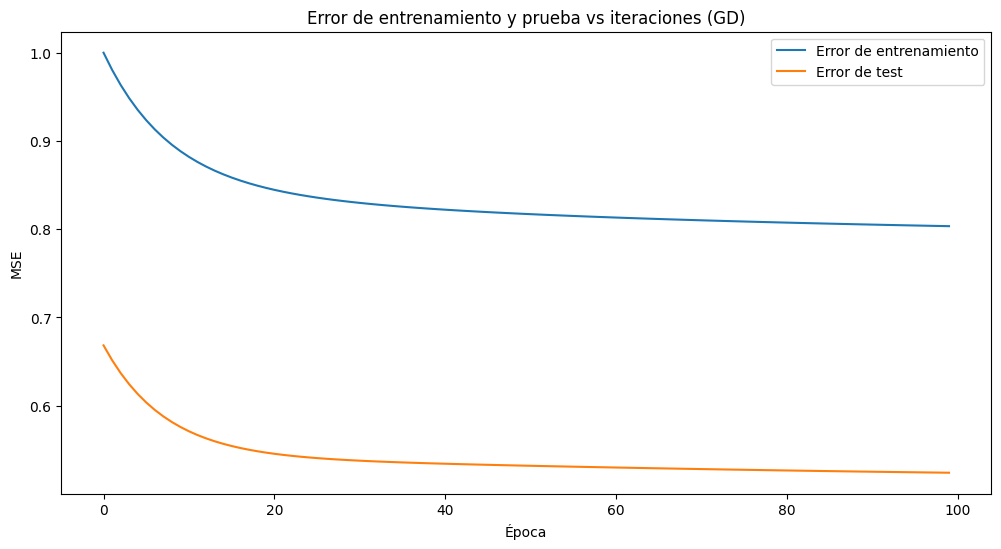

array([[ 0.00437],
       [ 0.04806],
       [ 0.14606],
       [ 0.01488],
       [-0.1029 ],
       [ 0.11814],
       [-0.00126],
       [-0.02887],
       [ 0.03434],
       [ 0.18316],
       [-0.02673],
       [-0.01317],
       [ 0.06007],
       [ 0.02722],
       [ 0.03356],
       [ 0.01778],
       [-0.00872],
       [-0.01129],
       [ 0.00793],
       [ 0.00572],
       [-0.0012 ],
       [ 0.01581],
       [-0.00831],
       [-0.00633],
       [-0.01331],
       [ 0.00664],
       [ 0.00863]])

In [ ]:
coeficientes_gradiente_01, mse_train, mse_test = gradient_descent(X_train_z, y_train, X_test_z, y_test, epochs=100, lr=0.01)
coeficientes_gradiente_01

In [ ]:
r2_entrenamiento = r2(coeficientes_gradiente_01, X_train_z, y_train)
r2_prueba = r2(coeficientes_gradiente_01, X_test_z, y_test)
r2_ajustado_entrenamiento = r2_ajustado(X_train_z, y_train, r2_entrenamiento)
r2_ajustado_prueba = r2_ajustado(X_test_z, y_test, r2_prueba)
datos_gradiente_01 = np.insert(coeficientes_gradiente_01, len(coeficientes_gradiente_01), [r2_ajustado_entrenamiento, r2_ajustado_prueba, mse_train, mse_test])
coeficientes_gradiente['GD(epochs=100, lr=0.01)'] = datos_gradiente_01
coeficientes_gradiente


Regresion_lineal  GD(epochs=100, lr=0.01)
Intercept                         -0.005470                 0.004370
MinTemp                           -0.140960                 0.048060
Rainfall                           0.170280                 0.146060
Evaporation                        0.009310                 0.014880
Sunshine                          -0.150560                -0.102900
WindGustSpeed                      0.238050                 0.118140
WindSpeed9am                      -0.017460                -0.001260
WindSpeed3pm                      -0.095610                -0.028870
Humidity9am                       -0.033530                 0.034340
Humidity3pm                        0.389870                 0.183160
Pressure9am                       -0.010920                -0.026730
Cloud9am                          -0.049110                -0.013170
Cloud3pm                           0.022410                 0.060070
Temp3pm                            0.251610                 0.027220
RainToday                          0.011690                 0.033560
WindGustDir_Este                   0.065270                 0.017780
WindGustDir_Norte                 -0.060680                -0.008720
WindGustDir_Oeste                 -0.040400                -0.011290
WindDir3pm_Este                    0.010410                 0.007930
WindDir3pm_Norte                   0.030410                 0.005720
WindDir3pm_Oeste                   0.087360                -0.001200
WindDir9am_Este                    0.054840                 0.015810
WindDir9am_Norte                  -0.055840                -0.008310
WindDir9am_Oeste                  -0.025690                -0.006330
Estacion_Invierno                  0.029980                -0.013310
Estacion_Otoño                     0.037980                 0.006640
Estacion_Primavera                 0.050610                 0.008630
r2_ajustado_entrenamiento          0.220000                 0.200000
r2_ajustado_prueba                 0.220000                 0.200000
mse_train                          0.780802                 0.803414
mse_test                           0.510717                 0.523963

Con 100 epocas y un ratio de aprendizaje de 0.01 se puede ver un modelo con metricas no muy lejos de la regresion pero peor.

Los coeficientes son bastante distintos.

#### Modelo: GD(epochs=1000, lr=0.01)

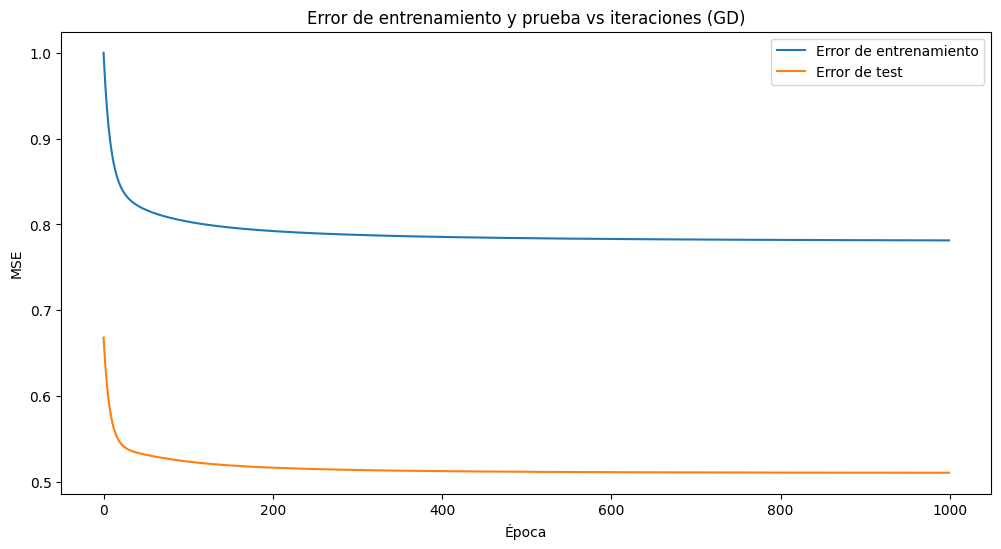

array([[ 0.00603],
       [-0.09873],
       [ 0.17301],
       [ 0.0055 ],
       [-0.14637],
       [ 0.24049],
       [-0.02326],
       [-0.09807],
       [-0.02216],
       [ 0.35134],
       [-0.00722],
       [-0.05183],
       [ 0.02836],
       [ 0.19619],
       [ 0.00753],
       [ 0.06838],
       [-0.0448 ],
       [-0.02417],
       [ 0.00508],
       [ 0.02384],
       [ 0.05798],
       [ 0.05378],
       [-0.0399 ],
       [-0.01935],
       [-0.01058],
       [ 0.01022],
       [ 0.03495]])

In [ ]:
coeficientes_gradiente_02, mse_train, mse_test = gradient_descent(X_train_z, y_train, X_test_z, y_test, epochs=1000, lr=0.01)
coeficientes_gradiente_02

In [ ]:
r2_entrenamiento = r2(coeficientes_gradiente_02, X_train_z, y_train)
r2_prueba = r2(coeficientes_gradiente_02, X_test_z, y_test)
r2_ajustado_entrenamiento = r2_ajustado(X_train_z, y_train, r2_entrenamiento)
r2_ajustado_prueba = r2_ajustado(X_test_z, y_test, r2_prueba)
datos_gradiente_02 = np.insert(coeficientes_gradiente_02, len(coeficientes_gradiente_02), [r2_ajustado_entrenamiento, r2_ajustado_prueba, mse_train, mse_test])
coeficientes_gradiente['GD(epochs=1000, lr=0.01)'] = datos_gradiente_02
coeficientes_gradiente


Regresion_lineal  GD(epochs=100, lr=0.01)  \
Intercept                         -0.005470                 0.004370   
MinTemp                           -0.140960                 0.048060   
Rainfall                           0.170280                 0.146060   
Evaporation                        0.009310                 0.014880   
Sunshine                          -0.150560                -0.102900   
WindGustSpeed                      0.238050                 0.118140   
WindSpeed9am                      -0.017460                -0.001260   
WindSpeed3pm                      -0.095610                -0.028870   
Humidity9am                       -0.033530                 0.034340   
Humidity3pm                        0.389870                 0.183160   
Pressure9am                       -0.010920                -0.026730   
Cloud9am                          -0.049110                -0.013170   
Cloud3pm                           0.022410                 0.060070   
Temp3pm                            0.251610                 0.027220   
RainToday                          0.011690                 0.033560   
WindGustDir_Este                   0.065270                 0.017780   
WindGustDir_Norte                 -0.060680                -0.008720   
WindGustDir_Oeste                 -0.040400                -0.011290   
WindDir3pm_Este                    0.010410                 0.007930   
WindDir3pm_Norte                   0.030410                 0.005720   
WindDir3pm_Oeste                   0.087360                -0.001200   
WindDir9am_Este                    0.054840                 0.015810   
WindDir9am_Norte                  -0.055840                -0.008310   
WindDir9am_Oeste                  -0.025690                -0.006330   
Estacion_Invierno                  0.029980                -0.013310   
Estacion_Otoño                     0.037980                 0.006640   
Estacion_Primavera                 0.050610                 0.008630   
r2_ajustado_entrenamiento          0.220000                 0.200000   
r2_ajustado_prueba                 0.220000                 0.200000   
mse_train                          0.780802                 0.803414   
mse_test                           0.510717                 0.523963   

                           GD(epochs=1000, lr=0.01)  
Intercept                                  0.006030  
MinTemp                                   -0.098730  
Rainfall                                   0.173010  
Evaporation                                0.005500  
Sunshine                                  -0.146370  
WindGustSpeed                              0.240490  
WindSpeed9am                              -0.023260  
WindSpeed3pm                              -0.098070  
Humidity9am                               -0.022160  
Humidity3pm                                0.351340  
Pressure9am                               -0.007220  
Cloud9am                                  -0.051830  
Cloud3pm                                   0.028360  
Temp3pm                                    0.196190  
RainToday                                  0.007530  
WindGustDir_Este                           0.068380  
WindGustDir_Norte                         -0.044800  
WindGustDir_Oeste                         -0.024170  
WindDir3pm_Este                            0.005080  
WindDir3pm_Norte                           0.023840  
WindDir3pm_Oeste                           0.057980  
WindDir9am_Este                            0.053780  
WindDir9am_Norte                          -0.039900  
WindDir9am_Oeste                          -0.019350  
Estacion_Invierno                         -0.010580  
Estacion_Otoño                             0.010220  
Estacion_Primavera                         0.034950  
r2_ajustado_entrenamiento                  0.220000  
r2_ajustado_prueba                         0.220000  
mse_train                                  0.781467  
mse_test                                   0.510

Con 500 epocas y el mismo lr es bastante parecido ya en metricas.

A los coeficientes aun les falta.

#### Modelo: GD(epochs=10000, lr=0.01)

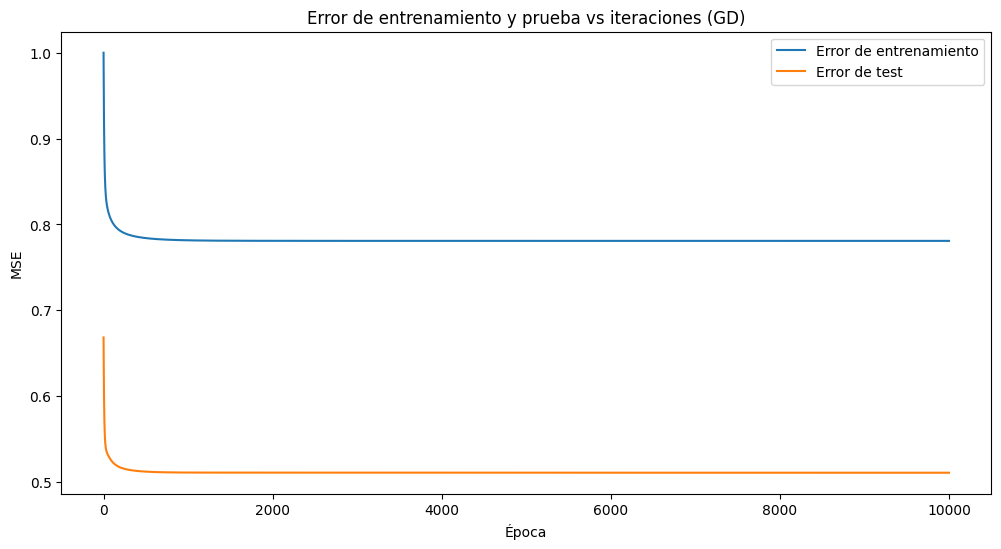

array([[-0.00532],
       [-0.14097],
       [ 0.17028],
       [ 0.00929],
       [-0.15057],
       [ 0.23806],
       [-0.01746],
       [-0.09561],
       [-0.03354],
       [ 0.38985],
       [-0.01091],
       [-0.04912],
       [ 0.02241],
       [ 0.25155],
       [ 0.01169],
       [ 0.06532],
       [-0.06062],
       [-0.04032],
       [ 0.01037],
       [ 0.03038],
       [ 0.08731],
       [ 0.05483],
       [-0.05581],
       [-0.02566],
       [ 0.02967],
       [ 0.03773],
       [ 0.05043]])

In [ ]:
coeficientes_gradiente_03, mse_train, mse_test = gradient_descent(X_train_z, y_train, X_test_z, y_test, epochs=10000, lr=0.01)
coeficientes_gradiente_03

In [ ]:
r2_entrenamiento = r2(coeficientes_gradiente_03, X_train_z, y_train)
r2_prueba = r2(coeficientes_gradiente_03, X_test_z, y_test)
r2_ajustado_entrenamiento = r2_ajustado(X_train_z, y_train, r2_entrenamiento)
r2_ajustado_prueba = r2_ajustado(X_test_z, y_test, r2_prueba)
datos_gradiente_03 = np.insert(coeficientes_gradiente_03, len(coeficientes_gradiente_03), [r2_ajustado_entrenamiento, r2_ajustado_prueba, mse_train, mse_test])
coeficientes_gradiente['GD(epochs=10000, lr=0.01)'] = datos_gradiente_03
coeficientes_gradiente


Regresion_lineal  GD(epochs=100, lr=0.01)  \
Intercept                         -0.005470                 0.004370   
MinTemp                           -0.140960                 0.048060   
Rainfall                           0.170280                 0.146060   
Evaporation                        0.009310                 0.014880   
Sunshine                          -0.150560                -0.102900   
WindGustSpeed                      0.238050                 0.118140   
WindSpeed9am                      -0.017460                -0.001260   
WindSpeed3pm                      -0.095610                -0.028870   
Humidity9am                       -0.033530                 0.034340   
Humidity3pm                        0.389870                 0.183160   
Pressure9am                       -0.010920                -0.026730   
Cloud9am                          -0.049110                -0.013170   
Cloud3pm                           0.022410                 0.060070   
Temp3pm                            0.251610                 0.027220   
RainToday                          0.011690                 0.033560   
WindGustDir_Este                   0.065270                 0.017780   
WindGustDir_Norte                 -0.060680                -0.008720   
WindGustDir_Oeste                 -0.040400                -0.011290   
WindDir3pm_Este                    0.010410                 0.007930   
WindDir3pm_Norte                   0.030410                 0.005720   
WindDir3pm_Oeste                   0.087360                -0.001200   
WindDir9am_Este                    0.054840                 0.015810   
WindDir9am_Norte                  -0.055840                -0.008310   
WindDir9am_Oeste                  -0.025690                -0.006330   
Estacion_Invierno                  0.029980                -0.013310   
Estacion_Otoño                     0.037980                 0.006640   
Estacion_Primavera                 0.050610                 0.008630   
r2_ajustado_entrenamiento          0.220000                 0.200000   
r2_ajustado_prueba                 0.220000                 0.200000   
mse_train                          0.780802                 0.803414   
mse_test                           0.510717                 0.523963   

                           GD(epochs=1000, lr=0.01)  GD(epochs=10000, lr=0.01)  
Intercept                                  0.006030                  -0.005320  
MinTemp                                   -0.098730                  -0.140970  
Rainfall                                   0.173010                   0.170280  
Evaporation                                0.005500                   0.009290  
Sunshine                                  -0.146370                  -0.150570  
WindGustSpeed                              0.240490                   0.238060  
WindSpeed9am                              -0.023260                  -0.017460  
WindSpeed3pm                              -0.098070                  -0.095610  
Humidity9am                               -0.022160                  -0.033540  
Humidity3pm                                0.351340                   0.389850  
Pressure9am                               -0.007220                  -0.010910  
Cloud9am                                  -0.051830                  -0.049120  
Cloud3pm                                   0.028360                   0.022410  
Temp3pm                                    0.196190                   0.251550  
RainToday                                  0.007530                   0.011690  
WindGustDir_Este                           0.068380                   0.065320  
WindGustDir_Norte                         -0.044800                  -0.060620  
WindGustDir_Oeste                         -0.024170                  -0.040320  
WindDir3pm_Este                            0.005080                   0.010370  
WindDir3pm_Norte                           0.023840                   0.030380  
WindDir3pm_Oeste     

Con 10000 epocas ya casi es identico en cuanto a coeficientes y metricas.

#### Modelo: GD(epochs=100, lr=0.1)

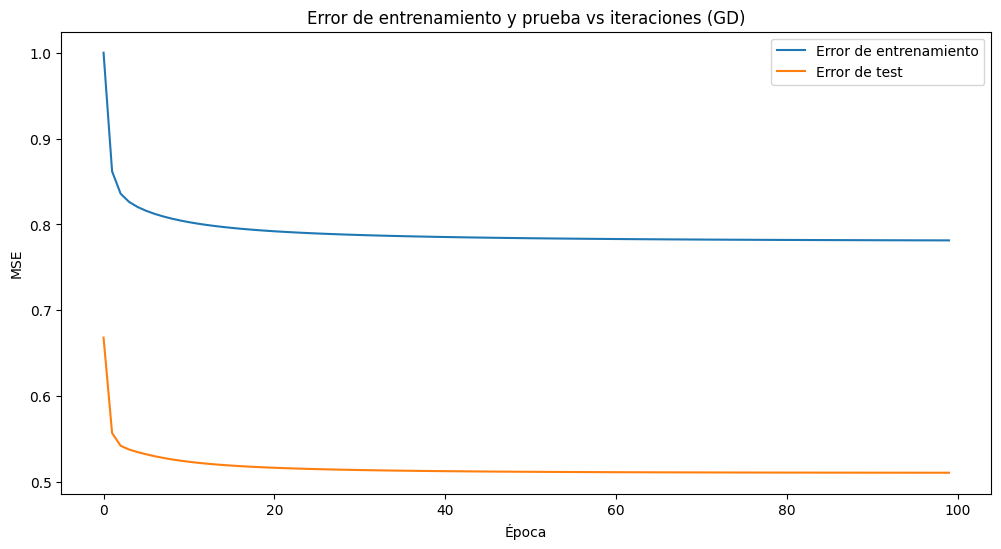

array([[ 0.00607],
       [-0.09928],
       [ 0.17298],
       [ 0.00549],
       [-0.14646],
       [ 0.24063],
       [-0.02322],
       [-0.09814],
       [-0.02232],
       [ 0.35182],
       [-0.00721],
       [-0.05181],
       [ 0.02825],
       [ 0.19679],
       [ 0.00757],
       [ 0.06856],
       [-0.04492],
       [-0.02419],
       [ 0.00505],
       [ 0.02387],
       [ 0.05821],
       [ 0.0539 ],
       [-0.04001],
       [-0.01936],
       [-0.01059],
       [ 0.01019],
       [ 0.03498]])

In [ ]:
coeficientes_gradiente_04, mse_train, mse_test = gradient_descent(X_train_z, y_train, X_test_z, y_test, epochs=100, lr=0.1)
coeficientes_gradiente_04

In [ ]:
r2_entrenamiento = r2(coeficientes_gradiente_04, X_train_z, y_train)
r2_prueba = r2(coeficientes_gradiente_04, X_test_z, y_test)
r2_ajustado_entrenamiento = r2_ajustado(X_train_z, y_train, r2_entrenamiento)
r2_ajustado_prueba = r2_ajustado(X_test_z, y_test, r2_prueba)
datos_gradiente_04 = np.insert(coeficientes_gradiente_04, len(coeficientes_gradiente_04), [r2_ajustado_entrenamiento, r2_ajustado_prueba, mse_train, mse_test])
coeficientes_gradiente['GD(epochs=100, lr=0.1)'] = datos_gradiente_04
coeficientes_gradiente


Regresion_lineal  GD(epochs=100, lr=0.01)  \
Intercept                         -0.005470                 0.004370   
MinTemp                           -0.140960                 0.048060   
Rainfall                           0.170280                 0.146060   
Evaporation                        0.009310                 0.014880   
Sunshine                          -0.150560                -0.102900   
WindGustSpeed                      0.238050                 0.118140   
WindSpeed9am                      -0.017460                -0.001260   
WindSpeed3pm                      -0.095610                -0.028870   
Humidity9am                       -0.033530                 0.034340   
Humidity3pm                        0.389870                 0.183160   
Pressure9am                       -0.010920                -0.026730   
Cloud9am                          -0.049110                -0.013170   
Cloud3pm                           0.022410                 0.060070   
Temp3pm                            0.251610                 0.027220   
RainToday                          0.011690                 0.033560   
WindGustDir_Este                   0.065270                 0.017780   
WindGustDir_Norte                 -0.060680                -0.008720   
WindGustDir_Oeste                 -0.040400                -0.011290   
WindDir3pm_Este                    0.010410                 0.007930   
WindDir3pm_Norte                   0.030410                 0.005720   
WindDir3pm_Oeste                   0.087360                -0.001200   
WindDir9am_Este                    0.054840                 0.015810   
WindDir9am_Norte                  -0.055840                -0.008310   
WindDir9am_Oeste                  -0.025690                -0.006330   
Estacion_Invierno                  0.029980                -0.013310   
Estacion_Otoño                     0.037980                 0.006640   
Estacion_Primavera                 0.050610                 0.008630   
r2_ajustado_entrenamiento          0.220000                 0.200000   
r2_ajustado_prueba                 0.220000                 0.200000   
mse_train                          0.780802                 0.803414   
mse_test                           0.510717                 0.523963   

                           GD(epochs=1000, lr=0.01)  \
Intercept                                  0.006030   
MinTemp                                   -0.098730   
Rainfall                                   0.173010   
Evaporation                                0.005500   
Sunshine                                  -0.146370   
WindGustSpeed                              0.240490   
WindSpeed9am                              -0.023260   
WindSpeed3pm                              -0.098070   
Humidity9am                               -0.022160   
Humidity3pm                                0.351340   
Pressure9am                               -0.007220   
Cloud9am                                  -0.051830   
Cloud3pm                                   0.028360   
Temp3pm                                    0.196190   
RainToday                                  0.007530   
WindGustDir_Este                           0.068380   
WindGustDir_Norte                         -0.044800   
WindGustDir_Oeste                         -0.024170   
WindDir3pm_Este                            0.005080   
WindDir3pm_Norte                           0.023840   
WindDir3pm_Oeste                           0.057980   
WindDir9am_Este                            0.053780   
WindDir9am_Norte                          -0.039900   
WindDir9am_Oeste                          -0.019350   
Estacion_Invierno                         -0.010580   
Estacion_Otoño                             0.010220   
Estacion_Primavera                         0.034950   
r2_ajustado_entrenamiento                  0.220000   
r2_ajustado_prueba                         0.220000   
mse_train                                  0.781467   
mse_test         

Con 100 epocas y un lr de 0.1 tenemos metricas muy cercanas y los coeficientes algunos muy similares y algunos estan bastante cerca.

#### Modelo: GD(epochs=1500, lr=0.1)

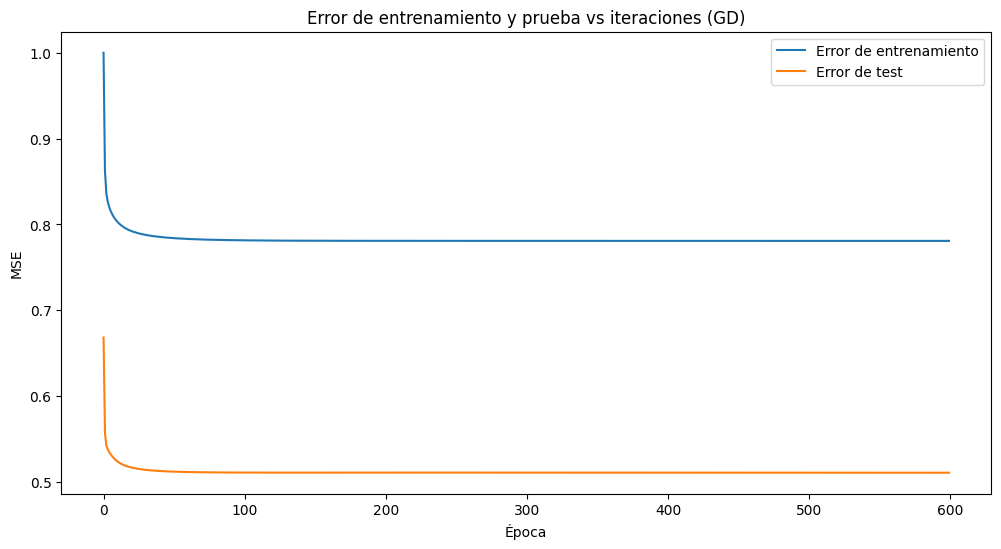

array([[-0.00418],
       [-0.14098],
       [ 0.17031],
       [ 0.0091 ],
       [-0.15069],
       [ 0.23814],
       [-0.01746],
       [-0.09563],
       [-0.03359],
       [ 0.3897 ],
       [-0.01079],
       [-0.0492 ],
       [ 0.02237],
       [ 0.25106],
       [ 0.01167],
       [ 0.06586],
       [-0.05998],
       [-0.03963],
       [ 0.00984],
       [ 0.02993],
       [ 0.08676],
       [ 0.05491],
       [-0.05556],
       [-0.02539],
       [ 0.02735],
       [ 0.03584],
       [ 0.04908]])

In [ ]:
coeficientes_gradiente_05, mse_train, mse_test = gradient_descent(X_train_z, y_train, X_test_z, y_test, epochs=600, lr=0.1)
coeficientes_gradiente_05

In [ ]:
r2_entrenamiento = r2(coeficientes_gradiente_05, X_train_z, y_train)
r2_prueba = r2(coeficientes_gradiente_05, X_test_z, y_test)
r2_ajustado_entrenamiento = r2_ajustado(X_train_z, y_train, r2_entrenamiento)
r2_ajustado_prueba = r2_ajustado(X_test_z, y_test, r2_prueba)
datos_gradiente_05 = np.insert(coeficientes_gradiente_05, len(coeficientes_gradiente_05), [r2_ajustado_entrenamiento, r2_ajustado_prueba, mse_train, mse_test])
coeficientes_gradiente['GD(epochs=600, lr=0.1)'] = datos_gradiente_05
coeficientes_gradiente


Regresion_lineal  GD(epochs=100, lr=0.01)  \
Intercept                         -0.005470                 0.004370   
MinTemp                           -0.140960                 0.048060   
Rainfall                           0.170280                 0.146060   
Evaporation                        0.009310                 0.014880   
Sunshine                          -0.150560                -0.102900   
WindGustSpeed                      0.238050                 0.118140   
WindSpeed9am                      -0.017460                -0.001260   
WindSpeed3pm                      -0.095610                -0.028870   
Humidity9am                       -0.033530                 0.034340   
Humidity3pm                        0.389870                 0.183160   
Pressure9am                       -0.010920                -0.026730   
Cloud9am                          -0.049110                -0.013170   
Cloud3pm                           0.022410                 0.060070   
Temp3pm                            0.251610                 0.027220   
RainToday                          0.011690                 0.033560   
WindGustDir_Este                   0.065270                 0.017780   
WindGustDir_Norte                 -0.060680                -0.008720   
WindGustDir_Oeste                 -0.040400                -0.011290   
WindDir3pm_Este                    0.010410                 0.007930   
WindDir3pm_Norte                   0.030410                 0.005720   
WindDir3pm_Oeste                   0.087360                -0.001200   
WindDir9am_Este                    0.054840                 0.015810   
WindDir9am_Norte                  -0.055840                -0.008310   
WindDir9am_Oeste                  -0.025690                -0.006330   
Estacion_Invierno                  0.029980                -0.013310   
Estacion_Otoño                     0.037980                 0.006640   
Estacion_Primavera                 0.050610                 0.008630   
r2_ajustado_entrenamiento          0.220000                 0.200000   
r2_ajustado_prueba                 0.220000                 0.200000   
mse_train                          0.780802                 0.803414   
mse_test                           0.510717                 0.523963   

                           GD(epochs=1000, lr=0.01)  \
Intercept                                  0.006030   
MinTemp                                   -0.098730   
Rainfall                                   0.173010   
Evaporation                                0.005500   
Sunshine                                  -0.146370   
WindGustSpeed                              0.240490   
WindSpeed9am                              -0.023260   
WindSpeed3pm                              -0.098070   
Humidity9am                               -0.022160   
Humidity3pm                                0.351340   
Pressure9am                               -0.007220   
Cloud9am                                  -0.051830   
Cloud3pm                                   0.028360   
Temp3pm                                    0.196190   
RainToday                                  0.007530   
WindGustDir_Este                           0.068380   
WindGustDir_Norte                         -0.044800   
WindGustDir_Oeste                         -0.024170   
WindDir3pm_Este                            0.005080   
WindDir3pm_Norte                           0.023840   
WindDir3pm_Oeste                           0.057980   
WindDir9am_Este                            0.053780   
WindDir9am_Norte                          -0.039900   
WindDir9am_Oeste                          -0.019350   
Estacion_Invierno                         -0.010580   
Estacion_Otoño                             0.010220   
Estacion_Primavera                         0.034950   
r2_ajustado_entrenamiento                  0.220000   
r2_ajustado_prueba                         0.220000   
mse_train                                  0.781467   
mse_test         

Con 600 epocas y un lr de 0.1 son muy parecidos.

## Gradiente Descendente Estocastico:

### Funcion de optimizacion:

In [ ]:
def stochastic_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100):

    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    y_train = y_train.values

    for i in range(epochs):

        print(f'Epoca: {i+1}')

        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)

        X_train = X_train[permutation]
        y_train = y_train[permutation]

        for j in range(n):
            # Obtener una muestra aleatoria de un solo dato para hacer SGD
            x_sample = X_train[j]

            y_sample = y_train[j]

            prediction = np.matmul(x_sample, W)
            error = y_sample - prediction
            train_mse = error ** 2
            train_errors.append(train_mse)

            gradient = -2 * error * x_sample.T.reshape(-1, 1)

            W = W - (lr * gradient)

            prediction_test = np.matmul(X_test, W)
            prediction_test = np.squeeze(prediction_test)

            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (SGD)')
    plt.show()

    return np.round(W, 5), train_errors[-1], test_errors[-1]

In [ ]:
coeficientes_gde = coeficientes_prediccion.copy()

### Modelos:

#### Modelo GDE: (epochs=100, lr=0.01)

Epoca: 1
Epoca: 2
Epoca: 3
Epoca: 4
Epoca: 5
Epoca: 6
Epoca: 7
Epoca: 8
Epoca: 9
Epoca: 10
Epoca: 11
Epoca: 12
Epoca: 13
Epoca: 14
Epoca: 15
Epoca: 16
Epoca: 17
Epoca: 18
Epoca: 19
Epoca: 20
Epoca: 21
Epoca: 22
Epoca: 23
Epoca: 24
Epoca: 25
Epoca: 26
Epoca: 27
Epoca: 28
Epoca: 29
Epoca: 30
Epoca: 31
Epoca: 32
Epoca: 33
Epoca: 34
Epoca: 35
Epoca: 36
Epoca: 37
Epoca: 38
Epoca: 39
Epoca: 40
Epoca: 41
Epoca: 42
Epoca: 43
Epoca: 44
Epoca: 45
Epoca: 46
Epoca: 47
Epoca: 48
Epoca: 49
Epoca: 50
Epoca: 51
Epoca: 52
Epoca: 53
Epoca: 54
Epoca: 55
Epoca: 56
Epoca: 57
Epoca: 58
Epoca: 59
Epoca: 60
Epoca: 61
Epoca: 62
Epoca: 63
Epoca: 64
Epoca: 65
Epoca: 66
Epoca: 67
Epoca: 68
Epoca: 69
Epoca: 70
Epoca: 71
Epoca: 72
Epoca: 73
Epoca: 74
Epoca: 75
Epoca: 76
Epoca: 77
Epoca: 78
Epoca: 79
Epoca: 80
Epoca: 81
Epoca: 82
Epoca: 83
Epoca: 84
Epoca: 85
Epoca: 86
Epoca: 87
Epoca: 88
Epoca: 89
Epoca: 90
Epoca: 91
Epoca: 92
Epoca: 93
Epoca: 94
Epoca: 95
Epoca: 96
Epoca: 97
Epoca: 98
Epoca: 99
Epoca: 100


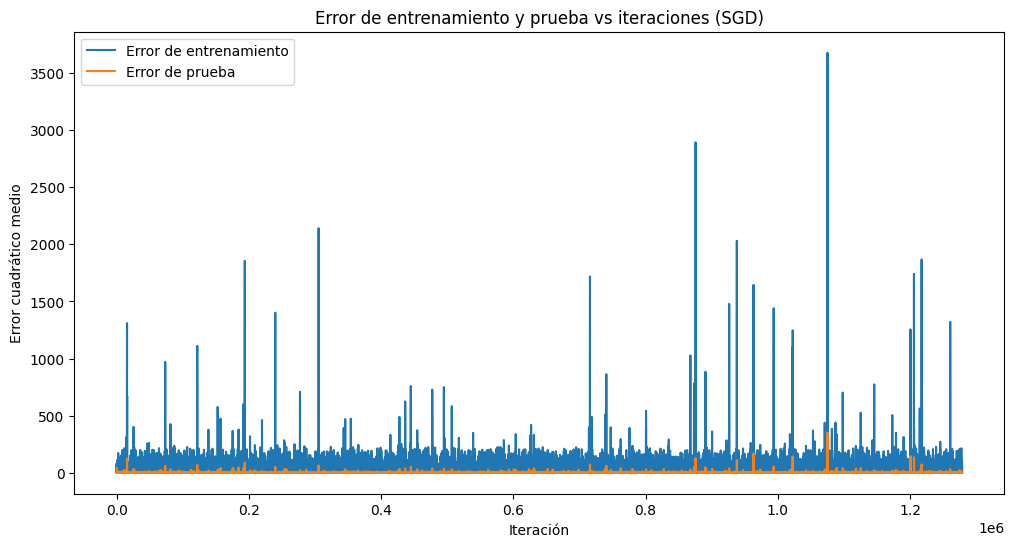

array([[-0.19577],
       [-0.02228],
       [ 0.11336],
       [ 0.02092],
       [-0.40602],
       [ 0.25844],
       [ 0.17036],
       [ 0.21707],
       [-0.02973],
       [ 0.37305],
       [ 0.02947],
       [ 0.08906],
       [ 0.09546],
       [ 0.06475],
       [ 0.11499],
       [-0.03329],
       [-0.04768],
       [-0.07966],
       [-0.01275],
       [-0.01604],
       [-0.00878],
       [ 0.06079],
       [-0.00998],
       [-0.21682],
       [ 0.12625],
       [ 0.1473 ],
       [ 0.0337 ]])

In [ ]:
coeficientes_gde_01, mse_train, mse_test = stochastic_gradient_descent(X_train_z, y_train, X_test_z, y_test, epochs=100, lr=0.01)
coeficientes_gde_01

In [ ]:
r2_entrenamiento = r2(coeficientes_gde_01, X_train_z, y_train)
r2_prueba = r2(coeficientes_gde_01, X_test_z, y_test)
r2_ajustado_entrenamiento = r2_ajustado(X_train_z, y_train, r2_entrenamiento)
r2_ajustado_prueba = r2_ajustado(X_test_z, y_test, r2_prueba)
datos_gde_01 = np.insert(coeficientes_gde_01, len(coeficientes_gde_01), [r2_ajustado_entrenamiento, r2_ajustado_prueba, mse_train, mse_test])
coeficientes_gde['GD(epochs=100, lr=0.01)'] = datos_gde_01
coeficientes_gde


Regresion_lineal  GD(epochs=100, lr=0.01)
Intercept                         -0.005470                -0.195770
MinTemp                           -0.140960                -0.022280
Rainfall                           0.170280                 0.113360
Evaporation                        0.009310                 0.020920
Sunshine                          -0.150560                -0.406020
WindGustSpeed                      0.238050                 0.258440
WindSpeed9am                      -0.017460                 0.170360
WindSpeed3pm                      -0.095610                 0.217070
Humidity9am                       -0.033530                -0.029730
Humidity3pm                        0.389870                 0.373050
Pressure9am                       -0.010920                 0.029470
Cloud9am                          -0.049110                 0.089060
Cloud3pm                           0.022410                 0.095460
Temp3pm                            0.251610                 0.064750
RainToday                          0.011690                 0.114990
WindGustDir_Este                   0.065270                -0.033290
WindGustDir_Norte                 -0.060680                -0.047680
WindGustDir_Oeste                 -0.040400                -0.079660
WindDir3pm_Este                    0.010410                -0.012750
WindDir3pm_Norte                   0.030410                -0.016040
WindDir3pm_Oeste                   0.087360                -0.008780
WindDir9am_Este                    0.054840                 0.060790
WindDir9am_Norte                  -0.055840                -0.009980
WindDir9am_Oeste                  -0.025690                -0.216820
Estacion_Invierno                  0.029980                 0.126250
Estacion_Otoño                     0.037980                 0.147300
Estacion_Primavera                 0.050610                 0.033700
r2_ajustado_entrenamiento          0.220000                -0.340000
r2_ajustado_prueba                 0.220000                -0.680000
mse_train                          0.780802                42.037500
mse_test                           0.510717                 1.114197

Para la primera prueba de GDE, con un lr de 0.01 100 epocas son muy poco aparentemente, las metricas estan muy lejos de nuestra regresion lineal y tambien los coeficientes.

#### Modelo GDE: (epochs=500, lr=0.01)

Epoca: 1
Epoca: 2
Epoca: 3
Epoca: 4
Epoca: 5
Epoca: 6
Epoca: 7
Epoca: 8
Epoca: 9
Epoca: 10
Epoca: 11
Epoca: 12
Epoca: 13
Epoca: 14
Epoca: 15
Epoca: 16
Epoca: 17
Epoca: 18
Epoca: 19
Epoca: 20
Epoca: 21
Epoca: 22
Epoca: 23
Epoca: 24
Epoca: 25
Epoca: 26
Epoca: 27
Epoca: 28
Epoca: 29
Epoca: 30
Epoca: 31
Epoca: 32
Epoca: 33
Epoca: 34
Epoca: 35
Epoca: 36
Epoca: 37
Epoca: 38
Epoca: 39
Epoca: 40
Epoca: 41
Epoca: 42
Epoca: 43
Epoca: 44
Epoca: 45
Epoca: 46
Epoca: 47
Epoca: 48
Epoca: 49
Epoca: 50
Epoca: 51
Epoca: 52
Epoca: 53
Epoca: 54
Epoca: 55
Epoca: 56
Epoca: 57
Epoca: 58
Epoca: 59
Epoca: 60
Epoca: 61
Epoca: 62
Epoca: 63
Epoca: 64
Epoca: 65
Epoca: 66
Epoca: 67
Epoca: 68
Epoca: 69
Epoca: 70
Epoca: 71
Epoca: 72
Epoca: 73
Epoca: 74
Epoca: 75
Epoca: 76
Epoca: 77
Epoca: 78
Epoca: 79
Epoca: 80
Epoca: 81
Epoca: 82
Epoca: 83
Epoca: 84
Epoca: 85
Epoca: 86
Epoca: 87
Epoca: 88
Epoca: 89
Epoca: 90
Epoca: 91
Epoca: 92
Epoca: 93
Epoca: 94
Epoca: 95
Epoca: 96
Epoca: 97
Epoca: 98
Epoca: 99
Epoca: 100
Epoca: 1

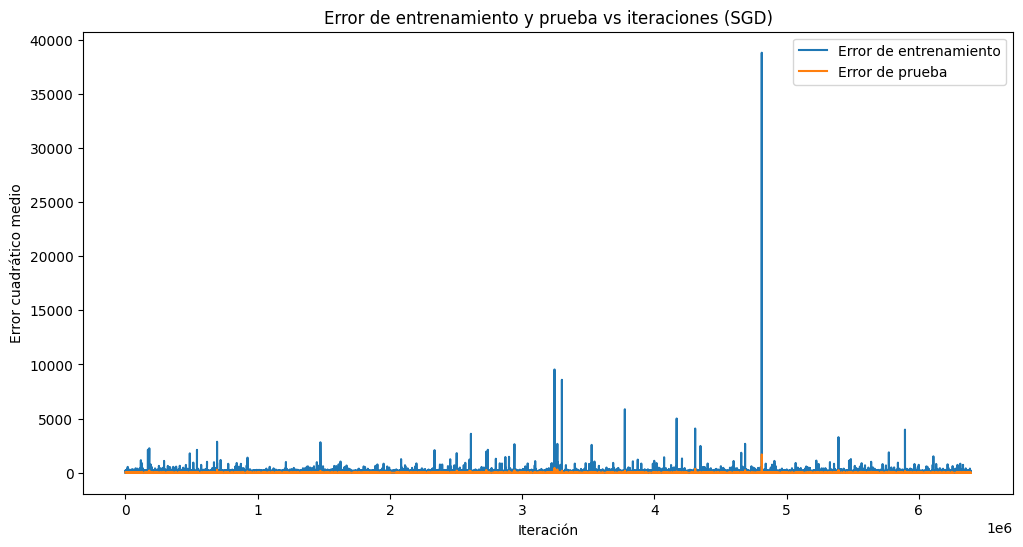

array([[-0.04017],
       [-0.18555],
       [-0.07552],
       [-0.05419],
       [-0.10231],
       [ 0.27072],
       [-0.00628],
       [-0.07266],
       [-0.0425 ],
       [ 0.24632],
       [-0.11575],
       [-0.02773],
       [ 0.06286],
       [ 0.3214 ],
       [ 0.01136],
       [ 0.13227],
       [-0.09878],
       [ 0.02477],
       [ 0.04078],
       [ 0.00929],
       [ 0.06336],
       [ 0.02502],
       [-0.08044],
       [ 0.00229],
       [ 0.12048],
       [-0.0122 ],
       [ 0.05181]])

In [ ]:
coeficientes_gde_02, mse_train, mse_test = stochastic_gradient_descent(X_train_z, y_train, X_test_z, y_test, epochs=500, lr=0.01)
coeficientes_gde_02

In [ ]:
r2_entrenamiento = r2(coeficientes_gde_02, X_train_z, y_train)
r2_prueba = r2(coeficientes_gde_02, X_test_z, y_test)
r2_ajustado_entrenamiento = r2_ajustado(X_train_z, y_train, r2_entrenamiento)
r2_ajustado_prueba = r2_ajustado(X_test_z, y_test, r2_prueba)
datos_gde_02 = np.insert(coeficientes_gde_02, len(coeficientes_gde_02), [r2_ajustado_entrenamiento, r2_ajustado_prueba, mse_train, mse_test])
coeficientes_gde['GD(epochs=500, lr=0.01)'] = datos_gde_02
coeficientes_gde


Regresion_lineal  GD(epochs=100, lr=0.01)  \
Intercept                         -0.005470                -0.195770   
MinTemp                           -0.140960                -0.022280   
Rainfall                           0.170280                 0.113360   
Evaporation                        0.009310                 0.020920   
Sunshine                          -0.150560                -0.406020   
WindGustSpeed                      0.238050                 0.258440   
WindSpeed9am                      -0.017460                 0.170360   
WindSpeed3pm                      -0.095610                 0.217070   
Humidity9am                       -0.033530                -0.029730   
Humidity3pm                        0.389870                 0.373050   
Pressure9am                       -0.010920                 0.029470   
Cloud9am                          -0.049110                 0.089060   
Cloud3pm                           0.022410                 0.095460   
Temp3pm                            0.251610                 0.064750   
RainToday                          0.011690                 0.114990   
WindGustDir_Este                   0.065270                -0.033290   
WindGustDir_Norte                 -0.060680                -0.047680   
WindGustDir_Oeste                 -0.040400                -0.079660   
WindDir3pm_Este                    0.010410                -0.012750   
WindDir3pm_Norte                   0.030410                -0.016040   
WindDir3pm_Oeste                   0.087360                -0.008780   
WindDir9am_Este                    0.054840                 0.060790   
WindDir9am_Norte                  -0.055840                -0.009980   
WindDir9am_Oeste                  -0.025690                -0.216820   
Estacion_Invierno                  0.029980                 0.126250   
Estacion_Otoño                     0.037980                 0.147300   
Estacion_Primavera                 0.050610                 0.033700   
r2_ajustado_entrenamiento          0.220000                -0.340000   
r2_ajustado_prueba                 0.220000                -0.680000   
mse_train                          0.780802                42.037500   
mse_test                           0.510717                 1.114197   

                           GD(epochs=500, lr=0.01)  
Intercept                                -0.040170  
MinTemp                                  -0.185550  
Rainfall                                 -0.075520  
Evaporation                              -0.054190  
Sunshine                                 -0.102310  
WindGustSpeed                             0.270720  
WindSpeed9am                             -0.006280  
WindSpeed3pm                             -0.072660  
Humidity9am                              -0.042500  
Humidity3pm                               0.246320  
Pressure9am                              -0.115750  
Cloud9am                                 -0.027730  
Cloud3pm                                  0.062860  
Temp3pm                                   0.321400  
RainToday                                 0.011360  
WindGustDir_Este                          0.132270  
WindGustDir_Norte                        -0.098780  
WindGustDir_Oeste                         0.024770  
WindDir3pm_Este                           0.040780  
WindDir3pm_Norte                          0.009290  
WindDir3pm_Oeste                          0.063360  
WindDir9am_Este                           0.025020  
WindDir9am_Norte                         -0.080440  
WindDir9am_Oeste                          0.002290  
Estacion_Invierno                         0.120480  
Estacion_Otoño                           -0.012200  
Estacion_Primavera                        0.051810  
r2_ajustado_entrenamiento                 0.090000  
r2_ajustado_prueba                        0.090000  
mse_train                                 0.624916  
mse_test                                  0.598477

Subiendole las epocas a 500 tampoco hemos logrado un buen resultado.

#### Modelo GDE: (epochs=10, lr=0.01)

Epoca: 1
Epoca: 2
Epoca: 3
Epoca: 4
Epoca: 5
Epoca: 6
Epoca: 7
Epoca: 8
Epoca: 9
Epoca: 10


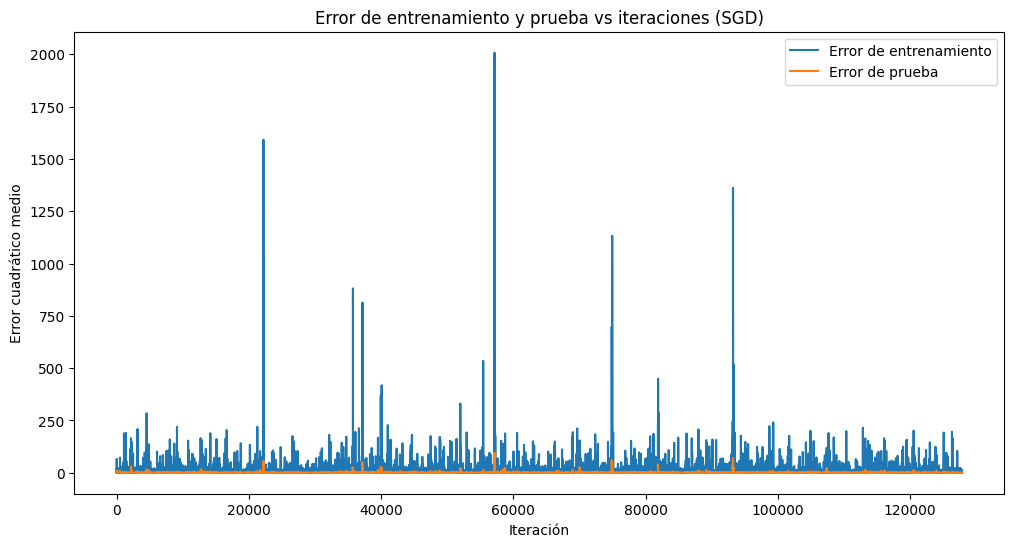

array([[-0.09448],
       [-0.12384],
       [ 0.07004],
       [-0.00462],
       [-0.08677],
       [ 0.25865],
       [-0.02311],
       [ 0.04479],
       [-0.00871],
       [ 0.18806],
       [ 0.03956],
       [ 0.09221],
       [ 0.0482 ],
       [ 0.21634],
       [ 0.09532],
       [ 0.16835],
       [-0.05177],
       [ 0.00359],
       [-0.10368],
       [ 0.00209],
       [-0.00355],
       [ 0.02383],
       [ 0.03374],
       [-0.021  ],
       [ 0.03785],
       [ 0.07918],
       [-0.03181]])

In [ ]:
coeficientes_gde_03, mse_train, mse_test = stochastic_gradient_descent(X_train_z, y_train, X_test_z, y_test, epochs=10, lr=0.01)
coeficientes_gde_03

In [ ]:
r2_entrenamiento = r2(coeficientes_gde_03, X_train_z, y_train)
r2_prueba = r2(coeficientes_gde_03, X_test_z, y_test)
r2_ajustado_entrenamiento = r2_ajustado(X_train_z, y_train, r2_entrenamiento)
r2_ajustado_prueba = r2_ajustado(X_test_z, y_test, r2_prueba)
datos_gde_03 = np.insert(coeficientes_gde_04, len(coeficientes_gde_03), [r2_ajustado_entrenamiento, r2_ajustado_prueba, mse_train, mse_test])
coeficientes_gde['GD(epochs=10, lr=0.1)'] = datos_gde_03
coeficientes_gde

Regresion_lineal  GD(epochs=100, lr=0.01)  \
Intercept                         -0.005470                -0.195770   
MinTemp                           -0.140960                -0.022280   
Rainfall                           0.170280                 0.113360   
Evaporation                        0.009310                 0.020920   
Sunshine                          -0.150560                -0.406020   
WindGustSpeed                      0.238050                 0.258440   
WindSpeed9am                      -0.017460                 0.170360   
WindSpeed3pm                      -0.095610                 0.217070   
Humidity9am                       -0.033530                -0.029730   
Humidity3pm                        0.389870                 0.373050   
Pressure9am                       -0.010920                 0.029470   
Cloud9am                          -0.049110                 0.089060   
Cloud3pm                           0.022410                 0.095460   
Temp3pm                            0.251610                 0.064750   
RainToday                          0.011690                 0.114990   
WindGustDir_Este                   0.065270                -0.033290   
WindGustDir_Norte                 -0.060680                -0.047680   
WindGustDir_Oeste                 -0.040400                -0.079660   
WindDir3pm_Este                    0.010410                -0.012750   
WindDir3pm_Norte                   0.030410                -0.016040   
WindDir3pm_Oeste                   0.087360                -0.008780   
WindDir9am_Este                    0.054840                 0.060790   
WindDir9am_Norte                  -0.055840                -0.009980   
WindDir9am_Oeste                  -0.025690                -0.216820   
Estacion_Invierno                  0.029980                 0.126250   
Estacion_Otoño                     0.037980                 0.147300   
Estacion_Primavera                 0.050610                 0.033700   
r2_ajustado_entrenamiento          0.220000                -0.340000   
r2_ajustado_prueba                 0.220000                -0.680000   
mse_train                          0.780802                42.037500   
mse_test                           0.510717                 1.114197   

                           GD(epochs=500, lr=0.01)  GD(epochs=10, lr=0.1)  
Intercept                                -0.040170              -0.094480  
MinTemp                                  -0.185550              -0.123840  
Rainfall                                 -0.075520               0.070040  
Evaporation                              -0.054190              -0.004620  
Sunshine                                 -0.102310              -0.086770  
WindGustSpeed                             0.270720               0.258650  
WindSpeed9am                             -0.006280              -0.023110  
WindSpeed3pm                             -0.072660               0.044790  
Humidity9am                              -0.042500              -0.008710  
Humidity3pm                               0.246320               0.188060  
Pressure9am                              -0.115750               0.039560  
Cloud9am                                 -0.027730               0.092210  
Cloud3pm                                  0.062860               0.048200  
Temp3pm                                   0.321400               0.216340  
RainToday                                 0.011360               0.095320  
WindGustDir_Este                          0.132270               0.168350  
WindGustDir_Norte                        -0.098780              -0.051770  
WindGustDir_Oeste                         0.024770               0.003590  
WindDir3pm_Este                           0.040780              -0.103680  
WindDir3pm_Norte                          0.009290               0.002090  
WindDir3pm_Oeste                          0.063360              -0.003550  
WindDir9am_Este                           0.025020

10 epocas y un lr de 0.1 es el mejor resultado obtenido por el momento en cuanto a metricas, en cuanto a los coeficientes no son parecidos a la regresion lineal.

#### Modelo GDE: (epochs=10, lr=0.005)

Epoca: 1
Epoca: 2
Epoca: 3
Epoca: 4
Epoca: 5
Epoca: 6
Epoca: 7
Epoca: 8
Epoca: 9
Epoca: 10


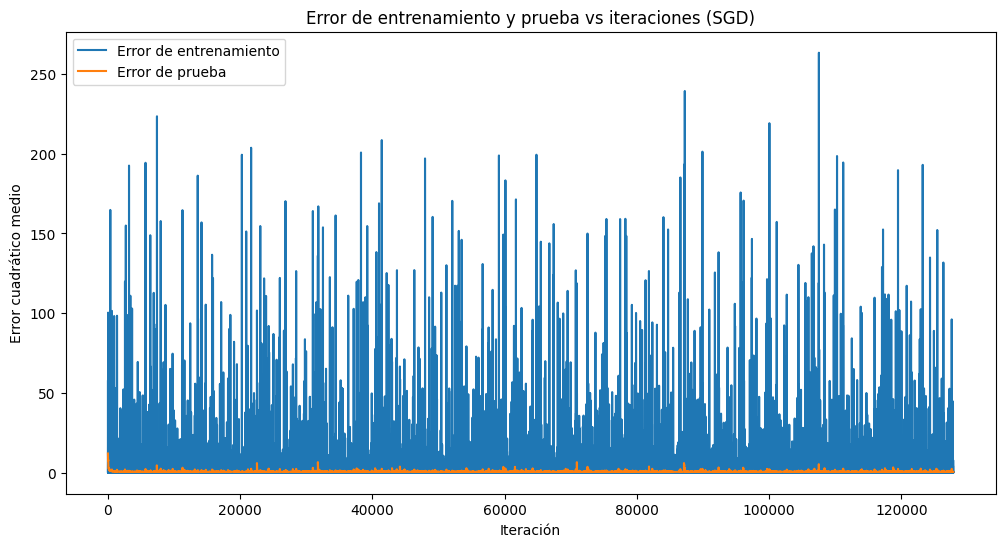

array([[-0.07186],
       [-0.19031],
       [ 0.08038],
       [ 0.0446 ],
       [-0.15807],
       [ 0.22111],
       [ 0.02549],
       [-0.02096],
       [-0.05863],
       [ 0.38795],
       [ 0.05671],
       [-0.06501],
       [ 0.07304],
       [ 0.32066],
       [-0.09543],
       [ 0.11385],
       [-0.02256],
       [-0.01939],
       [-0.1123 ],
       [-0.00398],
       [ 0.07333],
       [-0.00685],
       [ 0.07487],
       [ 0.05971],
       [-0.06137],
       [ 0.09268],
       [ 0.01694]])

In [ ]:
coeficientes_gde_04, mse_train, mse_test = stochastic_gradient_descent(X_train_z, y_train, X_test_z, y_test, epochs=10, lr=0.005)
coeficientes_gde_04

In [ ]:
r2_entrenamiento = r2(coeficientes_gde_04, X_train_z, y_train)
r2_prueba = r2(coeficientes_gde_04, X_test_z, y_test)
r2_ajustado_entrenamiento = r2_ajustado(X_train_z, y_train, r2_entrenamiento)
r2_ajustado_prueba = r2_ajustado(X_test_z, y_test, r2_prueba)
datos_gde_04 = np.insert(coeficientes_gde_04, len(coeficientes_gde_04), [r2_ajustado_entrenamiento, r2_ajustado_prueba, mse_train, mse_test])
coeficientes_gde['GD(epochs=10, lr=0.005)'] = datos_gde_04
coeficientes_gde

Regresion_lineal  GD(epochs=100, lr=0.01)  \
Intercept                         -0.005470                -0.195770   
MinTemp                           -0.140960                -0.022280   
Rainfall                           0.170280                 0.113360   
Evaporation                        0.009310                 0.020920   
Sunshine                          -0.150560                -0.406020   
WindGustSpeed                      0.238050                 0.258440   
WindSpeed9am                      -0.017460                 0.170360   
WindSpeed3pm                      -0.095610                 0.217070   
Humidity9am                       -0.033530                -0.029730   
Humidity3pm                        0.389870                 0.373050   
Pressure9am                       -0.010920                 0.029470   
Cloud9am                          -0.049110                 0.089060   
Cloud3pm                           0.022410                 0.095460   
Temp3pm                            0.251610                 0.064750   
RainToday                          0.011690                 0.114990   
WindGustDir_Este                   0.065270                -0.033290   
WindGustDir_Norte                 -0.060680                -0.047680   
WindGustDir_Oeste                 -0.040400                -0.079660   
WindDir3pm_Este                    0.010410                -0.012750   
WindDir3pm_Norte                   0.030410                -0.016040   
WindDir3pm_Oeste                   0.087360                -0.008780   
WindDir9am_Este                    0.054840                 0.060790   
WindDir9am_Norte                  -0.055840                -0.009980   
WindDir9am_Oeste                  -0.025690                -0.216820   
Estacion_Invierno                  0.029980                 0.126250   
Estacion_Otoño                     0.037980                 0.147300   
Estacion_Primavera                 0.050610                 0.033700   
r2_ajustado_entrenamiento          0.220000                -0.340000   
r2_ajustado_prueba                 0.220000                -0.680000   
mse_train                          0.780802                42.037500   
mse_test                           0.510717                 1.114197   

                           GD(epochs=500, lr=0.01)  GD(epochs=10, lr=0.1)  \
Intercept                                -0.040170              -0.094480   
MinTemp                                  -0.185550              -0.123840   
Rainfall                                 -0.075520               0.070040   
Evaporation                              -0.054190              -0.004620   
Sunshine                                 -0.102310              -0.086770   
WindGustSpeed                             0.270720               0.258650   
WindSpeed9am                             -0.006280              -0.023110   
WindSpeed3pm                             -0.072660               0.044790   
Humidity9am                              -0.042500              -0.008710   
Humidity3pm                               0.246320               0.188060   
Pressure9am                              -0.115750               0.039560   
Cloud9am                                 -0.027730               0.092210   
Cloud3pm                                  0.062860               0.048200   
Temp3pm                                   0.321400               0.216340   
RainToday                                 0.011360               0.095320   
WindGustDir_Este                          0.132270               0.168350   
WindGustDir_Norte                        -0.098780              -0.051770   
WindGustDir_Oeste                         0.024770               0.003590   
WindDir3pm_Este                           0.040780              -0.103680   
WindDir3pm_Norte                          0.009290               0.002090   
WindDir3pm_Oeste                          0.063360              -0.003550   
WindDir9am_Este             

No es un buen resultado tampoco.

#### Modelo GDE: (epochs=20, lr=0.005)

Epoca: 1
Epoca: 2
Epoca: 3
Epoca: 4
Epoca: 5
Epoca: 6
Epoca: 7
Epoca: 8
Epoca: 9
Epoca: 10
Epoca: 11
Epoca: 12
Epoca: 13
Epoca: 14
Epoca: 15
Epoca: 16
Epoca: 17
Epoca: 18
Epoca: 19
Epoca: 20


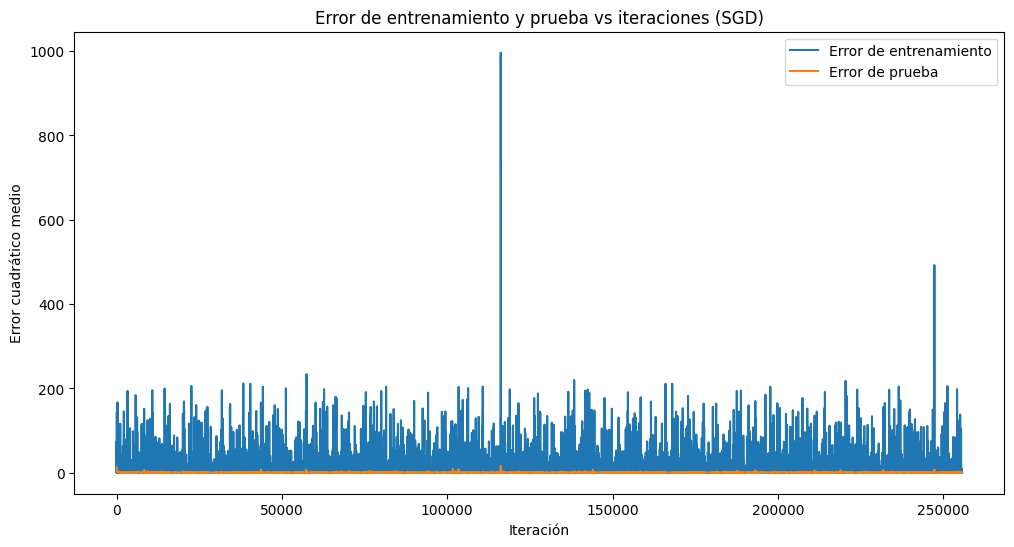

array([[-0.03273],
       [-0.13781],
       [ 0.1333 ],
       [-0.02173],
       [-0.13507],
       [ 0.26655],
       [-0.09289],
       [-0.11924],
       [-0.02858],
       [ 0.22531],
       [-0.02162],
       [-0.07892],
       [-0.03438],
       [ 0.19888],
       [-0.05034],
       [ 0.02414],
       [-0.12287],
       [ 0.00566],
       [-0.02841],
       [ 0.03759],
       [-0.02219],
       [-0.03577],
       [-0.07149],
       [-0.01969],
       [-0.06673],
       [-0.02464],
       [-0.03433]])

In [ ]:
coeficientes_gde_05, mse_train, mse_test = stochastic_gradient_descent(X_train_z, y_train, X_test_z, y_test, epochs=20, lr=0.005)
coeficientes_gde_05

In [ ]:
r2_entrenamiento = r2(coeficientes_gde_05, X_train_z, y_train)
r2_prueba = r2(coeficientes_gde_05, X_test_z, y_test)
r2_ajustado_entrenamiento = r2_ajustado(X_train_z, y_train, r2_entrenamiento)
r2_ajustado_prueba = r2_ajustado(X_test_z, y_test, r2_prueba)
datos_gde_05 = np.insert(coeficientes_gde_05, len(coeficientes_gde_05), [r2_ajustado_entrenamiento, r2_ajustado_prueba, mse_train, mse_test])
coeficientes_gde['GD(epochs=20, lr=0.005)'] = datos_gde_05
coeficientes_gde

Regresion_lineal  GD(epochs=100, lr=0.01)  \
Intercept                         -0.005470                -0.195770   
MinTemp                           -0.140960                -0.022280   
Rainfall                           0.170280                 0.113360   
Evaporation                        0.009310                 0.020920   
Sunshine                          -0.150560                -0.406020   
WindGustSpeed                      0.238050                 0.258440   
WindSpeed9am                      -0.017460                 0.170360   
WindSpeed3pm                      -0.095610                 0.217070   
Humidity9am                       -0.033530                -0.029730   
Humidity3pm                        0.389870                 0.373050   
Pressure9am                       -0.010920                 0.029470   
Cloud9am                          -0.049110                 0.089060   
Cloud3pm                           0.022410                 0.095460   
Temp3pm                            0.251610                 0.064750   
RainToday                          0.011690                 0.114990   
WindGustDir_Este                   0.065270                -0.033290   
WindGustDir_Norte                 -0.060680                -0.047680   
WindGustDir_Oeste                 -0.040400                -0.079660   
WindDir3pm_Este                    0.010410                -0.012750   
WindDir3pm_Norte                   0.030410                -0.016040   
WindDir3pm_Oeste                   0.087360                -0.008780   
WindDir9am_Este                    0.054840                 0.060790   
WindDir9am_Norte                  -0.055840                -0.009980   
WindDir9am_Oeste                  -0.025690                -0.216820   
Estacion_Invierno                  0.029980                 0.126250   
Estacion_Otoño                     0.037980                 0.147300   
Estacion_Primavera                 0.050610                 0.033700   
r2_ajustado_entrenamiento          0.220000                -0.340000   
r2_ajustado_prueba                 0.220000                -0.680000   
mse_train                          0.780802                42.037500   
mse_test                           0.510717                 1.114197   

                           GD(epochs=500, lr=0.01)  GD(epochs=10, lr=0.1)  \
Intercept                                -0.040170              -0.094480   
MinTemp                                  -0.185550              -0.123840   
Rainfall                                 -0.075520               0.070040   
Evaporation                              -0.054190              -0.004620   
Sunshine                                 -0.102310              -0.086770   
WindGustSpeed                             0.270720               0.258650   
WindSpeed9am                             -0.006280              -0.023110   
WindSpeed3pm                             -0.072660               0.044790   
Humidity9am                              -0.042500              -0.008710   
Humidity3pm                               0.246320               0.188060   
Pressure9am                              -0.115750               0.039560   
Cloud9am                                 -0.027730               0.092210   
Cloud3pm                                  0.062860               0.048200   
Temp3pm                                   0.321400               0.216340   
RainToday                                 0.011360               0.095320   
WindGustDir_Este                          0.132270               0.168350   
WindGustDir_Norte                        -0.098780              -0.051770   
WindGustDir_Oeste                         0.024770               0.003590   
WindDir3pm_Este                           0.040780              -0.103680   
WindDir3pm_Norte                          0.009290               0.002090   
WindDir3pm_Oeste                          0.063360              -0.003550   
WindDir9am_Este             

Nuevamente resultados peores a la regresion lineal

#### Modelo GDE: (epochs=50, lr=0.00001)

Epoca: 1
Epoca: 2
Epoca: 3
Epoca: 4
Epoca: 5
Epoca: 6
Epoca: 7
Epoca: 8
Epoca: 9
Epoca: 10
Epoca: 11
Epoca: 12
Epoca: 13
Epoca: 14
Epoca: 15
Epoca: 16
Epoca: 17
Epoca: 18
Epoca: 19
Epoca: 20
Epoca: 21
Epoca: 22
Epoca: 23
Epoca: 24
Epoca: 25
Epoca: 26
Epoca: 27
Epoca: 28
Epoca: 29
Epoca: 30
Epoca: 31
Epoca: 32
Epoca: 33
Epoca: 34
Epoca: 35
Epoca: 36
Epoca: 37
Epoca: 38
Epoca: 39
Epoca: 40
Epoca: 41
Epoca: 42
Epoca: 43
Epoca: 44
Epoca: 45
Epoca: 46
Epoca: 47
Epoca: 48
Epoca: 49
Epoca: 50


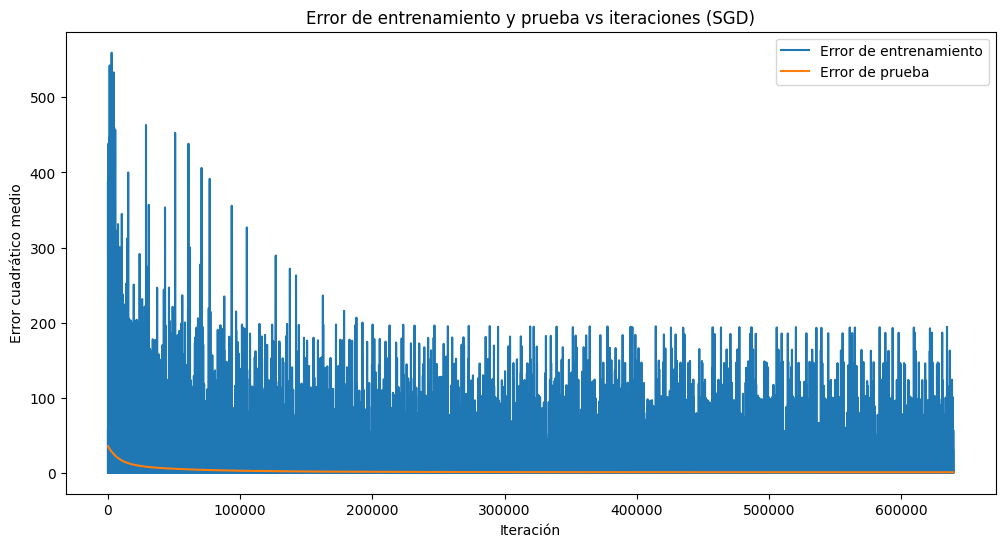

array([[ 0.25584],
       [-0.18508],
       [ 0.15708],
       [ 0.0017 ],
       [-0.24519],
       [ 0.25769],
       [ 0.00581],
       [-0.13378],
       [-0.02349],
       [ 0.4072 ],
       [ 0.00955],
       [-0.10179],
       [-0.01632],
       [ 0.24064],
       [ 0.01002],
       [ 0.19959],
       [-0.34807],
       [-0.36004],
       [ 0.1649 ],
       [ 0.49546],
       [ 0.46898],
       [-0.91597],
       [-0.20135],
       [-0.03075],
       [-0.32623],
       [-0.32967],
       [-0.05611]])

In [ ]:
coeficientes_gde_06, mse_train, mse_test = stochastic_gradient_descent(X_train_z, y_train, X_test_z, y_test, epochs=50, lr=0.00001)
coeficientes_gde_06

In [ ]:
r2_entrenamiento = r2(coeficientes_gde_06, X_train_z, y_train)
r2_prueba = r2(coeficientes_gde_06, X_test_z, y_test)
r2_ajustado_entrenamiento = r2_ajustado(X_train_z, y_train, r2_entrenamiento)
r2_ajustado_prueba = r2_ajustado(X_test_z, y_test, r2_prueba)
datos_gde_06 = np.insert(coeficientes_gde_06, len(coeficientes_gde_06), [r2_ajustado_entrenamiento, r2_ajustado_prueba, mse_train, mse_test])
coeficientes_gde['GD(epochs=50, lr=0.00001)'] = datos_gde_06
coeficientes_gde

Regresion_lineal  GD(epochs=100, lr=0.01)  \
Intercept                         -0.005470                -0.195770   
MinTemp                           -0.140960                -0.022280   
Rainfall                           0.170280                 0.113360   
Evaporation                        0.009310                 0.020920   
Sunshine                          -0.150560                -0.406020   
WindGustSpeed                      0.238050                 0.258440   
WindSpeed9am                      -0.017460                 0.170360   
WindSpeed3pm                      -0.095610                 0.217070   
Humidity9am                       -0.033530                -0.029730   
Humidity3pm                        0.389870                 0.373050   
Pressure9am                       -0.010920                 0.029470   
Cloud9am                          -0.049110                 0.089060   
Cloud3pm                           0.022410                 0.095460   
Temp3pm                            0.251610                 0.064750   
RainToday                          0.011690                 0.114990   
WindGustDir_Este                   0.065270                -0.033290   
WindGustDir_Norte                 -0.060680                -0.047680   
WindGustDir_Oeste                 -0.040400                -0.079660   
WindDir3pm_Este                    0.010410                -0.012750   
WindDir3pm_Norte                   0.030410                -0.016040   
WindDir3pm_Oeste                   0.087360                -0.008780   
WindDir9am_Este                    0.054840                 0.060790   
WindDir9am_Norte                  -0.055840                -0.009980   
WindDir9am_Oeste                  -0.025690                -0.216820   
Estacion_Invierno                  0.029980                 0.126250   
Estacion_Otoño                     0.037980                 0.147300   
Estacion_Primavera                 0.050610                 0.033700   
r2_ajustado_entrenamiento          0.220000                -0.340000   
r2_ajustado_prueba                 0.220000                -0.680000   
mse_train                          0.780802                42.037500   
mse_test                           0.510717                 1.114197   

                           GD(epochs=500, lr=0.01)  GD(epochs=10, lr=0.1)  \
Intercept                                -0.040170              -0.094480   
MinTemp                                  -0.185550              -0.123840   
Rainfall                                 -0.075520               0.070040   
Evaporation                              -0.054190              -0.004620   
Sunshine                                 -0.102310              -0.086770   
WindGustSpeed                             0.270720               0.258650   
WindSpeed9am                             -0.006280              -0.023110   
WindSpeed3pm                             -0.072660               0.044790   
Humidity9am                              -0.042500              -0.008710   
Humidity3pm                               0.246320               0.188060   
Pressure9am                              -0.115750               0.039560   
Cloud9am                                 -0.027730               0.092210   
Cloud3pm                                  0.062860               0.048200   
Temp3pm                                   0.321400               0.216340   
RainToday                                 0.011360               0.095320   
WindGustDir_Este                          0.132270               0.168350   
WindGustDir_Norte                        -0.098780              -0.051770   
WindGustDir_Oeste                         0.024770               0.003590   
WindDir3pm_Este                           0.040780              -0.103680   
WindDir3pm_Norte                          0.009290               0.002090   
WindDir3pm_Oeste                          0.063360              -0.003550   
WindDir9am_Este             

Nuevamente resultados bastante peores a los de la regresion lineal.

### Conclusiones GDE:

* Se intento dar con distintas configuraciones de hiperparametros de modo manual con el fin de acercarnos a los mismos resultados de la regresion lineal.

* Evidentemente probar de manera manual los hiperparametros al menos para nuestro conjunto de datos y obtener resultados buenos en tan poco tiempo no es sencillo.

* En definitiva, se prefiere la regresion lineal y luego el GD comun ya que son mas rapidos y en el caso de GD fue mas facil dar con los hiperparametros correctos.

## Gradiente Descendente Mini Batch:

### Funcion de optimizacion:

In [ ]:
def mini_batch_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100, batch_size=11):
    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    y_train = y_train.values

    for i in range(epochs):
        print(f'Epoca: {i+1}')
        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]

        for j in range(0, n, batch_size):
            # Obtener un lote (mini-batch) de datos
            x_batch = X_train[j:j+batch_size, :]
            y_batch = y_train[j:j+batch_size].reshape(-1, 1)

            prediction = np.matmul(x_batch, W)
            error = y_batch - prediction
            train_mse = np.mean(error ** 2)
            train_errors.append(train_mse)

            gradient = -2 * np.matmul(x_batch.T, error) / batch_size

            W = W - (lr * gradient)

            prediction_test = np.matmul(X_test, W)

            error_test = y_test.values.ravel() - prediction_test.ravel()

            test_mse = np.mean(error_test ** 2)

            test_errors.append(test_mse)

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (Mini-Batch GD)')
    plt.show()

    return np.round(W, 5), train_errors[-1], test_errors[-1]

In [ ]:
coeficientes_gdmb = coeficientes_prediccion.copy()

### Modelos:

#### Modelo: (lr=0.01, epochs=100, batch_size=1278)

Epoca: 1
Epoca: 2
Epoca: 3
Epoca: 4
Epoca: 5
Epoca: 6
Epoca: 7
Epoca: 8
Epoca: 9
Epoca: 10
Epoca: 11
Epoca: 12
Epoca: 13
Epoca: 14
Epoca: 15
Epoca: 16
Epoca: 17
Epoca: 18
Epoca: 19
Epoca: 20
Epoca: 21
Epoca: 22
Epoca: 23
Epoca: 24
Epoca: 25
Epoca: 26
Epoca: 27
Epoca: 28
Epoca: 29
Epoca: 30
Epoca: 31
Epoca: 32
Epoca: 33
Epoca: 34
Epoca: 35
Epoca: 36
Epoca: 37
Epoca: 38
Epoca: 39
Epoca: 40
Epoca: 41
Epoca: 42
Epoca: 43
Epoca: 44
Epoca: 45
Epoca: 46
Epoca: 47
Epoca: 48
Epoca: 49
Epoca: 50
Epoca: 51
Epoca: 52
Epoca: 53
Epoca: 54
Epoca: 55
Epoca: 56
Epoca: 57
Epoca: 58
Epoca: 59
Epoca: 60
Epoca: 61
Epoca: 62
Epoca: 63
Epoca: 64
Epoca: 65
Epoca: 66
Epoca: 67
Epoca: 68
Epoca: 69
Epoca: 70
Epoca: 71
Epoca: 72
Epoca: 73
Epoca: 74
Epoca: 75
Epoca: 76
Epoca: 77
Epoca: 78
Epoca: 79
Epoca: 80
Epoca: 81
Epoca: 82
Epoca: 83
Epoca: 84
Epoca: 85
Epoca: 86
Epoca: 87
Epoca: 88
Epoca: 89
Epoca: 90
Epoca: 91
Epoca: 92
Epoca: 93
Epoca: 94
Epoca: 95
Epoca: 96
Epoca: 97
Epoca: 98
Epoca: 99
Epoca: 100


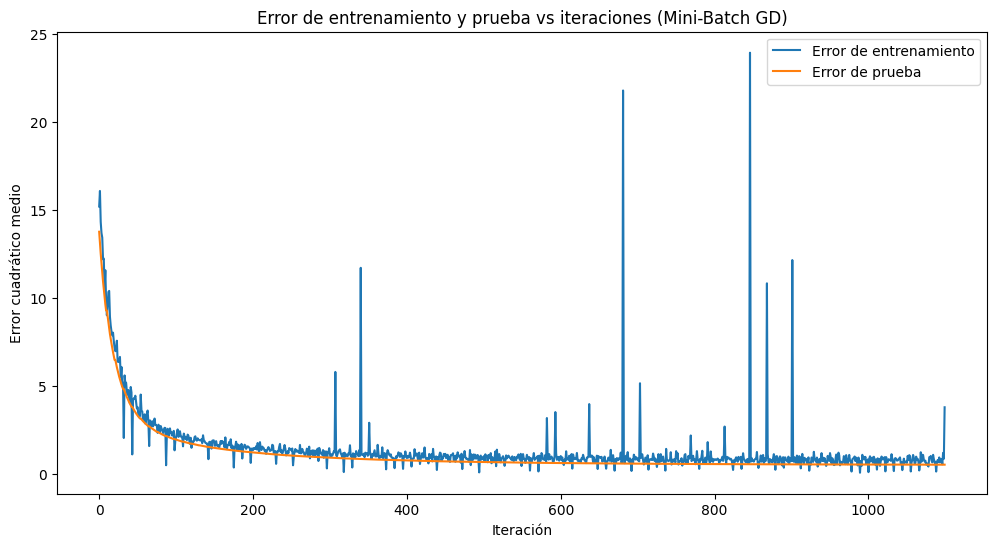

array([[-0.03303],
       [-0.20934],
       [ 0.16807],
       [ 0.00676],
       [-0.14829],
       [ 0.23062],
       [-0.00696],
       [-0.08228],
       [-0.05224],
       [ 0.43802],
       [-0.02273],
       [-0.04089],
       [ 0.01384],
       [ 0.32217],
       [ 0.02235],
       [ 0.01118],
       [ 0.01562],
       [ 0.25467],
       [-0.08885],
       [-0.05879],
       [-0.16965],
       [ 0.62158],
       [-0.06192],
       [-0.05363],
       [ 0.05098],
       [ 0.08256],
       [ 0.02886]])

In [ ]:
coeficientes_gdmb_01, mse_train, mse_test = mini_batch_gradient_descent(X_train_z, y_train, X_test_z, y_test, lr=0.01, epochs=100, batch_size=1278)
coeficientes_gdmb_01

In [ ]:
r2_entrenamiento = r2(coeficientes_gdmb_01, X_train_z, y_train)
r2_prueba = r2(coeficientes_gdmb_01, X_test_z, y_test)
r2_ajustado_entrenamiento = r2_ajustado(X_train_z, y_train, r2_entrenamiento)
r2_ajustado_prueba = r2_ajustado(X_test_z, y_test, r2_prueba)
datos_gdmb_01 = np.insert(coeficientes_gdmb_01, len(coeficientes_gdmb_01), [r2_ajustado_entrenamiento, r2_ajustado_prueba, mse_train, mse_test])
coeficientes_gdmb['GDMB(epochs=100,lr=0.01,b_s=1278)'] = datos_gdmb_01
coeficientes_gdmb

Regresion_lineal  GDMB(epochs=100,lr=0.01,b_s=1278)
Intercept                         -0.005470                          -0.033030
MinTemp                           -0.140960                          -0.209340
Rainfall                           0.170280                           0.168070
Evaporation                        0.009310                           0.006760
Sunshine                          -0.150560                          -0.148290
WindGustSpeed                      0.238050                           0.230620
WindSpeed9am                      -0.017460                          -0.006960
WindSpeed3pm                      -0.095610                          -0.082280
Humidity9am                       -0.033530                          -0.052240
Humidity3pm                        0.389870                           0.438020
Pressure9am                       -0.010920                          -0.022730
Cloud9am                          -0.049110                          -0.040890
Cloud3pm                           0.022410                           0.013840
Temp3pm                            0.251610                           0.322170
RainToday                          0.011690                           0.022350
WindGustDir_Este                   0.065270                           0.011180
WindGustDir_Norte                 -0.060680                           0.015620
WindGustDir_Oeste                 -0.040400                           0.254670
WindDir3pm_Este                    0.010410                          -0.088850
WindDir3pm_Norte                   0.030410                          -0.058790
WindDir3pm_Oeste                   0.087360                          -0.169650
WindDir9am_Este                    0.054840                           0.621580
WindDir9am_Norte                  -0.055840                          -0.061920
WindDir9am_Oeste                  -0.025690                          -0.053630
Estacion_Invierno                  0.029980                           0.050980
Estacion_Otoño                     0.037980                           0.082560
Estacion_Primavera                 0.050610                           0.028860
r2_ajustado_entrenamiento          0.220000                           0.190000
r2_ajustado_prueba                 0.220000                           0.180000
mse_train                          0.780802                           3.800436
mse_test                           0.510717                           0.537052

En cuanto a r2 ajustado resultados mas o menos cercanos, las metricas de mse no se parecen.
Y los coeficientes tampoco, vamos a probar subiendole las epocas.

#### Modelo: (lr=0.01, epochs=500, batch_size=1278)

Epoca: 1
Epoca: 2
Epoca: 3
Epoca: 4
Epoca: 5
Epoca: 6
Epoca: 7
Epoca: 8
Epoca: 9
Epoca: 10
Epoca: 11
Epoca: 12
Epoca: 13
Epoca: 14
Epoca: 15
Epoca: 16
Epoca: 17
Epoca: 18
Epoca: 19
Epoca: 20
Epoca: 21
Epoca: 22
Epoca: 23
Epoca: 24
Epoca: 25
Epoca: 26
Epoca: 27
Epoca: 28
Epoca: 29
Epoca: 30
Epoca: 31
Epoca: 32
Epoca: 33
Epoca: 34
Epoca: 35
Epoca: 36
Epoca: 37
Epoca: 38
Epoca: 39
Epoca: 40
Epoca: 41
Epoca: 42
Epoca: 43
Epoca: 44
Epoca: 45
Epoca: 46
Epoca: 47
Epoca: 48
Epoca: 49
Epoca: 50
Epoca: 51
Epoca: 52
Epoca: 53
Epoca: 54
Epoca: 55
Epoca: 56
Epoca: 57
Epoca: 58
Epoca: 59
Epoca: 60
Epoca: 61
Epoca: 62
Epoca: 63
Epoca: 64
Epoca: 65
Epoca: 66
Epoca: 67
Epoca: 68
Epoca: 69
Epoca: 70
Epoca: 71
Epoca: 72
Epoca: 73
Epoca: 74
Epoca: 75
Epoca: 76
Epoca: 77
Epoca: 78
Epoca: 79
Epoca: 80
Epoca: 81
Epoca: 82
Epoca: 83
Epoca: 84
Epoca: 85
Epoca: 86
Epoca: 87
Epoca: 88
Epoca: 89
Epoca: 90
Epoca: 91
Epoca: 92
Epoca: 93
Epoca: 94
Epoca: 95
Epoca: 96
Epoca: 97
Epoca: 98
Epoca: 99
Epoca: 100
Epoca: 1

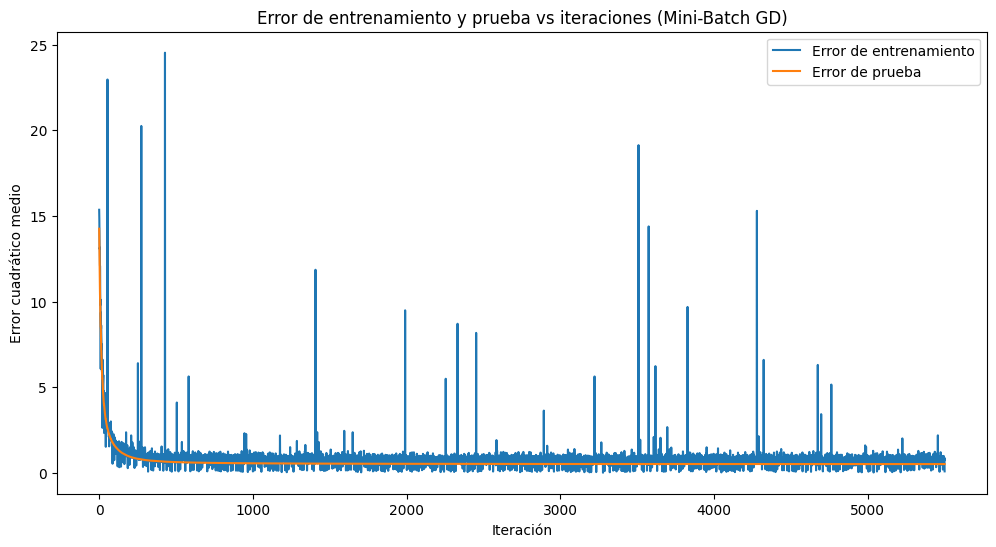

array([[ 0.01246],
       [-0.14144],
       [ 0.17063],
       [ 0.00829],
       [-0.15216],
       [ 0.23739],
       [-0.01649],
       [-0.09708],
       [-0.03549],
       [ 0.38919],
       [-0.00879],
       [-0.04978],
       [ 0.02213],
       [ 0.2446 ],
       [ 0.0119 ],
       [ 0.01247],
       [-0.09984],
       [-0.07968],
       [ 0.05697],
       [ 0.07723],
       [ 0.13314],
       [ 0.0407 ],
       [-0.05703],
       [-0.02701],
       [ 0.00084],
       [ 0.01437],
       [ 0.03284]])

In [ ]:
coeficientes_gdmb_02, mse_train, mse_test = mini_batch_gradient_descent(X_train_z, y_train, X_test_z, y_test, lr=0.01, epochs=500, batch_size=1278)
coeficientes_gdmb_02

In [ ]:
r2_entrenamiento = r2(coeficientes_gdmb_02, X_train_z, y_train)
r2_prueba = r2(coeficientes_gdmb_02, X_test_z, y_test)
r2_ajustado_entrenamiento = r2_ajustado(X_train_z, y_train, r2_entrenamiento)
r2_ajustado_prueba = r2_ajustado(X_test_z, y_test, r2_prueba)
datos_gdmb_02 = np.insert(coeficientes_gdmb_02, len(coeficientes_gdmb_02), [r2_ajustado_entrenamiento, r2_ajustado_prueba, mse_train, mse_test])
coeficientes_gdmb['GDMB(epochs=500,lr=0.01,b_s=1278)'] = datos_gdmb_02
coeficientes_gdmb

Regresion_lineal  \
Intercept                         -0.005470   
MinTemp                           -0.140960   
Rainfall                           0.170280   
Evaporation                        0.009310   
Sunshine                          -0.150560   
WindGustSpeed                      0.238050   
WindSpeed9am                      -0.017460   
WindSpeed3pm                      -0.095610   
Humidity9am                       -0.033530   
Humidity3pm                        0.389870   
Pressure9am                       -0.010920   
Cloud9am                          -0.049110   
Cloud3pm                           0.022410   
Temp3pm                            0.251610   
RainToday                          0.011690   
WindGustDir_Este                   0.065270   
WindGustDir_Norte                 -0.060680   
WindGustDir_Oeste                 -0.040400   
WindDir3pm_Este                    0.010410   
WindDir3pm_Norte                   0.030410   
WindDir3pm_Oeste                   0.087360   
WindDir9am_Este                    0.054840   
WindDir9am_Norte                  -0.055840   
WindDir9am_Oeste                  -0.025690   
Estacion_Invierno                  0.029980   
Estacion_Otoño                     0.037980   
Estacion_Primavera                 0.050610   
r2_ajustado_entrenamiento          0.220000   
r2_ajustado_prueba                 0.220000   
mse_train                          0.780802   
mse_test                           0.510717   

                           GDMB(epochs=100,lr=0.01,b_s=1278)  \
Intercept                                          -0.033030   
MinTemp                                            -0.209340   
Rainfall                                            0.168070   
Evaporation                                         0.006760   
Sunshine                                           -0.148290   
WindGustSpeed                                       0.230620   
WindSpeed9am                                       -0.006960   
WindSpeed3pm                                       -0.082280   
Humidity9am                                        -0.052240   
Humidity3pm                                         0.438020   
Pressure9am                                        -0.022730   
Cloud9am                                           -0.040890   
Cloud3pm                                            0.013840   
Temp3pm                                             0.322170   
RainToday                                           0.022350   
WindGustDir_Este                                    0.011180   
WindGustDir_Norte                                   0.015620   
WindGustDir_Oeste                                   0.254670   
WindDir3pm_Este                                    -0.088850   
WindDir3pm_Norte                                   -0.058790   
WindDir3pm_Oeste                                   -0.169650   
WindDir9am_Este                                     0.621580   
WindDir9am_Norte                                   -0.061920   
WindDir9am_Oeste                                   -0.053630   
Estacion_Invierno                                   0.050980   
Estacion_Otoño                                      0.082560   
Estacion_Primavera                                  0.028860   
r2_ajustado_entrenamiento                           0.190000   
r2_ajustado_prueba                                  0.180000   
mse_train                                           3.800436   
mse_test                                            0.537052   

                           GDMB(epochs=500,lr=0.01,b_s=1278)  
Intercept                                           0.012460  
MinTemp                                            -0.141440  
Rainfall                                            0.170630  
Evaporation                                         0.008290  
Sunshine                                           -0.152160  
WindGustSpeed                                       0.237390  
WindSpeed9am                    

Mismo R2 ajustado y los coeficientes parecen ir acercandose, vamos a probar con mas epocas aun.

#### Modelo: (lr=0.01, epochs=1250, batch_size=1278)

Epoca: 1
Epoca: 2
Epoca: 3
Epoca: 4
Epoca: 5
Epoca: 6
Epoca: 7
Epoca: 8
Epoca: 9
Epoca: 10
Epoca: 11
Epoca: 12
Epoca: 13
Epoca: 14
Epoca: 15
Epoca: 16
Epoca: 17
Epoca: 18
Epoca: 19
Epoca: 20
Epoca: 21
Epoca: 22
Epoca: 23
Epoca: 24
Epoca: 25
Epoca: 26
Epoca: 27
Epoca: 28
Epoca: 29
Epoca: 30
Epoca: 31
Epoca: 32
Epoca: 33
Epoca: 34
Epoca: 35
Epoca: 36
Epoca: 37
Epoca: 38
Epoca: 39
Epoca: 40
Epoca: 41
Epoca: 42
Epoca: 43
Epoca: 44
Epoca: 45
Epoca: 46
Epoca: 47
Epoca: 48
Epoca: 49
Epoca: 50
Epoca: 51
Epoca: 52
Epoca: 53
Epoca: 54
Epoca: 55
Epoca: 56
Epoca: 57
Epoca: 58
Epoca: 59
Epoca: 60
Epoca: 61
Epoca: 62
Epoca: 63
Epoca: 64
Epoca: 65
Epoca: 66
Epoca: 67
Epoca: 68
Epoca: 69
Epoca: 70
Epoca: 71
Epoca: 72
Epoca: 73
Epoca: 74
Epoca: 75
Epoca: 76
Epoca: 77
Epoca: 78
Epoca: 79
Epoca: 80
Epoca: 81
Epoca: 82
Epoca: 83
Epoca: 84
Epoca: 85
Epoca: 86
Epoca: 87
Epoca: 88
Epoca: 89
Epoca: 90
Epoca: 91
Epoca: 92
Epoca: 93
Epoca: 94
Epoca: 95
Epoca: 96
Epoca: 97
Epoca: 98
Epoca: 99
Epoca: 100
Epoca: 1

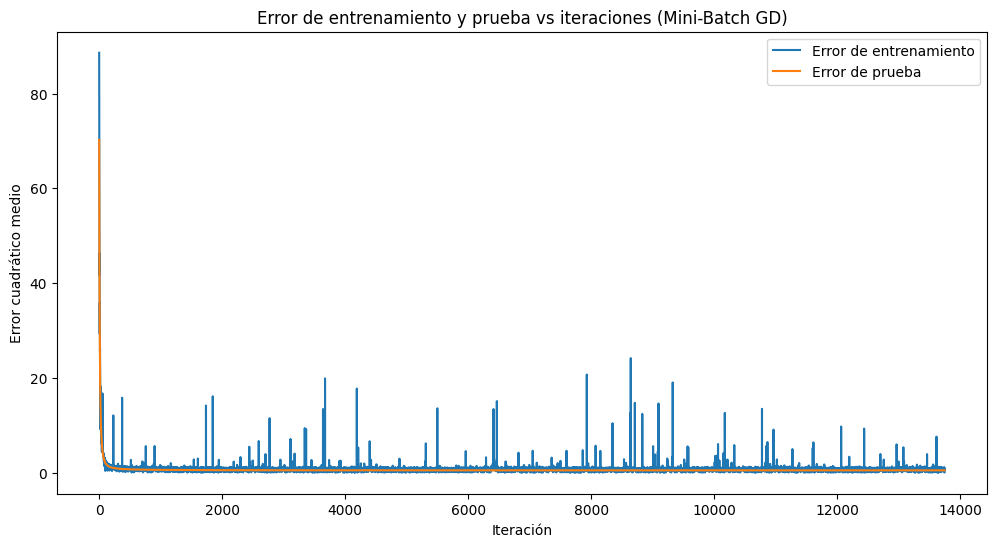

array([[-0.00463],
       [-0.14092],
       [ 0.17046],
       [ 0.0093 ],
       [-0.15069],
       [ 0.23825],
       [-0.01717],
       [-0.09529],
       [-0.03367],
       [ 0.38983],
       [-0.01095],
       [-0.04908],
       [ 0.02244],
       [ 0.25119],
       [ 0.0118 ],
       [ 0.06385],
       [-0.06165],
       [-0.04137],
       [ 0.01135],
       [ 0.03144],
       [ 0.08833],
       [ 0.05526],
       [-0.05532],
       [-0.02529],
       [ 0.02828],
       [ 0.03656],
       [ 0.04967]])

In [ ]:
coeficientes_gdmb_03, mse_train, mse_test = mini_batch_gradient_descent(X_train_z, y_train, X_test_z, y_test, lr=0.01, epochs=1250, batch_size=1278)
coeficientes_gdmb_03

In [ ]:
r2_entrenamiento = r2(coeficientes_gdmb_03, X_train_z, y_train)
r2_prueba = r2(coeficientes_gdmb_03, X_test_z, y_test)
r2_ajustado_entrenamiento = r2_ajustado(X_train_z, y_train, r2_entrenamiento)
r2_ajustado_prueba = r2_ajustado(X_test_z, y_test, r2_prueba)
datos_gdmb_03 = np.insert(coeficientes_gdmb_03, len(coeficientes_gdmb_03), [r2_ajustado_entrenamiento, r2_ajustado_prueba, mse_train, mse_test])
coeficientes_gdmb['GDMB(epochs=1250,lr=0.01,b_s=1278)'] = datos_gdmb_03
coeficientes_gdmb

Regresion_lineal  \
Intercept                         -0.005470   
MinTemp                           -0.140960   
Rainfall                           0.170280   
Evaporation                        0.009310   
Sunshine                          -0.150560   
WindGustSpeed                      0.238050   
WindSpeed9am                      -0.017460   
WindSpeed3pm                      -0.095610   
Humidity9am                       -0.033530   
Humidity3pm                        0.389870   
Pressure9am                       -0.010920   
Cloud9am                          -0.049110   
Cloud3pm                           0.022410   
Temp3pm                            0.251610   
RainToday                          0.011690   
WindGustDir_Este                   0.065270   
WindGustDir_Norte                 -0.060680   
WindGustDir_Oeste                 -0.040400   
WindDir3pm_Este                    0.010410   
WindDir3pm_Norte                   0.030410   
WindDir3pm_Oeste                   0.087360   
WindDir9am_Este                    0.054840   
WindDir9am_Norte                  -0.055840   
WindDir9am_Oeste                  -0.025690   
Estacion_Invierno                  0.029980   
Estacion_Otoño                     0.037980   
Estacion_Primavera                 0.050610   
r2_ajustado_entrenamiento          0.220000   
r2_ajustado_prueba                 0.220000   
mse_train                          0.780802   
mse_test                           0.510717   

                           GDMB(epochs=100,lr=0.01,b_s=1278)  \
Intercept                                          -0.033030   
MinTemp                                            -0.209340   
Rainfall                                            0.168070   
Evaporation                                         0.006760   
Sunshine                                           -0.148290   
WindGustSpeed                                       0.230620   
WindSpeed9am                                       -0.006960   
WindSpeed3pm                                       -0.082280   
Humidity9am                                        -0.052240   
Humidity3pm                                         0.438020   
Pressure9am                                        -0.022730   
Cloud9am                                           -0.040890   
Cloud3pm                                            0.013840   
Temp3pm                                             0.322170   
RainToday                                           0.022350   
WindGustDir_Este                                    0.011180   
WindGustDir_Norte                                   0.015620   
WindGustDir_Oeste                                   0.254670   
WindDir3pm_Este                                    -0.088850   
WindDir3pm_Norte                                   -0.058790   
WindDir3pm_Oeste                                   -0.169650   
WindDir9am_Este                                     0.621580   
WindDir9am_Norte                                   -0.061920   
WindDir9am_Oeste                                   -0.053630   
Estacion_Invierno                                   0.050980   
Estacion_Otoño                                      0.082560   
Estacion_Primavera                                  0.028860   
r2_ajustado_entrenamiento                           0.190000   
r2_ajustado_prueba                                  0.180000   
mse_train                                           3.800436   
mse_test                                            0.537052   

                           GDMB(epochs=500,lr=0.01,b_s=1278)  \
Intercept                                           0.012460   
MinTemp                                            -0.141440   
Rainfall                                            0.170630   
Evaporation                                         0.008290   
Sunshine                                           -0.152160   
WindGustSpeed                                       0.237390   
WindSpeed9am             

Mismo R2 ajustado y mismos coeficientes practicamente tambien.

### Conclusion GDMB:

* Para nuestros datos y con nuestro poder de computo se lo prefiere antes que a GDE por una cuestion de mayor facilidad a la hora de escoger los hiperparametros y por una cuestion de tiempo.

# Regularizacion:

### Ridge

#### Creacion del modelo:

In [ ]:
# Creamos el modelo Ridge con optimizacion de hp alpha
ridge = RidgeCV( alphas = np.logspace(-10, 10, 200), fit_intercept = True, store_cv_values = True)

ridge = ridge.fit(X_train_z, y_train)

#### Grafico de evolucion de los parametros a lo largo de cada alpha:

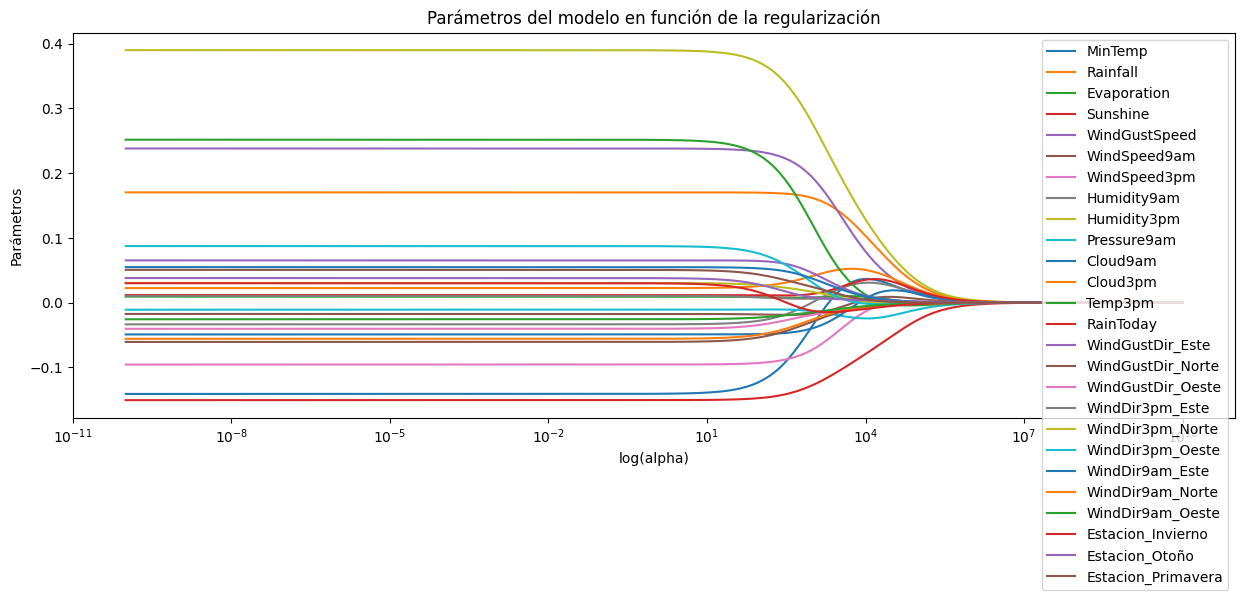

In [ ]:
# Evolución de los parámetros en función de alpha

# Obtengo los alphas que se probaron para encontrar el mejor
alphas = ridge.alphas
# Lista donde se guardaran los coeficientes de cada modelo testeado con los alphas anteriores
coefs = []

# Por cada valor de alpha
for alpha in alphas:
    # Creamos cada uno de los modelos con su respectivo alpha
    modelo_aux = Ridge(alpha=alpha)
    # Entrenamos el modelo con los datos
    modelo_aux.fit(X_train_z, y_train)
    # Guardamos los coeficientes para luego graficar
    coefs.append(modelo_aux.coef_.flatten())

# Graficamos
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(alphas, coefs, label=X_train_z.columns)
ax.set_xscale('log')
ax.set_xlabel('log(alpha)')
ax.set_ylabel('Parámetros')
ax.set_title('Parámetros del modelo en función de la regularización');
plt.axis('tight')
plt.legend()
plt.show()

#### Mejor valor de alpha luego de la validacion del hp:

In [ ]:
mejor_alpha = ridge.alpha_
print("Mejor valor de alpha:", mejor_alpha)

Mejor valor de alpha: 72.32633896483549


#### Grafico con coeficientes del modelo:

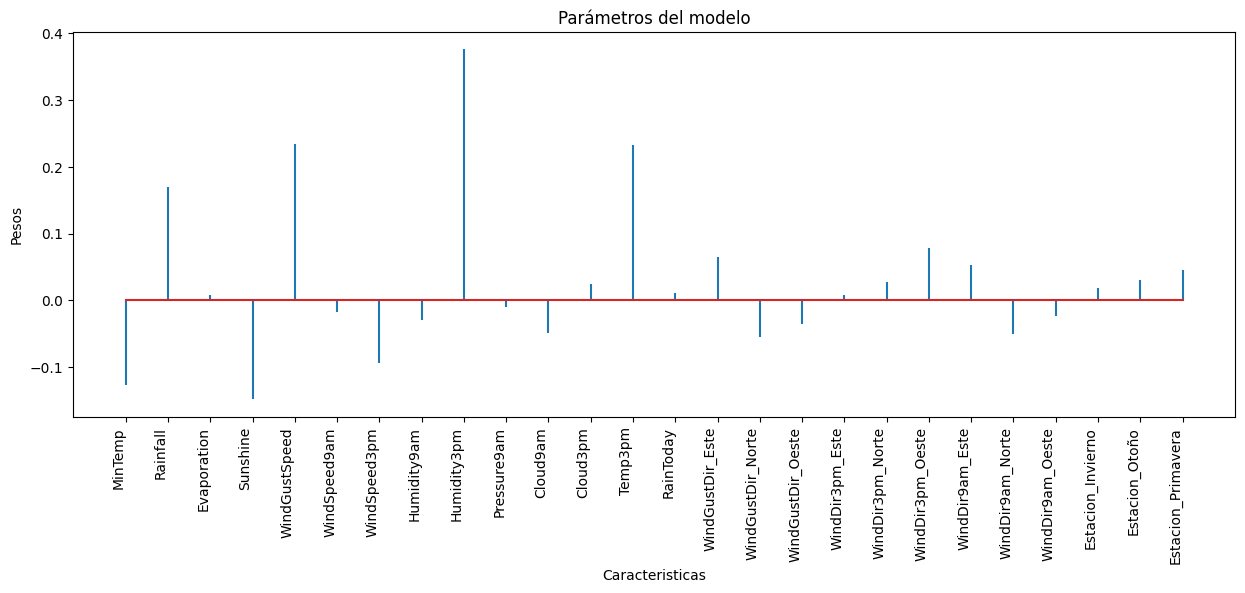

In [ ]:
# Coeficientes del modelo
coeficientes_ridge = pd.DataFrame({'predictor': X_train_z.columns,'coeficiente': ridge.coef_.flatten()})

fig, ax = plt.subplots(figsize=(15,5))
ax.stem(coeficientes_ridge.predictor, coeficientes_ridge.coeficiente, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('Caracteristicas')
ax.set_ylabel('Pesos')
ax.set_title('Parámetros del modelo');

In [ ]:
mejor_alpha

72.32633896483549

#### Grafico de la evolucion del rmse de validacion en funcion del alpha:

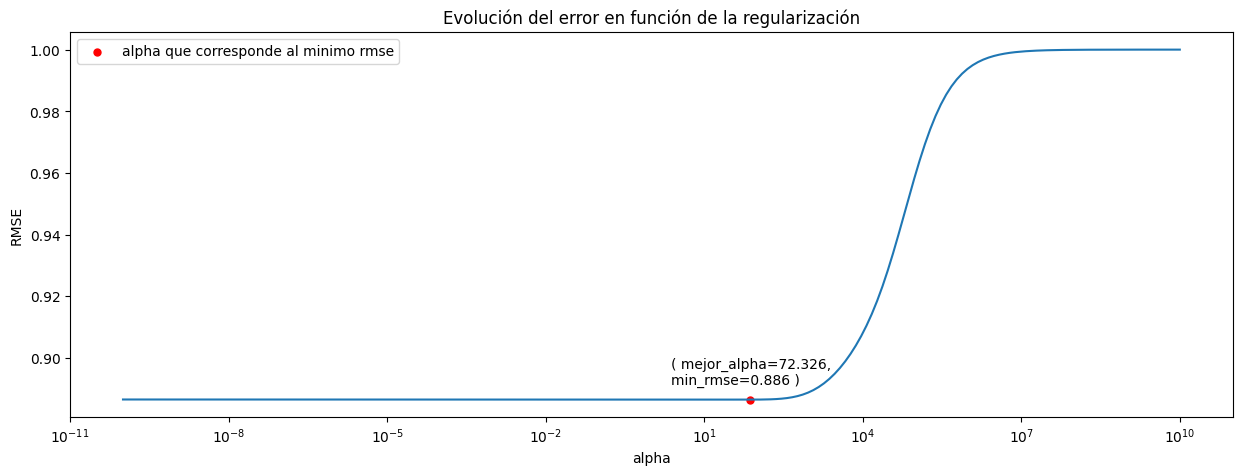

In [ ]:
# Evolución del error de validación cruzada en función de alpha

# .cv_values guarda el mse de cv para cada valor de alpha por cada fold

# Calculamos el promedio de los mse para cada alpha
mse_cv = ridge.cv_values_.reshape((-1, 200)).mean(axis=0)

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)

# Minimo rmse que corresponde al mejor alpha
min_rmse = np.min(rmse_cv)

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(alphas, rmse_cv)
ax.set_xscale('log')
# ax.set_ylim([0.85,1])
ax.set_title('Evolución del error en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
# Punto que marca donde se encuentra nuestro mejor alpha con su respecto rmse
ax.scatter(mejor_alpha, min_rmse, color='red', s=25, label='alpha que corresponde al minimo rmse')
ax.text(mejor_alpha-70, min_rmse+0.005,
        f'( mejor_alpha={round(mejor_alpha,3)},\nmin_rmse={round(min_rmse, 3)} )',
        color='black', fontsize=10)
ax.legend()

#### Predicciones

In [ ]:
# Predicciones de train:
y_pred_rtrain = ridge.predict(X_train_z)

# Predicciones de test:
y_pred_rtest = ridge.predict(X_test_z)

#### Metricas:

In [ ]:
# Calculo del Error Cuadrático Medio (MSE)
mse_train_ridge = np.min(mse_cv)
mse_test_ridge = mean_squared_error(y_test, y_pred_rtest)

# Calculo del Error Cuadrático Medio de la Raíz (RMSE)
rmse_train_ridge = min_rmse
rmse_test_ridge = np.sqrt(mse_test_ridge)

# Calculo del Error Absoluto Medio (MAE)
mae_train_ridge = mean_absolute_error(y_train, y_pred_rtrain)
mae_test_ridge = mean_absolute_error(y_test, y_pred_rtest)

# Calculo del R2:
r2_train_ridge = r2_score(y_train, y_pred_rtrain)
r2_test_ridge = r2_score(y_test, y_pred_rtest)

# Calculo del R2 Ajustado
r2_ajustado_train_r = r2_ajustado(X_train_z, y_train, r2_train_ridge)
r2_ajustado_test_r = r2_ajustado(X_test_z, y_test, r2_test_ridge)

print("---------------------------")
print(f"MSE TRAIN: {mse_train_ridge:.2f}")
print(f"MSE TEST: {mse_test_ridge:.2f}")
print("---------------------------")
print(f"RMSE TRAIN: {rmse_train_ridge:.2f}")
print(f"RMSE TEST: {rmse_test_ridge:.2f}")
print("---------------------------")
print(f"MAE TRAIN: {mae_train_ridge:.2f}")
print(f"MAE TEST: {mae_test_ridge:.2f}")
print("---------------------------")
print(f'R2 TRAIN: {r2_train_ridge:.2f}')
print(f'R2 TEST: {r2_test_ridge:.2f}')
print("---------------------------")
print(f'R2 AJUSTADO TRAIN: {r2_ajustado_train_r:.2f}')
print(f'R2 AJUSTADO TEST: {r2_ajustado_test_r:.2f}')
print("---------------------------")

---------------------------
MSE TRAIN: 0.79
MSE TEST: 0.51
---------------------------
RMSE TRAIN: 0.89
RMSE TEST: 0.71
---------------------------
MAE TRAIN: 0.42
MAE TEST: 0.39
---------------------------
R2 TRAIN: 0.22
R2 TEST: 0.23
---------------------------
R2 AJUSTADO TRAIN: 0.22
R2 AJUSTADO TEST: 0.23
---------------------------


#### Tabla para comparar metricas y coeficientes con regresion lineal

In [ ]:
coeficientes_regularizacion = coeficientes_prediccion_rl.copy()
# Guardamos en un mismo array los coeficientes y el intercepto de la regresion Ridge para meterlo en una tabla comparativa
coeficientes_ridge = np.insert(ridge.coef_, 0, ridge.intercept_)

In [ ]:
datos_ridge = np.insert(coeficientes_ridge, len(coeficientes_ridge), [r2_ajustado_train_r, r2_ajustado_test_r, mse_train_ridge, mse_test_ridge, mae_train_ridge, mae_test_ridge])
coeficientes_regularizacion[f'Ridge-alpha={round(mejor_alpha, 2)}'] = datos_ridge
round(coeficientes_regularizacion,3)

Regresion_lineal  Ridge-alpha=72.33
Intercept                            -0.005             -0.002
MinTemp                              -0.141             -0.127
Rainfall                              0.170              0.170
Evaporation                           0.009              0.009
Sunshine                             -0.151             -0.148
WindGustSpeed                         0.238              0.234
WindSpeed9am                         -0.017             -0.018
WindSpeed3pm                         -0.096             -0.094
Humidity9am                          -0.034             -0.029
Humidity3pm                           0.390              0.375
Pressure9am                          -0.011             -0.011
Cloud9am                             -0.049             -0.049
Cloud3pm                              0.022              0.025
Temp3pm                               0.252              0.233
RainToday                             0.012              0.011
WindGustDir_Este                      0.065              0.065
WindGustDir_Norte                    -0.061             -0.055
WindGustDir_Oeste                    -0.040             -0.036
WindDir3pm_Este                       0.010              0.009
WindDir3pm_Norte                      0.030              0.028
WindDir3pm_Oeste                      0.087              0.078
WindDir9am_Este                       0.055              0.053
WindDir9am_Norte                     -0.056             -0.051
WindDir9am_Oeste                     -0.026             -0.024
Estacion_Invierno                     0.030              0.019
Estacion_Otoño                        0.038              0.030
Estacion_Primavera                    0.051              0.045
r2_ajustado_entrenamiento             0.218              0.218
r2_ajustado_prueba                    0.228              0.228
mse_train                             0.781              0.786
mse_test                              0.511              0.510
mae_train                             0.425              0.423
mae_test                              0.390              0.388

* En general se puede ver que la mayoria de coeficientes disminuyeron en magnitud muy poquito comparado con la regresion

* Los R2 aj. se mantuvieron iguales que en la regresion y el MAE de test disminuyo 0.002.

### Lasso

#### Creacion del modelo:

In [ ]:
lasso = LassoCV( alphas=np.logspace(-10, 10, 200), cv=10)

lasso = lasso.fit(X_train_z, y_train)

#### Evolución de los parámetros en función de alpha:

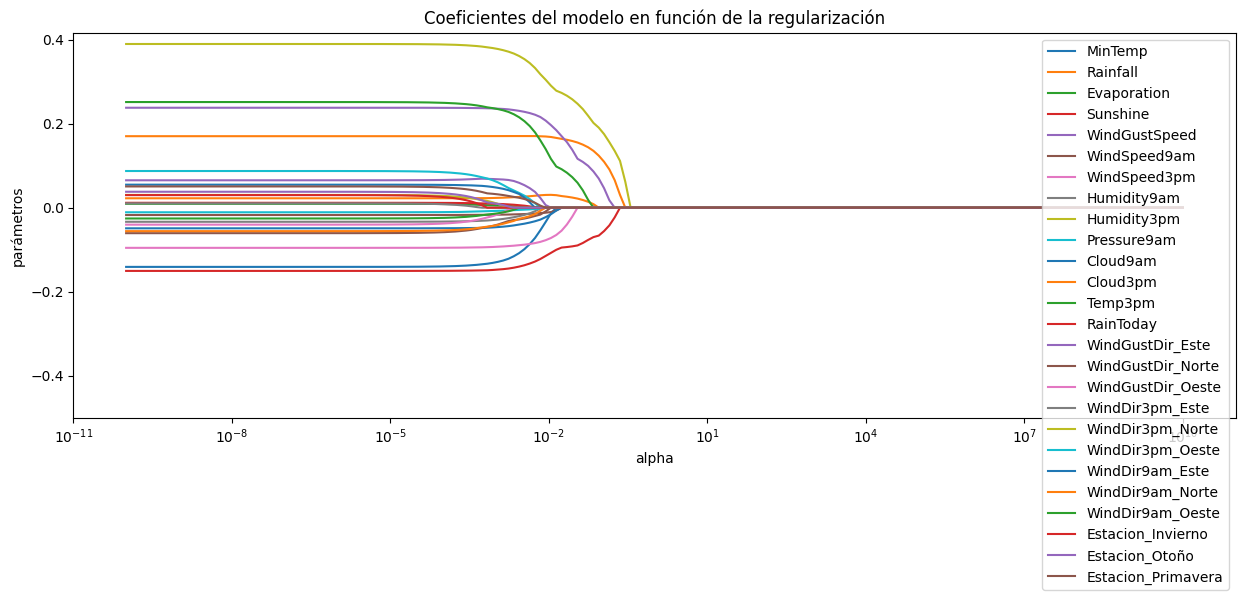

In [ ]:
# Mismo procedimiento que en Ridge:

alphas = lasso.alphas_
coefs = []

for alpha in alphas:
    modelo_aux = Lasso(alpha=alpha)
    modelo_aux.fit(X_train_z, y_train)
    coefs.append(modelo_aux.coef_.flatten())

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(alphas, coefs, label=X_train_z.columns)
ax.set_xscale('log')
ax.set_ylim([-0.5,None])
ax.set_xlabel('alpha')
ax.set_ylabel('parámetros')
ax.legend()
ax.set_title('Coeficientes del modelo en función de la regularización')
plt.show()

#### Mejor alpha encontrado:

In [ ]:
# Mejor valor alpha encontrado
mejor_alpha_lasso = lasso.alpha_
print(f"Mejor valor de alpha encontrado: {mejor_alpha_lasso}")

Mejor valor de alpha encontrado: 0.0010843659686896108


#### Grafica con cantidad de predictores

Text(0.0016265489530344164, 24.24, '( mejor_alpha_lasso=0.00108,\ncantidad_predictores_mejor_alpha=24)')

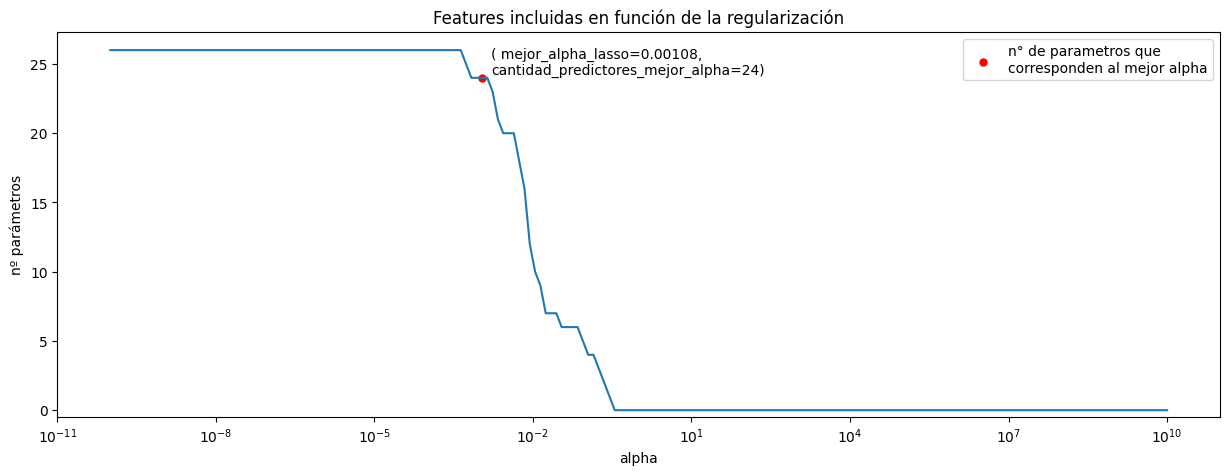

In [ ]:
# Número de features incluidas (parámetros !=0) en función de alpha
n_predictores = []

for alpha in alphas:
    modelo_aux = Lasso(alpha=alpha)
    modelo_aux.fit(X_train_z, y_train)
    coef_no_cero = np.sum(modelo_aux.coef_.flatten() != 0)
    n_predictores.append(coef_no_cero)

# Buscamos el indice que nos indica el nro de predictores para nuestro alpha
indice = np.where(alphas == mejor_alpha_lasso)[0][0]
cantidad_predictores_mejor_alpha = n_predictores[indice]

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(alphas, n_predictores)
ax.set_xscale('log')
ax.set_ylim([-0.5,None])
ax.set_xlabel('alpha')
ax.set_ylabel('nº parámetros')
ax.set_title('Features incluidas en función de la regularización')
# Punto en la grafica donde se muestra nuestro mejor alpha y la cantidad de predictores
ax.scatter(mejor_alpha_lasso, cantidad_predictores_mejor_alpha, color='red', s=25, label='n° de parametros que\ncorresponden al mejor alpha')
ax.legend()
ax.text(mejor_alpha_lasso+mejor_alpha_lasso*0.5, cantidad_predictores_mejor_alpha+cantidad_predictores_mejor_alpha*0.01,
        f'( mejor_alpha_lasso={round(mejor_alpha_lasso, 5)},\ncantidad_predictores_mejor_alpha={cantidad_predictores_mejor_alpha})',
        color='black', fontsize=10)

#### Grafico con coeficientes del modelo:

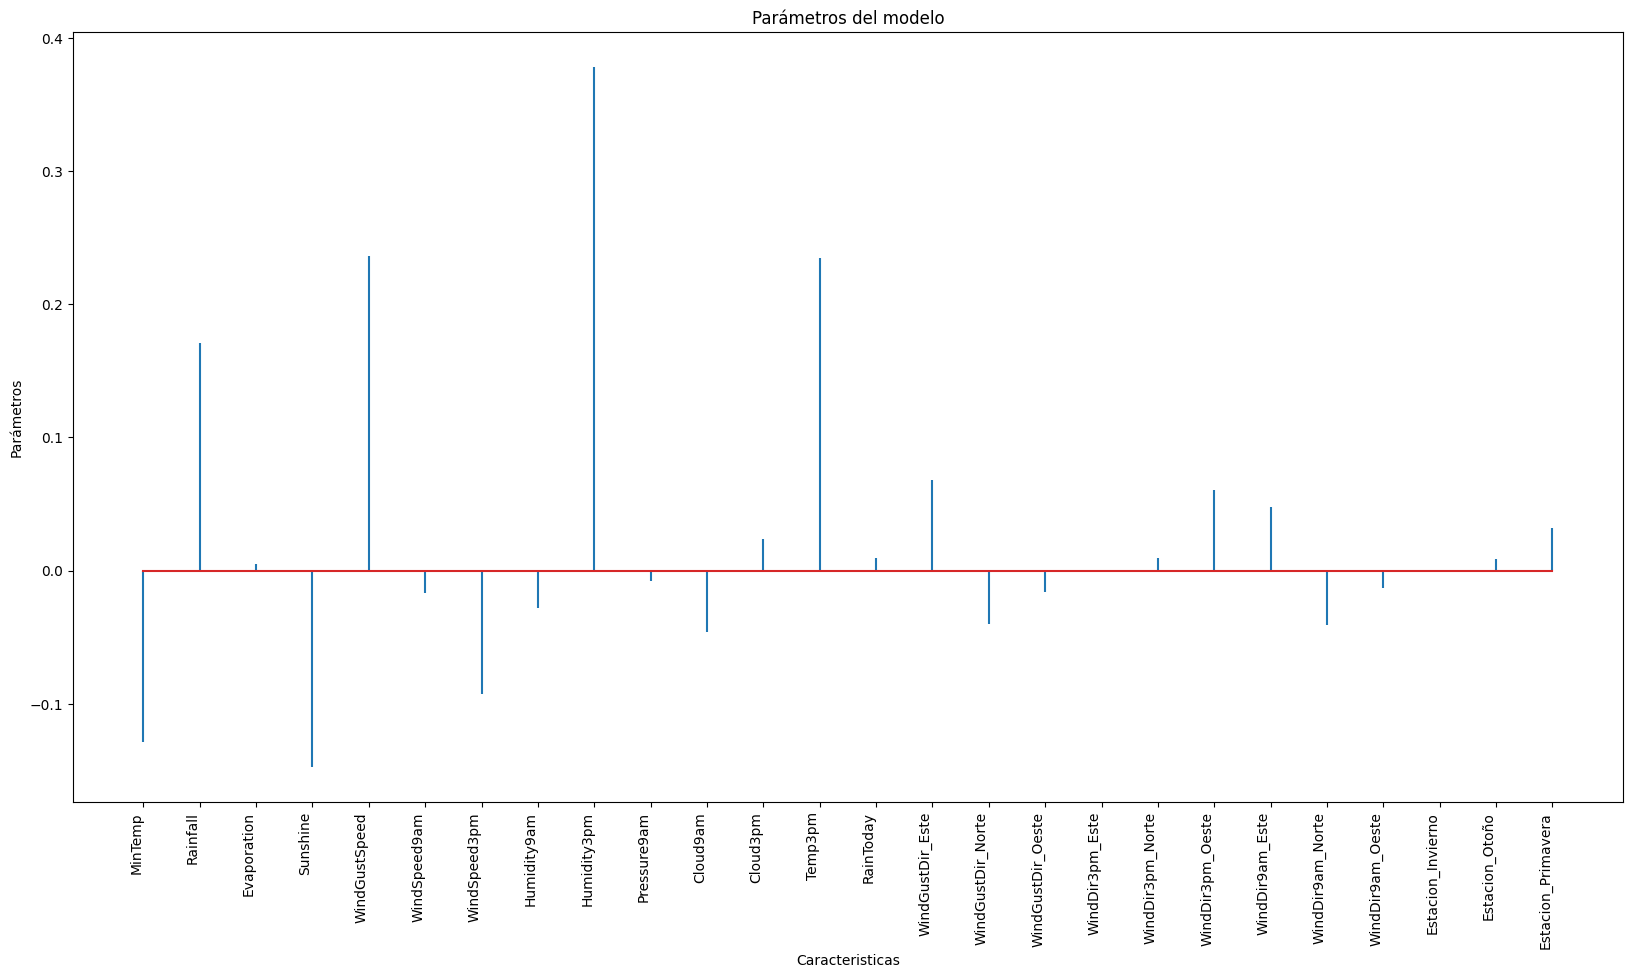

In [ ]:
df_coeficientes = pd.DataFrame({'predictores': X_train_z.columns, 'coeficientes': lasso.coef_.flatten()})

fig, ax = plt.subplots(figsize=(20, 10))
ax.stem(df_coeficientes.predictores, df_coeficientes.coeficientes, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('Caracteristicas')
ax.set_ylabel('Parámetros')
ax.set_title('Parámetros del modelo');

#### Predicciones:

In [ ]:
# Predicciones de train:
y_pred_ltrain = lasso.predict(X_train_z)

# Predicciones de test:
y_pred_ltest = lasso.predict(X_test_z)

#### Metricas:

In [ ]:
# Calculo del Error Cuadrático Medio (MSE)
mse_train_lasso = mean_squared_error(y_train, y_pred_ltrain)
mse_test_lasso = mean_squared_error(y_test, y_pred_ltest)

# Calculo del Error Cuadrático Medio de la Raíz (RMSE)
rmse_train_lasso = np.sqrt(mse_train_lasso)
rmse_test_lasso = np.sqrt(mse_test_lasso)

# Calculo del Error Absoluto Medio (MAE)
mae_train_lasso = mean_absolute_error(y_train, y_pred_ltrain)
mae_test_lasso = mean_absolute_error(y_test, y_pred_ltest)

# Calculo del R2
r2_train_lasso = r2_score(y_train, y_pred_ltrain)
r2_test_lasso = r2_score(y_test, y_pred_ltest)

# Calculo del R2 Ajustado
r2_ajustado_train_l = r2_ajustado(X_train_z, y_train, r2_train_lasso)
r2_ajustado_test_l = r2_ajustado(X_test_z, y_test, r2_test_lasso)

print("---------------------------")
print(f"MSE TRAIN: {mse_train_lasso:.2f}")
print(f"MSE TEST: {mse_test_lasso:.2f}")
print("---------------------------")
print(f"RMSE TRAIN: {rmse_train_lasso:.2f}")
print(f"RMSE TEST: {rmse_test_lasso:.2f}")
print("---------------------------")
print(f"MAE TRAIN: {mae_train_lasso:.2f}")
print(f"MAE TEST: {mae_test_lasso:.2f}")
print("---------------------------")
print(f'R2 TRAIN: {r2_train_lasso:.2f}')
print(f'R2 TEST: {r2_test_lasso:.2f}')
print("---------------------------")
print(f'R2 AJUSTADO TRAIN: {r2_ajustado_train_l:.2f}')
print(f'R2 AJUSTADO TEST: {r2_ajustado_test_l:.2f}')
print("---------------------------")

---------------------------
MSE TRAIN: 0.78
MSE TEST: 0.51
---------------------------
RMSE TRAIN: 0.88
RMSE TEST: 0.71
---------------------------
MAE TRAIN: 0.42
MAE TEST: 0.39
---------------------------
R2 TRAIN: 0.22
R2 TEST: 0.23
---------------------------
R2 AJUSTADO TRAIN: 0.22
R2 AJUSTADO TEST: 0.23
---------------------------


#### Tabla para comparar metricas y coeficientes con regresion lineal y Ridge:

In [ ]:
coeficientes_lasso = np.insert(lasso.coef_, 0, lasso.intercept_)

In [ ]:
datos_lasso = np.insert(coeficientes_lasso, len(coeficientes_lasso), [r2_ajustado_train_l, r2_ajustado_test_l, mse_train_lasso, mse_test_lasso, mae_train_lasso, mae_test_lasso])
coeficientes_regularizacion[f'Lasso-alpha={round(mejor_alpha_lasso, 5)}'] = datos_lasso
round(coeficientes_regularizacion,3)

Regresion_lineal  Ridge-alpha=72.33  \
Intercept                            -0.005             -0.002   
MinTemp                              -0.141             -0.127   
Rainfall                              0.170              0.170   
Evaporation                           0.009              0.009   
Sunshine                             -0.151             -0.148   
WindGustSpeed                         0.238              0.234   
WindSpeed9am                         -0.017             -0.018   
WindSpeed3pm                         -0.096             -0.094   
Humidity9am                          -0.034             -0.029   
Humidity3pm                           0.390              0.375   
Pressure9am                          -0.011             -0.011   
Cloud9am                             -0.049             -0.049   
Cloud3pm                              0.022              0.025   
Temp3pm                               0.252              0.233   
RainToday                             0.012              0.011   
WindGustDir_Este                      0.065              0.065   
WindGustDir_Norte                    -0.061             -0.055   
WindGustDir_Oeste                    -0.040             -0.036   
WindDir3pm_Este                       0.010              0.009   
WindDir3pm_Norte                      0.030              0.028   
WindDir3pm_Oeste                      0.087              0.078   
WindDir9am_Este                       0.055              0.053   
WindDir9am_Norte                     -0.056             -0.051   
WindDir9am_Oeste                     -0.026             -0.024   
Estacion_Invierno                     0.030              0.019   
Estacion_Otoño                        0.038              0.030   
Estacion_Primavera                    0.051              0.045   
r2_ajustado_entrenamiento             0.218              0.218   
r2_ajustado_prueba                    0.228              0.228   
mse_train                             0.781              0.786   
mse_test                              0.511              0.510   
mae_train                             0.425              0.423   
mae_test                              0.390              0.388   

                           Lasso-alpha=0.00108  
Intercept                                0.006  
MinTemp                                 -0.129  
Rainfall                                 0.171  
Evaporation                              0.005  
Sunshine                                -0.147  
WindGustSpeed                            0.236  
WindSpeed9am                            -0.017  
WindSpeed3pm                            -0.093  
Humidity9am                             -0.028  
Humidity3pm                              0.378  
Pressure9am                             -0.008  
Cloud9am                                -0.046  
Cloud3pm                                 0.023  
Temp3pm                                  0.235  
RainToday                                0.009  
WindGustDir_Este                         0.068  
WindGustDir_Norte                       -0.040  
WindGustDir_Oeste                       -0.016  
WindDir3pm_Este                          0.000  
WindDir3pm_Norte                         0.009  
WindDir3pm_Oeste                         0.060  
WindDir9am_Este                          0.047  
WindDir9am_Norte                        -0.041  
WindDir9am_Oeste                        -0.013  
Estacion_Invierno                        0.000  
Estacion_Otoño                           0.009  
Estacion_Primavera                       0.032  
r2_ajustado_entrenamiento                0.217  
r2_ajustado_prueba                       0.228  
mse_train                                0.781  
mse_test                                 0.510  
mae_train                                0.423  
mae_test                                 0.388

* Nuevamente se observa en comparacion con la regresion lineal una muy pequeña disminucion de los coeficientes en general con la salvedad de que dos fueron llevados directamente a 0.

* Las metricas se mantienen practicamente iguales.

* Por el momento podria considerarse el mejor modelo.

### Elastic Net

#### Creacion del modelo:

In [ ]:
elastic_net = ElasticNetCV( l1_ratio = [0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99], alphas = np.logspace(-10, 10, 200), cv = 10)

elastic_net = elastic_net.fit(X_train_z, y_train)

#### Tabla con las combinaciones de l1_ratio y alphas y sus respectivos errores:

In [ ]:
# Error medio de las 10 particiones por cada valor de alpha y l1_ratio
mean_error_cv = elastic_net.mse_path_.mean(axis =2)

# El resultado es un array de dimensiones (n_l1_ratio, n_alpha) se convierte en un dataframe
df_resultados_cv = pd.DataFrame(
                        data   = mean_error_cv.flatten(),
                        index  = pd.MultiIndex.from_product(
                                    iterables = [elastic_net.l1_ratio, elastic_net.alphas_],
                                    names     = ['l1_ratio', 'alphas']
                                 ),
                        columns = ["mse_cv"]
                    )

df_resultados_cv['rmse_cv'] = np.sqrt(df_resultados_cv['mse_cv'])
df_resultados_cv = df_resultados_cv.reset_index().sort_values('mse_cv', ascending = True)
df_resultados_cv

l1_ratio        alphas    mse_cv   rmse_cv
122       0.0  5.478901e-03  0.785981  0.886556
123       0.0  4.347013e-03  0.785983  0.886557
121       0.0  6.905514e-03  0.785987  0.886559
124       0.0  3.448962e-03  0.785989  0.886560
929       0.9  1.084366e-03  0.785992  0.886562
..        ...           ...       ...       ...
501       0.5  7.067181e-01  1.000063  1.000031
500       0.5  8.907355e-01  1.000063  1.000031
499       0.5  1.122668e+00  1.000063  1.000031
604       0.7  3.962689e+09  1.000063  1.000031
699       0.7  1.122668e+00  1.000063  1.000031

[1400 rows x 4 columns]

#### Grafica de evolucion del rmse_cv en funcion de l1_ratio:

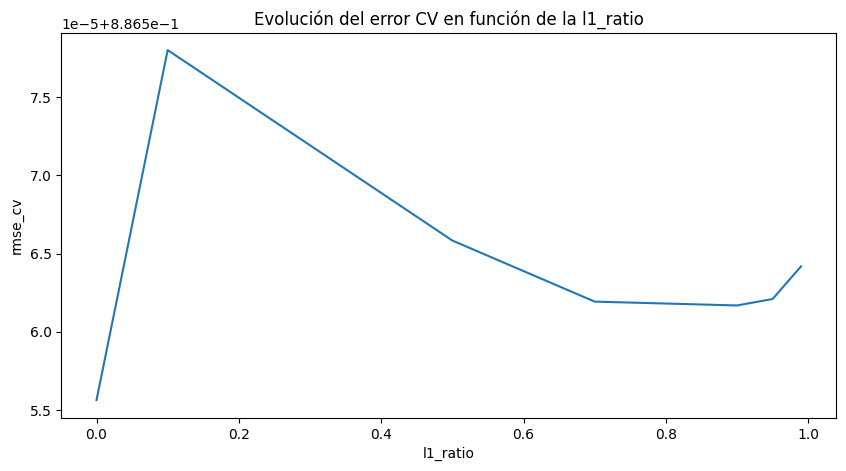

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
df_resultados_cv.groupby('l1_ratio')['rmse_cv'].min().plot(ax = ax)
ax.set_title('Evolución del error CV en función de la l1_ratio')
ax.set_xlabel('l1_ratio')
ax.set_ylabel('rmse_cv');

#### Mejores parametros para elastic net:

In [ ]:
# Mejor valor alpha y l1_ratio_ encontrado
mejor_alpha_elastic = elastic_net.alpha_
mejor_l1_ratio = elastic_net.l1_ratio_
print(f"Mejor valor de alpha encontrado: {mejor_alpha_elastic}")
print(f"Mejor valor de l1_ratio encontrado: {mejor_l1_ratio}")

Mejor valor de alpha encontrado: 0.005478901179593945
Mejor valor de l1_ratio encontrado: 0.0


#### Grafica de como quedan los coeficientes con nuestros mejores parametros:

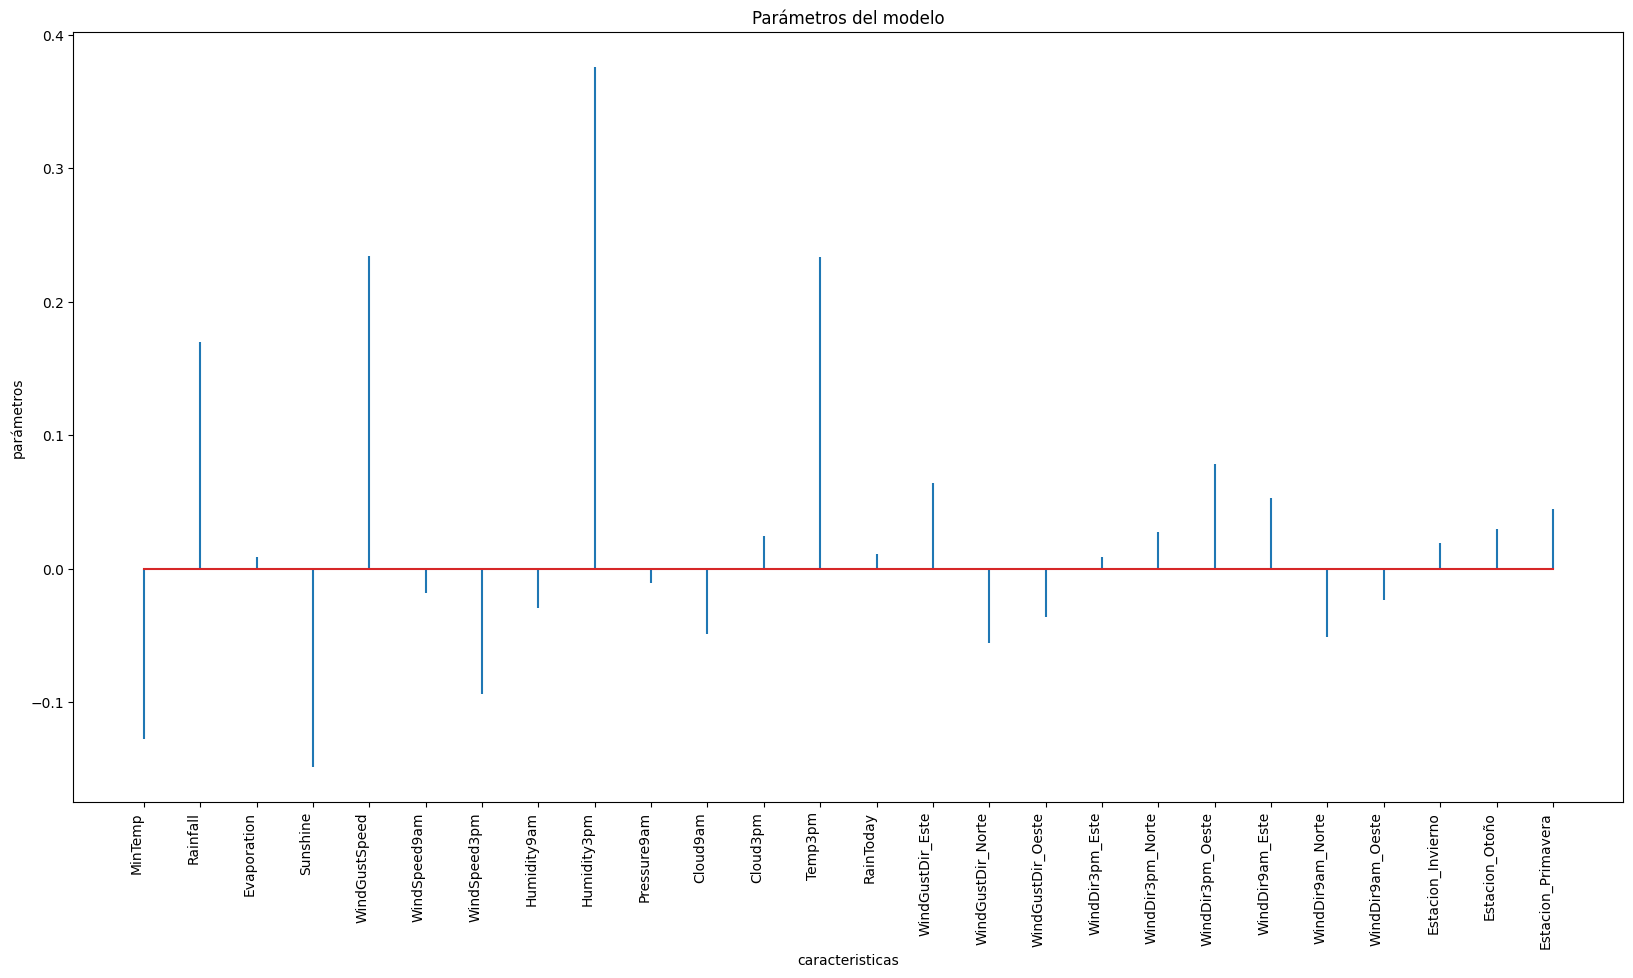

In [ ]:
df_coeficientes = pd.DataFrame( {'predictores': X_train_z.columns, 'coeficientes': elastic_net.coef_.flatten()} )

fig, ax = plt.subplots(figsize=(20, 10))
ax.stem(df_coeficientes.predictores, df_coeficientes.coeficientes, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('caracteristicas')
ax.set_ylabel('parámetros')
ax.set_title('Parámetros del modelo');

#### Predicciones:

In [ ]:
# Predicciones de train:
y_pred_entrain = elastic_net.predict(X_train_z)

# Predicciones de test:
y_pred_entest = elastic_net.predict(X_test_z)

#### Metricas:

In [ ]:
# Calculo del Error Cuadrático Medio (MSE)
mse_train_elastic = mean_squared_error(y_train, y_pred_entrain)
mse_test_elastic = mean_squared_error(y_test, y_pred_entest)

# Calculo del Error Cuadrático Medio de la Raíz (RMSE)
rmse_train_elastic = np.sqrt(mse_train_elastic)
rmse_test_elastic = np.sqrt(mse_test_elastic)

# Calculo del Error Absoluto Medio (MAE)
mae_train_elastic = mean_absolute_error(y_train, y_pred_entrain)
mae_test_elastic = mean_absolute_error(y_test, y_pred_entest)

# Calculo del R2
r2_train_elastic = r2_score(y_train, y_pred_entrain)
r2_test_elastic = r2_score(y_test, y_pred_entest)

# Calculo del R2 Ajustado
r2_ajustado_train_elastic = r2_ajustado(X_train_z, y_train, r2_train_elastic)
r2_ajustado_test_elastic = r2_ajustado(X_test_z, y_test, r2_test_elastic)

print("---------------------------")
print(f"MSE TRAIN: {mse_train_elastic:.2f}")
print(f"MSE TEST: {mse_test_elastic:.2f}")
print("---------------------------")
print(f"RMSE TRAIN: {rmse_train_elastic:.2f}")
print(f"RMSE TEST: {rmse_test_elastic:.2f}")
print("---------------------------")
print(f"MAE TRAIN: {mae_train_elastic:.2f}")
print(f"MAE TEST: {mae_test_elastic:.2f}")
print("---------------------------")
print(f'R2 TRAIN: {r2_train_elastic:.2f}')
print(f'R2 TEST: {r2_test_elastic:.2f}')
print("---------------------------")
print(f'R2 AJUSTADO TRAIN: {r2_ajustado_train_elastic:.2f}')
print(f'R2 AJUSTADO TEST: {r2_ajustado_test_elastic:.2f}')
print("---------------------------")

---------------------------
MSE TRAIN: 0.78
MSE TEST: 0.51
---------------------------
RMSE TRAIN: 0.88
RMSE TEST: 0.71
---------------------------
MAE TRAIN: 0.42
MAE TEST: 0.39
---------------------------
R2 TRAIN: 0.22
R2 TEST: 0.23
---------------------------
R2 AJUSTADO TRAIN: 0.22
R2 AJUSTADO TEST: 0.23
---------------------------


#### R2 y R2 ajustado:

#### Tabla para comparar metricas y coeficientes con regresion lineal, Ridge y Lasso:

In [ ]:
coeficientes_elastic = np.insert(elastic_net.coef_, 0, elastic_net.intercept_)

In [ ]:
datos_elastic = np.insert(coeficientes_elastic, len(coeficientes_elastic), [r2_ajustado_train_elastic, r2_ajustado_test_elastic, mse_train_elastic, mse_test_elastic, mae_train_elastic, mae_test_elastic])
coeficientes_regularizacion[f'ElasticNet:alpha={round(mejor_alpha_elastic, 5)}, l1_ratio={mejor_l1_ratio}'] = datos_elastic
round(coeficientes_regularizacion, 3)

Regresion_lineal  Ridge-alpha=72.33  \
Intercept                            -0.005             -0.002   
MinTemp                              -0.141             -0.127   
Rainfall                              0.170              0.170   
Evaporation                           0.009              0.009   
Sunshine                             -0.151             -0.148   
WindGustSpeed                         0.238              0.234   
WindSpeed9am                         -0.017             -0.018   
WindSpeed3pm                         -0.096             -0.094   
Humidity9am                          -0.034             -0.029   
Humidity3pm                           0.390              0.375   
Pressure9am                          -0.011             -0.011   
Cloud9am                             -0.049             -0.049   
Cloud3pm                              0.022              0.025   
Temp3pm                               0.252              0.233   
RainToday                             0.012              0.011   
WindGustDir_Este                      0.065              0.065   
WindGustDir_Norte                    -0.061             -0.055   
WindGustDir_Oeste                    -0.040             -0.036   
WindDir3pm_Este                       0.010              0.009   
WindDir3pm_Norte                      0.030              0.028   
WindDir3pm_Oeste                      0.087              0.078   
WindDir9am_Este                       0.055              0.053   
WindDir9am_Norte                     -0.056             -0.051   
WindDir9am_Oeste                     -0.026             -0.024   
Estacion_Invierno                     0.030              0.019   
Estacion_Otoño                        0.038              0.030   
Estacion_Primavera                    0.051              0.045   
r2_ajustado_entrenamiento             0.218              0.218   
r2_ajustado_prueba                    0.228              0.228   
mse_train                             0.781              0.786   
mse_test                              0.511              0.510   
mae_train                             0.425              0.423   
mae_test                              0.390              0.388   

                           Lasso-alpha=0.00108  \
Intercept                                0.006   
MinTemp                                 -0.129   
Rainfall                                 0.171   
Evaporation                              0.005   
Sunshine                                -0.147   
WindGustSpeed                            0.236   
WindSpeed9am                            -0.017   
WindSpeed3pm                            -0.093   
Humidity9am                             -0.028   
Humidity3pm                              0.378   
Pressure9am                             -0.008   
Cloud9am                                -0.046   
Cloud3pm                                 0.023   
Temp3pm                                  0.235   
RainToday                                0.009   
WindGustDir_Este                         0.068   
WindGustDir_Norte                       -0.040   
WindGustDir_Oeste                       -0.016   
WindDir3pm_Este                          0.000   
WindDir3pm_Norte                         0.009   
WindDir3pm_Oeste                         0.060   
WindDir9am_Este                          0.047   
WindDir9am_Norte                        -0.041   
WindDir9am_Oeste                        -0.013   
Estacion_Invierno                        0.000   
Estacion_Otoño                           0.009   
Estacion_Primavera                       0.032   
r2_ajustado_entrenamiento                0.217   
r2_ajustado_prueba                       0.228   
mse_train                                0.781   
mse_test                                 0.510   
mae_train                                0.423   
mae_test                                 0.388   

                           ElasticNet:alpha=0.00548, l1_ratio=0.0  
Intercept    

* Coeficientes y metricas practicamente iguales a las de Ridge. Al ser el l1_ratio = 0 se hizo una regularizacion Ridge con un alpha distinto. Al estar redondeados a 3 decimales se ven iguales, si le sacamos el round() se percibe que entrado en decimales varian.

#### Comparacion grafica:

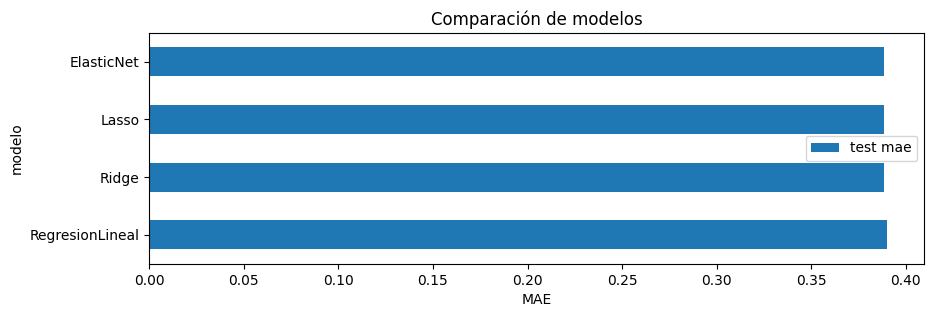

In [ ]:
df_comparacion = pd.DataFrame({
                    'modelo': ['RegresionLineal', 'Ridge', 'Lasso', 'ElasticNet'],
                    'test mae': [mae_test_regresion, mae_test_ridge, mae_test_lasso, mae_test_elastic]
                 })

fig, ax = plt.subplots(figsize=(10, 3))
df_comparacion.set_index('modelo').plot(kind='barh', ax=ax)
ax.set_xlabel('MAE')
ax.set_ylabel('modelo')
ax.set_title('Comparación de modelos');

* La magnitud promedio de los errores es practicamente igual para todas las regresiones.

## Optimizacion de hiperparametros:

* En todos los casos de regularizacion se utilizo la clase CV que incluye la optimizacion de los mismos.

# Eleccion del mejor modelo de regresion lineal:

* De la comparacion de coeficientes y metricas de la regresion lineal comun y las que tienen regularizacion se llega a la conclusion de que el mejor modelo es el Lasso ya que iguala en metrica a las demas disminuyo a 0 la influencia de dos variables, simplificando el modelo.

In [ ]:
regresion_lineal_final = lasso

# Exportamos el modelo
joblib.dump(regresion_lineal_final, 'regresion_lineal.joblib')

['regresion_lineal.joblib']

## Explicabilidad:

### Local:

In [ ]:
explainer_rl = shap.LinearExplainer(regresion_lineal_final, X_train_z, feature_names=X_train_z.columns.values)
valores_shap_rl = explainer_rl.shap_values(X_test_z)
explanation_rl = shap.Explanation(values=valores_shap_rl, base_values=explainer_rl.expected_value, feature_names=X_train_z.columns.values, data=X_test_z)

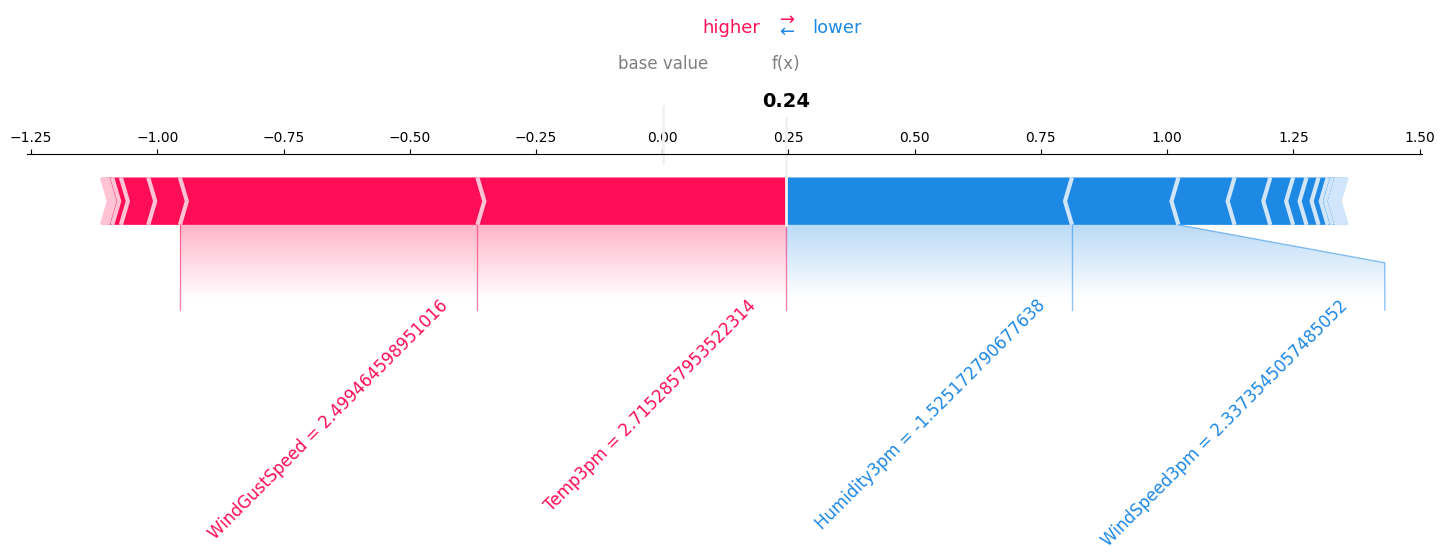

In [ ]:
# Grafico de fuerza:
shap.force_plot(explainer_rl.expected_value, valores_shap_rl[20], X_test_z.iloc[20], feature_names=X_train_z.columns.values, matplotlib=True, figsize=(18, 4), \
                text_rotation=45)

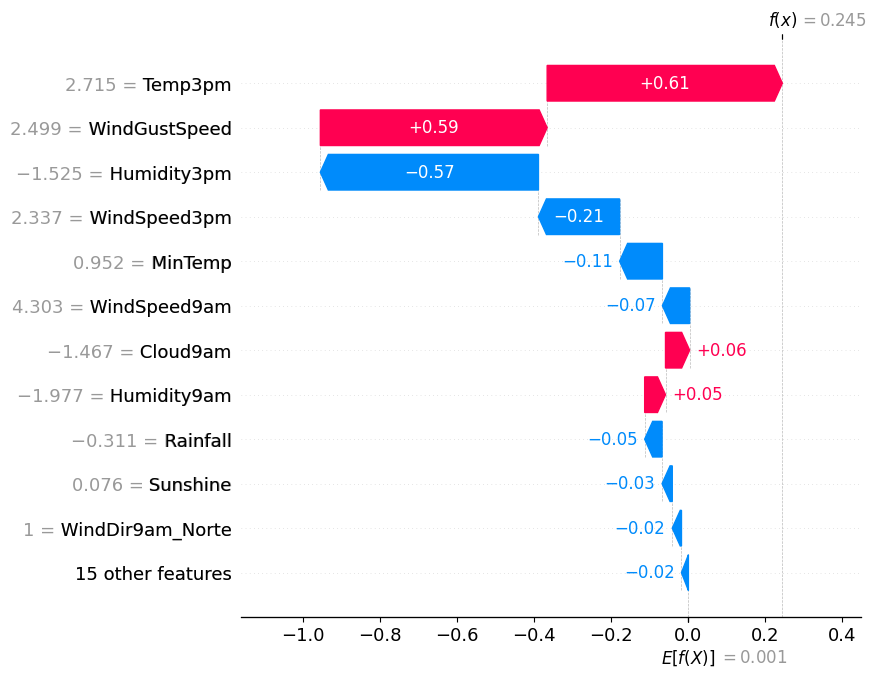

In [ ]:
# Gráfico de cascada:
shap.plots.waterfall(explanation_rl[20], max_display=12)

* Explicación de la predicción hecha sobre el evento correspondiente a la fila 20 de nuestro dataset de test. Podemos notar en el gráfico de fuerza y en el de cascada, que obtenemos una predicción de 0.245, "empujada" hacia arriba por WindGustSpeed y Temp3pm, mientras baja principalmente por Humidity3pm.

### Global:

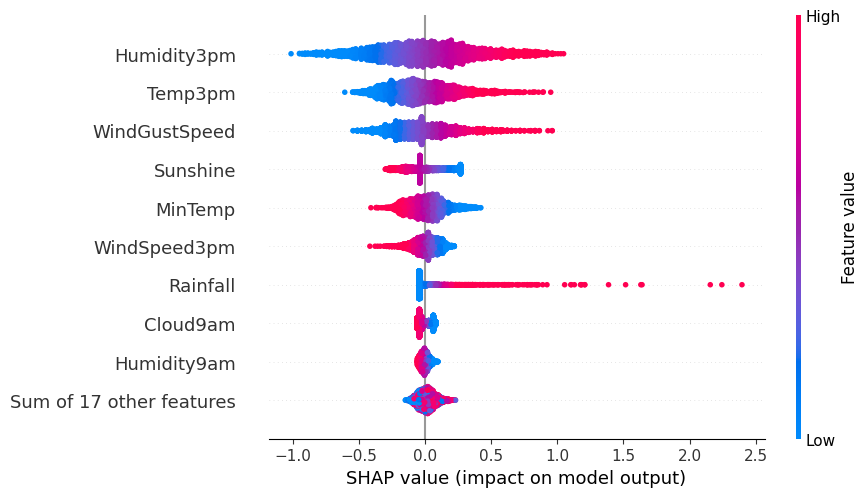

In [ ]:
# Grafico de abejas:
shap.plots.beeswarm(explanation_rl)

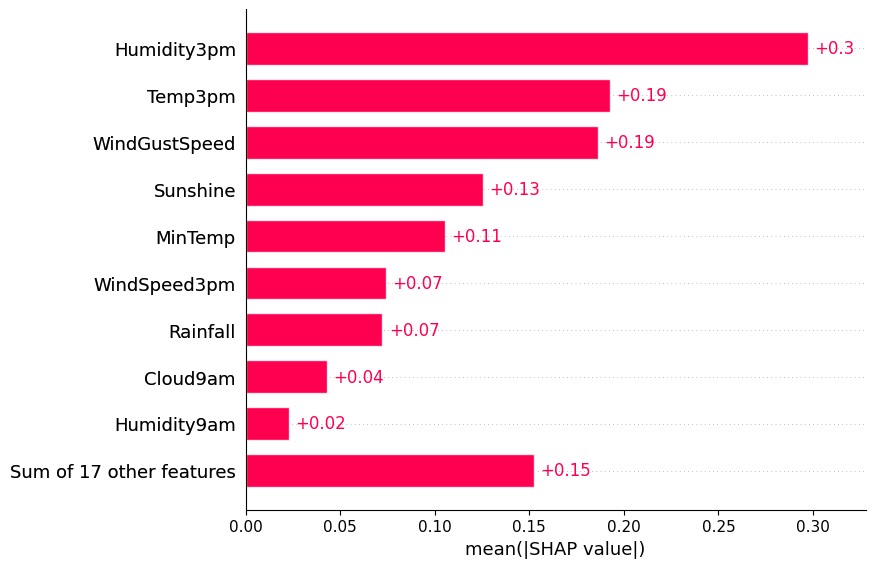

In [ ]:
# Grafico de barras:
shap.plots.bar(explanation_rl)

* Explicación de la predicciones globales del modelo. Las primeras 5 features son las más relevantes en los output, luego los valores de influencia descienden muchisimo.

# Regresion Logistica:

* En todo lo que sea clasificacion durante el TP la metrica que vamos a elegir para comparar modelos es el f1-score ya que adoptamos la posicion donde nos interesa mantener equilibradas tanto el recall como la precision y esta metrica sirve para eso. En particular compararemos modelos a partir del f1 score macro (promedio).

## Declaracion de funcion para graficar boxplots:

In [ ]:
def boxplots(X,y):

  data = pd.concat([pd.DataFrame(y),
                    pd.DataFrame(X, columns=X.columns)], axis=1)

  num_features = X.shape[1]
  num_rows = num_features // 3 + 1

  fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))
  fig.subplots_adjust(hspace=0.5)

  # Se recorre cada feature para generar su diagrama de caja respecto de la salida
  for i, feature in enumerate(data.columns[1:]):
      row = i // 3
      col = i % 3
      sns.boxplot(x='RainTomorrow', y=feature, data=data, ax=axes[row, col])
      axes[row, col].set_title(f'Diagrama de caja de {feature}')
      axes[row, col].set_xlabel('RainTomorrow')
      axes[row, col].set_ylabel(feature)

  # Eliminar subplots vacíos si es necesario
  if num_features % 3 != 0:
      for i in range(num_features % 3, 3):
          fig.delaxes(axes[num_rows - 1, i])

  plt.show()


## Division en variables independientes y dependientes:

Mantenemos los mismos criterios que en la regresion lineal de haber eliminado las variables con alta correlacion entre si para evitar problemas de multicolinealidad que nos simplifiquen el modelo y que nos perjudique a la interpretacion de los parametros.

Solo debemos cambiar los "y" de train y test por la variable objetivo que necesitamos.

In [ ]:
# Los conjuntos de train y test son los mismos con las mismas variables que en la regresion:
X_train_clasificacion_z = X_train_z.copy()
X_test_clasificacion_z = X_test_z.copy()

# Lo unico que hay que cambiar es agarrar de los conjuntos finales de train y test la variable RainTomorrow ya codificada.
y_train_clasificacion = df_train_final['RainTomorrow'].reset_index(drop=True)
y_test_clasificacion = df_test_final['RainTomorrow'].reset_index(drop=True)

In [ ]:
# Nuestras variables independientes:
print(X_train_clasificacion_z.columns)
print(f'\nCantidad de variables independientes: {len(X_train_clasificacion_z.columns)}')

Index(['MinTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Cloud9am', 'Cloud3pm', 'Temp3pm', 'RainToday',
       'WindGustDir_Este', 'WindGustDir_Norte', 'WindGustDir_Oeste',
       'WindDir3pm_Este', 'WindDir3pm_Norte', 'WindDir3pm_Oeste',
       'WindDir9am_Este', 'WindDir9am_Norte', 'WindDir9am_Oeste',
       'Estacion_Invierno', 'Estacion_Otoño', 'Estacion_Primavera'],
      dtype='object')

Cantidad de variables independientes: 26


In [ ]:
# Nuestra variable dependiente
y_test_clasificacion.to_frame().columns

Index(['RainTomorrow'], dtype='object')

## Regresion logistica (sin balancear clases):

En primer lugar probamos una regresion logistica sin balanceo de clases (teniendo consciencia de que elegimos la metrica f1 score que es buena cuando los datos estan balanceados, pero solo es una prueba para ver los resultados de una regresion logistica con datos desbalanceados)

Ya vimos en el analisis de datos previo que las clases en la variable objetivo estan desbalanceadas.

In [ ]:
# En terminos absolutos
y_train_clasificacion.value_counts()

0    9816
1    2972
Name: RainTomorrow, dtype: int64

In [ ]:
# En proporciones
round((y_train_clasificacion.value_counts() * 100) / len(y_train_clasificacion), 2)

0    76.76
1    23.24
Name: RainTomorrow, dtype: float64

### Observamos en las features del conjunto de train

Solo sobre las variables numericas, dejamos afuera las dummies

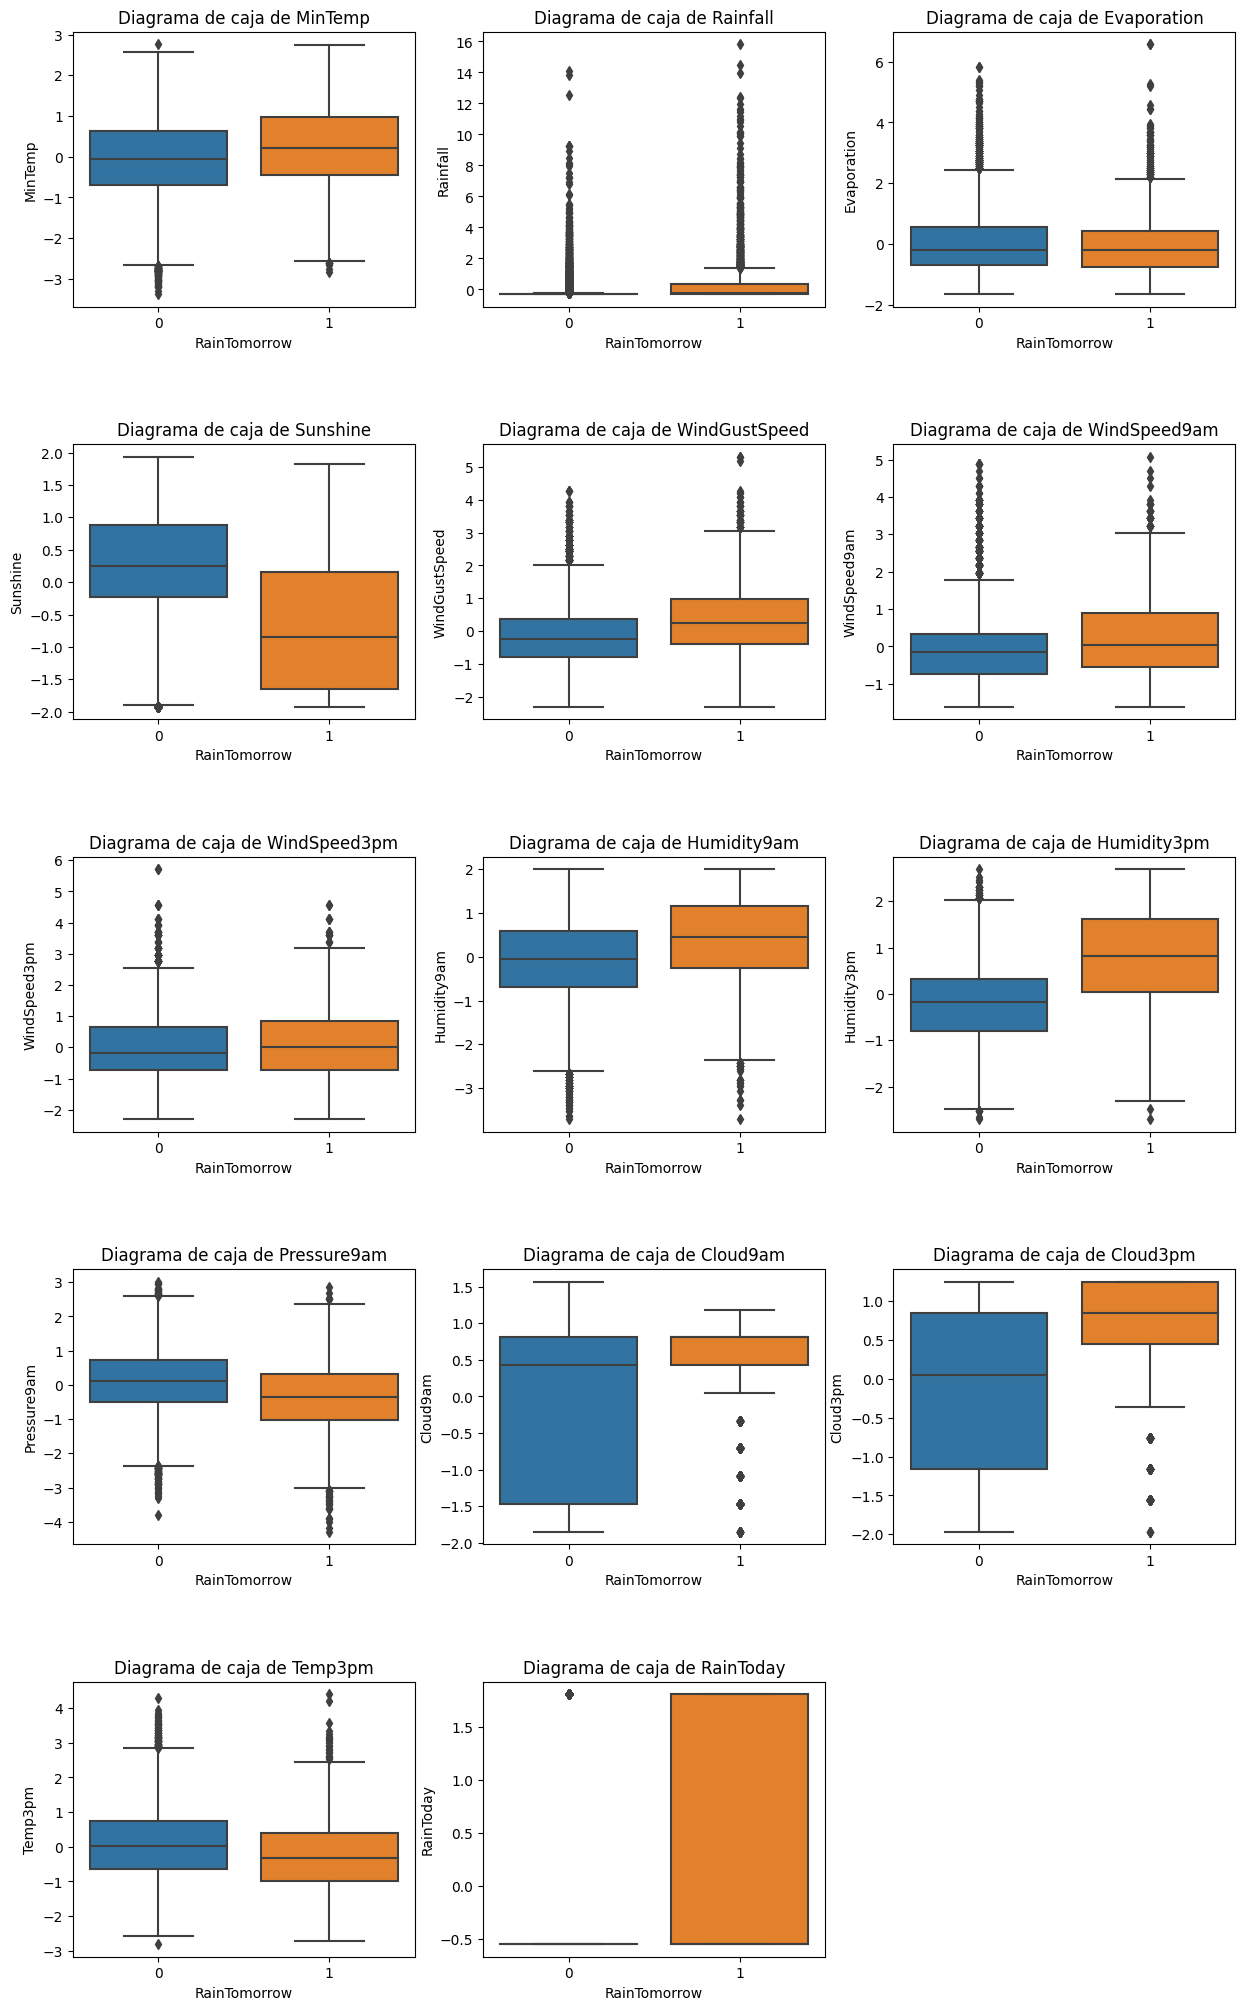

In [ ]:
numericas = ['MinTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Cloud9am', 'Cloud3pm', 'Temp3pm', 'RainToday']

boxplots(X_train_clasificacion_z[numericas], y_train_clasificacion)

### Modelo:

In [ ]:
# Regresion logistica y entrenamiento:
regresion_logistica_desbalanceada_1 = LogisticRegression(random_state=42)
regresion_logistica_desbalanceada_1.fit(X_train_clasificacion_z, y_train_clasificacion)

LogisticRegression(random_state=42)

### Predicciones:

In [ ]:
# Predicciones train:
y_pred_train_logistica_d1 = regresion_logistica_desbalanceada_1.predict(X_train_clasificacion_z)

# Predicciones test:
y_pred_test_logistica_d1 = regresion_logistica_desbalanceada_1.predict(X_test_clasificacion_z)

### Metricas:

In [ ]:
print("Metricas train: ")
metricas_train_dlogistica_1 = classification_report(y_train_clasificacion, y_pred_train_logistica_d1, output_dict=True)
print(classification_report(y_train_clasificacion, y_pred_train_logistica_d1))
print(confusion_matrix(y_train_clasificacion, y_pred_train_logistica_d1))

Metricas train: 
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      9816
           1       0.72      0.50      0.59      2972

    accuracy                           0.84     12788
   macro avg       0.79      0.72      0.74     12788
weighted avg       0.83      0.84      0.83     12788

[[9239  577]
 [1494 1478]]


In [ ]:
print("Metricas test: ")
metricas_test_dlogistica_1 = classification_report(y_train_clasificacion, y_pred_train_logistica_d1, output_dict=True)
print(classification_report(y_test_clasificacion, y_pred_test_logistica_d1))
print(confusion_matrix(y_test_clasificacion, y_pred_test_logistica_d1))

Metricas test: 
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      2435
           1       0.73      0.50      0.59       763

    accuracy                           0.84      3198
   macro avg       0.79      0.72      0.74      3198
weighted avg       0.83      0.84      0.82      3198

[[2294  141]
 [ 385  378]]


* A simple vista no parece haber overfitting ya que las metricas de test y train dan resultados similares.

* Obtenemos un f1-score alto para la clase 0 (0.9) pero bastante mas bajo para la clase 1 (0.59). Y el promedio es 0.74. De todos modos como dijimos arriba el dataset esta desbalanceado y no es de mucho fiar en este caso.

## Regresion Logistica (con balanceo de clases):

### Oversample:

In [ ]:
# Modelo de remuestreo:
oversampler = RandomOverSampler(random_state=42)

# Remuestreo solo con datos de entrenamiento:
X_train_resampled_z, y_train_resampled = oversampler.fit_resample(X_train_clasificacion_z, y_train_clasificacion)

In [ ]:
# Ahora tenemos la misma cantidad de cada clase en entrenamiento:
y_train_resampled.value_counts()

0    9816
1    9816
Name: RainTomorrow, dtype: int64

### Modelo:

In [ ]:
# Regresion logistica y entrenamiento:
regresion_logistica_balanceada_1 = LogisticRegression(random_state=42)
regresion_logistica_balanceada_1.fit(X_train_resampled_z, y_train_resampled)

LogisticRegression(random_state=42)

### Predicciones:

In [ ]:
# Predicciones train:
y_pred_train_logistica_b1 = regresion_logistica_balanceada_1.predict(X_train_resampled_z)

# Predicciones test:
y_pred_test_logistica_b1 = regresion_logistica_balanceada_1.predict(X_test_clasificacion_z)

### Metricas:

In [ ]:
print("Metricas train: ")
print(classification_report(y_train_resampled, y_pred_train_logistica_b1))
print(confusion_matrix(y_train_resampled, y_pred_train_logistica_b1))

Metricas train: 
              precision    recall  f1-score   support

           0       0.76      0.78      0.77      9816
           1       0.77      0.75      0.76      9816

    accuracy                           0.76     19632
   macro avg       0.77      0.76      0.76     19632
weighted avg       0.77      0.76      0.76     19632

[[7682 2134]
 [2483 7333]]


In [ ]:
print("Metricas test: ")
metricas_test_blogistica_1 = classification_report(y_test_clasificacion, y_pred_test_logistica_b1, output_dict=True)
print(classification_report(y_test_clasificacion, y_pred_test_logistica_b1))
print(confusion_matrix(y_test_clasificacion, y_pred_test_logistica_b1))

Metricas test: 
              precision    recall  f1-score   support

           0       0.91      0.78      0.84      2435
           1       0.52      0.74      0.61       763

    accuracy                           0.77      3198
   macro avg       0.71      0.76      0.73      3198
weighted avg       0.81      0.77      0.79      3198

[[1905  530]
 [ 195  568]]


Curva ROC:


In [ ]:
# Obtengo las probabilidades de predicción del modelo:
y_probs_test = regresion_logistica_balanceada_1.predict_proba(X_test_clasificacion_z)[:, 1]
# predict_proba -> probabilidad de pertenencia a cada una de las clases para cada punto del x_test.
# Para cada valor tira dos valores que suman 1
# [:, 1] -> me quedo con la de la clase 1

In [ ]:
# Calculo la ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_test_clasificacion, y_probs_test)
roc_auc = auc(fpr, tpr)

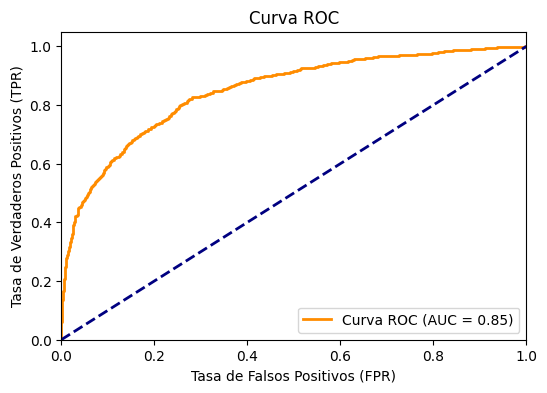

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

In [ ]:
round(roc_auc, 3)

0.849

El area bajo la curva ROC es 0.849 por lo que aparentemente el modelo sería bueno a la hora de discriminar entre falsos positivos y verdaderos positivos.

In [ ]:
# Tabla que usaremos para comparar metricas de modelos:
indices = ['f1_score_0', 'f1_score_1', 'f1_score_macro']
regresion_logistica_comparacion = pd.DataFrame(index=indices)
regresion_logistica_comparacion['regresion_logistica_oversampled'] = [metricas_test_blogistica_1['0']['f1-score'], metricas_test_blogistica_1['1']['f1-score'], metricas_test_blogistica_1['macro avg']['f1-score']]
regresion_logistica_comparacion

regresion_logistica_oversampled
f1_score_0                             0.840132
f1_score_1                             0.610425
f1_score_macro                         0.725278

## Regresion Logistica (con distintos pesos en funcion de costo):

### Modelo:

In [ ]:
# Regresion Logistica y entrenamiento
regresion_logistica_pesos = LogisticRegression(random_state=42, class_weight='balanced')
regresion_logistica_pesos.fit(X_train_clasificacion_z, y_train_clasificacion)

LogisticRegression(class_weight='balanced', random_state=42)

### Predicciones:

In [ ]:
# Train
y_pred_train_logistica_p = regresion_logistica_pesos.predict(X_train_clasificacion_z)
# Test
y_pred_test_logistica_p = regresion_logistica_pesos.predict(X_test_clasificacion_z)

### Metricas:

In [ ]:
print("Metricas train: ")
print(classification_report(y_train_clasificacion, y_pred_train_logistica_p))
print(confusion_matrix(y_train_clasificacion, y_pred_train_logistica_p))

Metricas train: 
              precision    recall  f1-score   support

           0       0.91      0.78      0.84      9816
           1       0.51      0.75      0.61      2972

    accuracy                           0.78     12788
   macro avg       0.71      0.77      0.73     12788
weighted avg       0.82      0.78      0.79     12788

[[7704 2112]
 [ 741 2231]]


In [ ]:
print("Metricas test: ")
metricas_test_plogistica = classification_report(y_test_clasificacion, y_pred_test_logistica_p, output_dict=True)
print(classification_report(y_test_clasificacion, y_pred_test_logistica_p))
print(confusion_matrix(y_test_clasificacion, y_pred_test_logistica_p))

Metricas test: 
              precision    recall  f1-score   support

           0       0.91      0.78      0.84      2435
           1       0.52      0.74      0.61       763

    accuracy                           0.77      3198
   macro avg       0.71      0.76      0.73      3198
weighted avg       0.81      0.77      0.79      3198

[[1907  528]
 [ 195  568]]


* Metricas similares en train/test no parece haber overfitting.

Curva ROC:


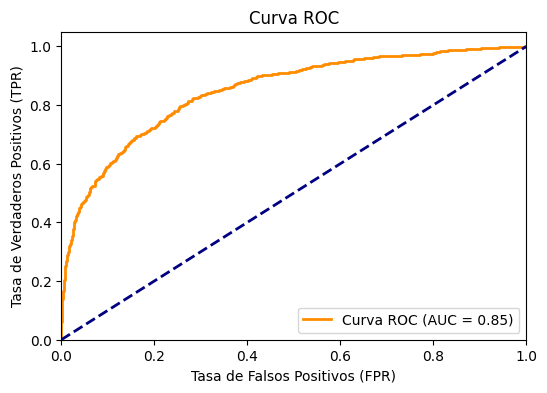

In [ ]:
y_probs_test = regresion_logistica_pesos.predict_proba(X_test_clasificacion_z)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_clasificacion, y_probs_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

In [ ]:
round(roc_auc, 3)

0.849

Nuevamente un valor similar de ROC AUC.

In [ ]:
regresion_logistica_comparacion['regresion_logistica_pesos'] = [metricas_test_plogistica['0']['f1-score'], metricas_test_plogistica['1']['f1-score'], metricas_test_plogistica['macro avg']['f1-score']]
round(regresion_logistica_comparacion, 3)

regresion_logistica_oversampled  regresion_logistica_pesos
f1_score_0                                0.840                      0.841
f1_score_1                                0.610                      0.611
f1_score_macro                            0.725                      0.726

* Observando las metricas y comparandolas con el modelo anterior no se ven diferencias sustanciales.

## Regresion Logistica balanceada con SMOTE:

### Resampleo:

In [ ]:
smote = SMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train_clasificacion_z, y_train_clasificacion)

### Modelo:

In [ ]:
regresion_logistica_smote = LogisticRegression(random_state=42)
regresion_logistica_smote.fit(X_train_smote, y_train_smote)

LogisticRegression(random_state=42)

### Predicciones:

In [ ]:
# Train
y_pred_train_logistica_s = regresion_logistica_smote.predict(X_train_smote)
# Test
y_pred_test_logistica_s = regresion_logistica_smote.predict(X_test_clasificacion_z)

### Metricas:

In [ ]:
print("Metricas train: ")
print(classification_report(y_train_smote, y_pred_train_logistica_s))
print(confusion_matrix(y_train_smote, y_pred_train_logistica_s))

Metricas train: 
              precision    recall  f1-score   support

           0       0.77      0.79      0.78      9816
           1       0.78      0.77      0.78      9816

    accuracy                           0.78     19632
   macro avg       0.78      0.78      0.78     19632
weighted avg       0.78      0.78      0.78     19632

[[7745 2071]
 [2291 7525]]


In [ ]:
print("Metricas test: ")
metricas_test_slogistica = classification_report(y_test_clasificacion, y_pred_test_logistica_s, output_dict=True)
print(classification_report(y_test_clasificacion, y_pred_test_logistica_s))
print(confusion_matrix(y_test_clasificacion, y_pred_test_logistica_s))

Metricas test: 
              precision    recall  f1-score   support

           0       0.90      0.80      0.85      2435
           1       0.53      0.71      0.61       763

    accuracy                           0.78      3198
   macro avg       0.72      0.76      0.73      3198
weighted avg       0.81      0.78      0.79      3198

[[1953  482]
 [ 218  545]]


* Metricas de train/test algo distintas, podria haber un poco de overfitting.

Curva ROC:


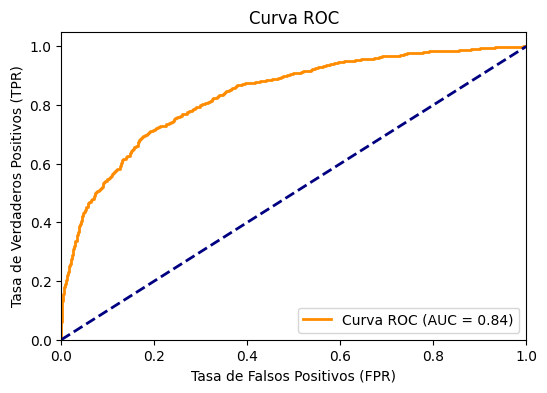

In [ ]:
y_probs_test = regresion_logistica_smote.predict_proba(X_test_clasificacion_z)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_clasificacion, y_probs_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

In [ ]:
round(roc_auc, 3)

0.836

El valor mas bajo hasta ahora de ROC AUC, aunque es muy similar a los anteriores.

In [ ]:
regresion_logistica_comparacion['regresion_logistica_smote'] = [metricas_test_slogistica['0']['f1-score'], metricas_test_slogistica['1']['f1-score'], metricas_test_slogistica['macro avg']['f1-score']]
round(regresion_logistica_comparacion, 3)

regresion_logistica_oversampled  regresion_logistica_pesos  \
f1_score_0                                0.840                      0.841   
f1_score_1                                0.610                      0.611   
f1_score_macro                            0.725                      0.726   

                regresion_logistica_smote  
f1_score_0                          0.848  
f1_score_1                          0.609  
f1_score_macro                      0.728

* Seguimos obteniendo valores de metricas muy parecidas. Por el momento se prefiere la regresion logistica con pesos ya que de todas es la que mas parecidas dieron las metricas en train/test.

## Optimizacion de hiperparametros:

Optaremos para este caso por la utilizacion de optimizacion por grilla ya que esta explora todas las combinaciones posibles para darnos el mejor resultado y como no son tantas combinaciones y en si con estos datos la regresion logistica no tarda mucho nos parece la mejor probar con todo.

Los hiperparametros a optimizar se eligieron leyendo un poco la documentacion del metodo. Utilizaremos los datos con oversampling por lo que class_weight queda por defecto en None.

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

grilla_parametros = {
    'penalty': [ None, 'l1', 'l2', 'elasticnet' ],
    'solver': [ 'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga' ],
    'l1_ratio': [ None, 0, 0.1, 0.3, 0.5, 0.7, 0.9, 1 ],
}


grilla_regresion = GridSearchCV(LogisticRegression(random_state=42), grilla_parametros, cv=5, scoring='f1_macro')
grilla_regresion.fit(X_train_resampled_z, y_train_resampled)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'l1_ratio': [None, 0, 0.1, 0.3, 0.5, 0.7, 0.9, 1],
                         'penalty': [None, 'l1', 'l2', 'elasticnet'],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                    'newton-cholesky', 'sag', 'saga']},
             scoring='f1_macro')

### Mejores parametros de la optimizacion:

In [ ]:
grilla_regresion.best_params_

{'l1_ratio': None, 'penalty': 'l2', 'solver': 'liblinear'}

Casi los hiperparametros por defecto a excepcion del 'solver'.

### Modelo:

In [ ]:
# Nos quedamos con el mejor modelo del GridCV:
regresion_logistica_optimizada = grilla_regresion.best_estimator_

### Predicciones:

In [ ]:
# Predicciones train:
y_pred_train_logistica_o = regresion_logistica_optimizada.predict(X_train_resampled_z)

# Predicciones test:
y_pred_test_logistica_o = regresion_logistica_optimizada.predict(X_test_clasificacion_z)

### Metricas:

In [ ]:
print("Metricas train: ")
print(classification_report(y_train_resampled, y_pred_train_logistica_o))
print(confusion_matrix(y_train_resampled, y_pred_train_logistica_o))

Metricas train: 
              precision    recall  f1-score   support

           0       0.76      0.78      0.77      9816
           1       0.77      0.75      0.76      9816

    accuracy                           0.76     19632
   macro avg       0.76      0.76      0.76     19632
weighted avg       0.76      0.76      0.76     19632

[[7680 2136]
 [2486 7330]]


In [ ]:
print("Metricas test: ")
metricas_test_ologistica = classification_report(y_test_clasificacion, y_pred_test_logistica_o, output_dict=True)
print(classification_report(y_test_clasificacion, y_pred_test_logistica_o))
print(confusion_matrix(y_test_clasificacion, y_pred_test_logistica_o))

Metricas test: 
              precision    recall  f1-score   support

           0       0.91      0.78      0.84      2435
           1       0.52      0.74      0.61       763

    accuracy                           0.77      3198
   macro avg       0.71      0.76      0.72      3198
weighted avg       0.81      0.77      0.79      3198

[[1904  531]
 [ 195  568]]


Logicamente, con estos hiperparametros obtuvimos en metricas exactamente los mismos resultados que en la regresion con balanceo de clases oversampled.

Curva ROC:


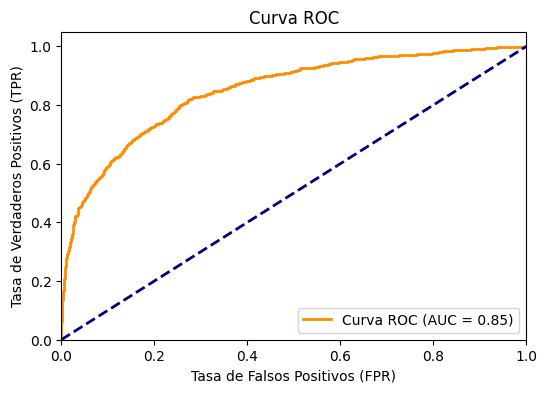

In [ ]:
y_probs_test = regresion_logistica_optimizada.predict_proba(X_test_clasificacion_z)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_clasificacion, y_probs_test)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

In [ ]:
round(roc_auc, 3)

0.849

Mismo valor que en todos los casos

In [ ]:
regresion_logistica_comparacion['regresion_logistica_optimizada'] = [metricas_test_ologistica['0']['f1-score'], metricas_test_ologistica['1']['f1-score'], metricas_test_ologistica['macro avg']['f1-score']]
round(regresion_logistica_comparacion, 3)

regresion_logistica_oversampled  regresion_logistica_pesos  \
f1_score_0                                0.840                      0.841   
f1_score_1                                0.610                      0.611   
f1_score_macro                            0.725                      0.726   

                regresion_logistica_smote  regresion_logistica_optimizada  
f1_score_0                          0.848                           0.840  
f1_score_1                          0.609                           0.610  
f1_score_macro                      0.728                           0.725

## Eleccion del mejor modelo de regresion logistica:

* Hasta el momento seguimos en la misma linea de tener modelos muy similares en cuanto a la metrica que nos interesa.

* Nos vamos a quedar con el modelo que le agregaba pesos a la funcion de costo por una cuestion de que es el que dio metricas mas similares en train/test.

In [ ]:
regresion_logistica_final = regresion_logistica_pesos

# Exportamos el mejor modelo nuevamente
joblib.dump(regresion_logistica_final, 'regresion_logistica.joblib')

['regresion_logistica.joblib']

## Explicabilidad:

### Local:

In [ ]:
explainer_rlog = shap.LinearExplainer(regresion_logistica_final, X_train_clasificacion_z, feature_names=X_train_clasificacion_z.columns.values)
valores_shap_rlog = explainer_rlog.shap_values(X_test_clasificacion_z)
explanation_rlog = shap.Explanation(values=valores_shap_rlog, base_values=explainer_rlog.expected_value, feature_names=X_train_clasificacion_z.columns.values, data=X_test_clasificacion_z)


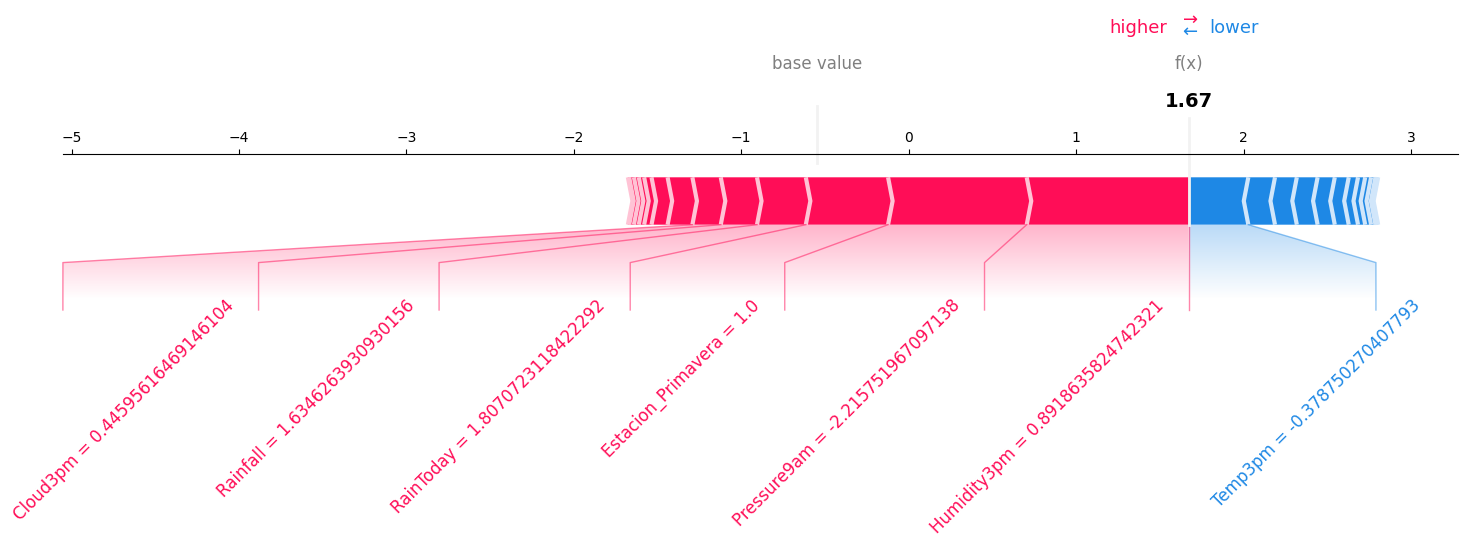

In [ ]:
# Force plot de la fila 5:
shap.force_plot(explainer_rlog.expected_value, valores_shap_rlog[5], X_test_clasificacion_z.iloc[5], feature_names=X_train_resampled_z.columns.values, matplotlib=True, figsize=(18, 4), \
                text_rotation=45)

* Para regresion logistica no vamos a estar en la escala de salida de la funcion sigmoide sino en la del logaritmo de las chances.

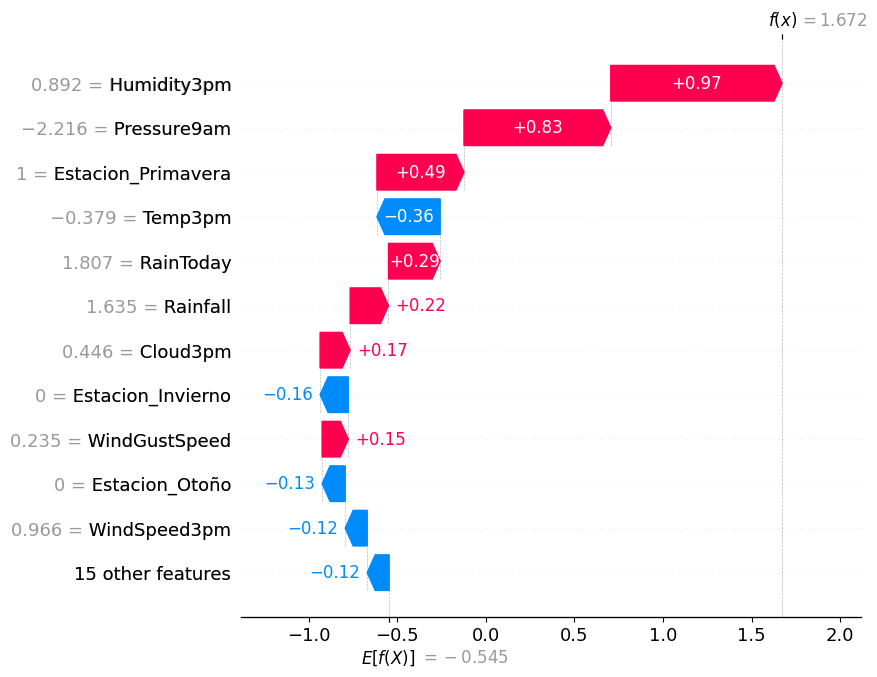

In [ ]:
# Grafico de cascada:
shap.plots.waterfall(explanation_rlog[5], max_display=12)

* Explicación de la predicción hecha sobre el evento correspondiente a la fila 5 de nuestro dataset de test. Podemos notar en el gráfico de fuerza y en el de cascada, que obtenemos una predicción de 1.67, "empujada" hacia arriba por Humidity3pm y Preassure9am, mientras baja principalmente por Temp3pm.

### Global:

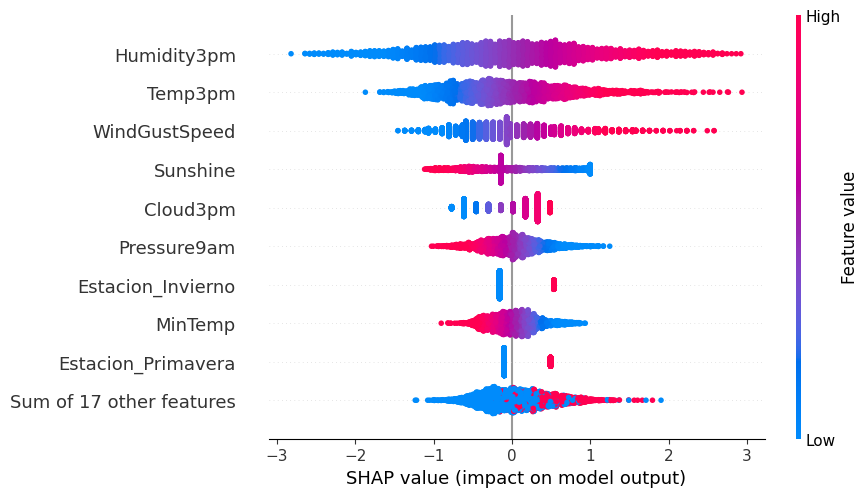

In [ ]:
# Grafico de abejas:
shap.plots.beeswarm(explanation_rlog)

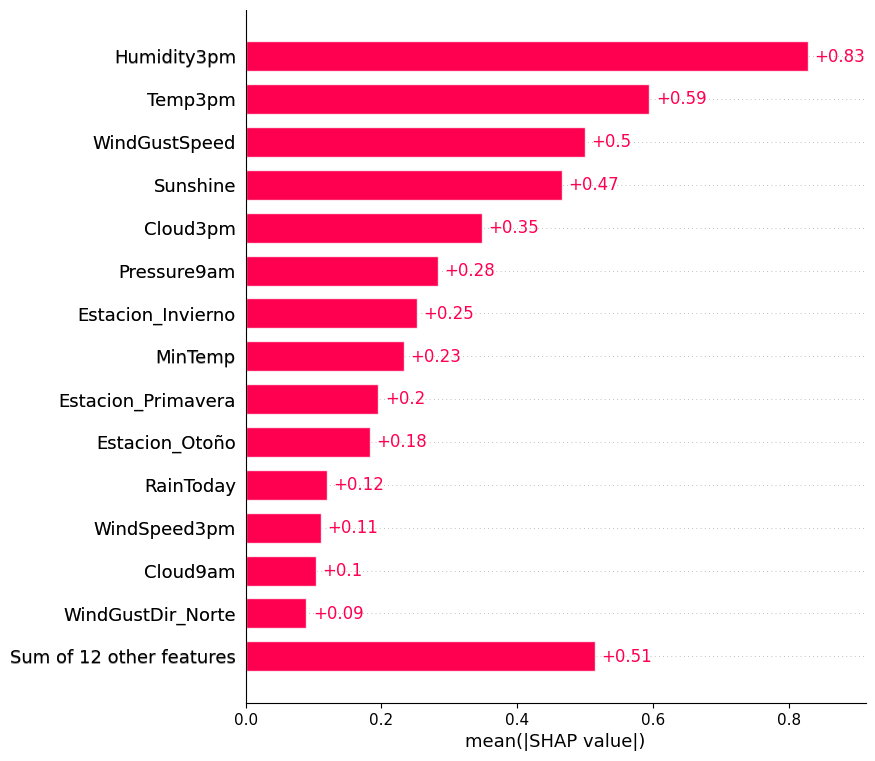

In [ ]:
# Grafico de barras
shap.plots.bar(explanation_rlog, 15)

* Explicación de la predicciones globales del modelo. Podemos notar que Humidity afecta en gran medida para clasificar hacia ambas clases. Luego las 2 siguientes, Temp3pm y WindGustDir tienen mayor peso a la hora de clasificar de manera positiva. Pareciera que en general muchas más variables son influyentes en comparación a la regresión lineal.

# Redes neuronales:

## Clasificación:

Basicamente vamos a usar las mismas variables independientes y dependiente de la clasificacion con regresion logistica. En particular el dataset con oversampling para evitar sesgos hacia la clase mayoritaria.

### Modelo sin optimizar:

#### Arquitectura

Vamos a utilizar 2 capas ocultas de 16 neuronas (ambas con funcion de activacion relu) y una capa de salida de una neurona con funcion de activacion sigmoide.

In [ ]:
class NeuralNetworkTensorFlow:
    def __init__(self):
        self.model = self.build_model()

    def build_model(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(16, activation='relu', input_shape=(26,)), # 26 caracteristicas
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        print("Número de parámetros:", model.count_params())
        return model

    def fit(self, X, y, epochs=200):

        X = np.array(X)
        y = np.array(y)

        # Creamos el diccionario para almacenar todas las metricas que nos interesan
        history = {'loss': [], 'f1_score_macro': []}

        for epoch in range(epochs):
            print(f'Epoca: {epoch+1}/{epochs}:')
            historia_epoca = self.model.fit(X, y, epochs=1, batch_size=32, verbose=0)

            # Calcular predicciones:
            y_pred = self.predict_binary(X)

            # Calcular el F1-score:
            f1_score_macro = f1_score(y, y_pred, average='macro')

            # Almacenamos metrica en diccionario:
            history['f1_score_macro'].append(f1_score_macro)
            loss = historia_epoca.history['loss'][0]

            print( f"loss: {loss} - accuracy: {historia_epoca.history['accuracy'][0]} - f1_score_macro: {f1_score_macro}" )

        return history

    def predict_binary(self, X, threshold=0.5):
        X = np.array(X)
        predictions = self.model.predict(X)
        binary_predictions = (predictions >= threshold).astype(int)
        return binary_predictions

In [ ]:
red_neuronal_clasificacion_1 = NeuralNetworkTensorFlow()

error_clasifiacion_1 = red_neuronal_clasificacion_1.fit(X_train_resampled_z, y_train_resampled, epochs=10)

Número de parámetros: 721
Epoca: 1/10:
614/614 [==============================] - 1s 2ms/step
loss: 0.5182968974113464 - accuracy: 0.7361450791358948 - f1_score_macro: 0.7682348467542364
Epoca: 2/10:
614/614 [==============================] - 1s 2ms/step
loss: 0.4743853211402893 - accuracy: 0.7710371017456055 - f1_score_macro: 0.7781220364863429
Epoca: 3/10:
614/614 [==============================] - 1s 2ms/step
loss: 0.46598097681999207 - accuracy: 0.7775061130523682 - f1_score_macro: 0.7782023668821122
Epoca: 4/10:
614/614 [==============================] - 1s 2ms/step
loss: 0.4599200487136841 - accuracy: 0.7788814306259155 - f1_score_macro: 0.7811569476931448
Epoca: 5/10:
614/614 [==============================] - 1s 2ms/step
loss: 0.4552668631076813 - accuracy: 0.7815301418304443 - f1_score_macro: 0.7860953425339767
Epoca: 6/10:
614/614 [==============================] - 1s 2ms/step
loss: 0.45171278715133667 - accuracy: 0.7835167050361633 - f1_score_macro: 0.7877843334139605
Epoca:

#### Predicciones:

In [ ]:
# Predicciones train:
y_train_pred_cneuronal_1 = red_neuronal_clasificacion_1.predict_binary(X_train_resampled_z)

# Predicciones test:
y_test_pred_cneuronal_1 = red_neuronal_clasificacion_1.predict_binary(X_test_clasificacion_z)

100/100 [==============================] - 0s 1ms/step


#### Metricas:

In [ ]:
# Metricas Train:

conf_matrix = confusion_matrix(y_train_resampled, y_train_pred_cneuronal_1)

print("Matriz de Confusión:")
print(conf_matrix)
print("\nReporte de Clasificación:")
print(classification_report(y_train_resampled, y_train_pred_cneuronal_1))

Matriz de Confusión:
[[7851 1965]
 [2062 7754]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.79      0.80      0.80      9816
           1       0.80      0.79      0.79      9816

    accuracy                           0.79     19632
   macro avg       0.79      0.79      0.79     19632
weighted avg       0.79      0.79      0.79     19632



In [ ]:
# Metricas Test:
metricas_cneuronal_1 = classification_report(y_test_clasificacion, y_test_pred_cneuronal_1, output_dict=True)

print("Matriz de Confusión:")
print(confusion_matrix(y_test_clasificacion.values, y_test_pred_cneuronal_1))
print("\nReporte de Clasificación:")
print(classification_report(y_test_clasificacion, y_test_pred_cneuronal_1))

Matriz de Confusión:
[[1944  491]
 [ 195  568]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.91      0.80      0.85      2435
           1       0.54      0.74      0.62       763

    accuracy                           0.79      3198
   macro avg       0.72      0.77      0.74      3198
weighted avg       0.82      0.79      0.80      3198



* Metricas bastante disimiles en train/test.

In [ ]:
# Tabla que usaremos para comparar metricas de modelos:
indices = ['f1_score_0', 'f1_score_1', 'f1_score_macro']
rn_clasificacion_comparacion = pd.DataFrame(index=indices)
rn_clasificacion_comparacion['red_neuronal_sin_opt'] = [ metricas_cneuronal_1['0']['f1-score'], metricas_cneuronal_1['1']['f1-score'], metricas_cneuronal_1['macro avg']['f1-score']]
round(rn_clasificacion_comparacion, 2)

red_neuronal_sin_opt
f1_score_0                      0.85
f1_score_1                      0.62
f1_score_macro                  0.74

### Modelo con optimizacion de hiperparametros:

Optimizacion de hiperparametros:

In [166]:
# Creamos conjunto de validacion:
X_train_clasficacion_opt, X_valid_clasificacion, y_train_clasficacion_opt, y_valid_clasificacion = train_test_split(X_train_resampled_z, y_train_resampled, test_size=0.2, random_state=42)

def objective_clasificacion(trial):

    # Probamos entre 1 y 10 capas
    numero_capas = trial.suggest_int('num_layers', 1, 10)

    modelo = Sequential()

    for i in range(numero_capas):
        # Probamos entre 1 y 300 neuronas por capa
        numero_neuronas = trial.suggest_int(f'n_units_layer_{i}', 4, 128)
        # activations = trial.suggest_categorical(f'')
        # Con activacion relu (entrenamiento resulta muy rapido debido a la pendiente alta)
        modelo.add(Dense(numero_neuronas, activation='relu'))

    # Capa de salida con una neurona (clasificacion binaria) y activacion sigmoidea (para que nos de una probabilidad)
    modelo.add(Dense(1, activation='sigmoid'))

    # Compilar con la metrica que nos interesa maximizar (f1_score_macro)
    modelo.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # entrenar
    modelo.fit(X_train_clasficacion_opt, y_train_clasficacion_opt, validation_data=(X_valid_clasificacion, y_valid_clasificacion), epochs=200, batch_size=32, verbose=0)

    # # evaluar
    # score = modelo.evaluate(X_test_clasificacion_z, y_test_clasificacion.values, verbose=0)

    # Obtener las predicciones del modelo
    probabilidad_predicciones = modelo.predict(X_valid_clasificacion)
    predicciones = (probabilidad_predicciones >= 0.5).astype(int)
    # Calcular el F1-score
    f1_score_macro = f1_score(y_valid_clasificacion, predicciones, average='macro')

    return f1_score_macro

In [ ]:
# crear un estudio de Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective_clasificacion, n_trials=10)

# obtener los mejores hiperparámetros
best_params = study.best_params
print("Best parámetros encontrados:", best_params)

[I 2023-12-07 10:14:13,971] A new study created in memory with name: no-name-bcf1f875-c56a-4197-acbd-f64afa287af9
[W 2023-12-07 10:14:52,202] Trial 0 failed with parameters: {'num_layers': 4, 'n_units_layer_0': 13, 'n_units_layer_1': 84, 'n_units_layer_2': 42, 'n_units_layer_3': 67} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-201-4438a6c1dd66>", line 25, in objective_clasificacion
    modelo.fit(X_train_clasficacion_opt, y_train_clasficacion_opt, validation_data=(X_valid_clasificacion, y_valid_clasificacion), epochs=200, batch_size=32, verbose=0)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1783, in fit
    tmp

KeyboardInterrupt: ignored

Construccion del modelo de clasificacion optimizado con los hiperparametros obtenidos arriba:

In [169]:
class NeuralNetworkTensorFlow:
    def __init__(self):
        self.model = self.build_model()

    def build_model(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(110, activation='relu', input_shape=(26,)), # 26 caracteristicas
            tf.keras.layers.Dense(109, activation='relu'),
            tf.keras.layers.Dense(121, activation='relu'),
            tf.keras.layers.Dense(29, activation='relu'),
            tf.keras.layers.Dense(68, activation='relu'),
            tf.keras.layers.Dense(103, activation='relu'),
            tf.keras.layers.Dense(92, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        print("Número de parámetros:", model.count_params())
        return model


    def fit(self, X, y, epochs=200):

        X = np.array(X)
        y = np.array(y)

        # Creamos el diccionario para almacenar todas las metricas que nos interesan
        history = {'loss': [], 'f1_score_macro': []}

        for epoch in range(epochs):
            print(f'Epoca: {epoch+1}/{epochs}:')
            historia_epoca = self.model.fit(X, y, epochs=1, batch_size=32, verbose=0)

            # Calcular predicciones:
            y_pred = self.predict_binary(X)

            # Calcular el F1-score:
            f1_score_macro = f1_score(y, y_pred, average='macro')

            # Almacenamos metrica en diccionario:
            history['f1_score_macro'].append(f1_score_macro)
            loss = historia_epoca.history['loss'][0]

            print( f"loss: {loss} - accuracy: {historia_epoca.history['accuracy'][0]} - f1_score_macro: {f1_score_macro}" )

        return history

    def predict_binary(self, X, threshold=0.5):
        X = np.array(X)
        predictions = self.model.predict(X)
        binary_predictions = (predictions >= threshold).astype(int)
        return binary_predictions

Entrenamiento:

In [170]:
red_neuronal_clasificacion_opt = NeuralNetworkTensorFlow()

error_clasificaion_opt = red_neuronal_clasificacion_opt.fit(X_train_resampled_z, y_train_resampled, epochs=200)

Número de parámetros: 50725
Epoca: 1/200:
614/614 [==============================] - 3s 4ms/step
loss: 0.481515109539032 - accuracy: 0.7700183391571045 - f1_score_macro: 0.7869600124333966
Epoca: 2/200:
614/614 [==============================] - 1s 2ms/step
loss: 0.43691691756248474 - accuracy: 0.7920741438865662 - f1_score_macro: 0.8103678795926428
Epoca: 3/200:
614/614 [==============================] - 1s 2ms/step
loss: 0.40686607360839844 - accuracy: 0.8086796998977661 - f1_score_macro: 0.8029927790260145
Epoca: 4/200:
614/614 [==============================] - 1s 2ms/step
loss: 0.37381911277770996 - accuracy: 0.8274245858192444 - f1_score_macro: 0.8439502755309705
Epoca: 5/200:
614/614 [==============================] - 1s 2ms/step
loss: 0.33466601371765137 - accuracy: 0.8538101315498352 - f1_score_macro: 0.8735465434940756
Epoca: 6/200:
614/614 [==============================] - 1s 2ms/step
loss: 0.3019025921821594 - accuracy: 0.87199467420578 - f1_score_macro: 0.8947697665392189

Predicciones:

In [171]:
# Predicciones train:
y_train_pred_cneuronal_opt = red_neuronal_clasificacion_opt.predict_binary(X_train_resampled_z)

# Predicciones test:
y_test_pred_cneuronal_opt = red_neuronal_clasificacion_opt.predict_binary(X_test_clasificacion_z)

100/100 [==============================] - 0s 2ms/step


Metricas:

In [172]:
# Metricas Train:

conf_matrix = confusion_matrix(y_train_resampled, y_train_pred_cneuronal_opt)

print("Matriz de Confusión:")
print(conf_matrix)
print("\nReporte de Clasificación:")
print(classification_report(y_train_resampled, y_train_pred_cneuronal_opt))

Matriz de Confusión:
[[9795   21]
 [  31 9785]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9816
           1       1.00      1.00      1.00      9816

    accuracy                           1.00     19632
   macro avg       1.00      1.00      1.00     19632
weighted avg       1.00      1.00      1.00     19632



In [173]:
# Metricas Test:
metricas_test_nclasificacion_opt = classification_report(y_test_clasificacion, y_test_pred_cneuronal_opt, output_dict=True)

print("Matriz de Confusión:")
print(confusion_matrix(y_test_clasificacion.values, y_test_pred_cneuronal_opt))
print("\nReporte de Clasificación:")
print(classification_report(y_test_clasificacion, y_test_pred_cneuronal_opt))

Matriz de Confusión:
[[2225  210]
 [ 308  455]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.88      0.91      0.90      2435
           1       0.68      0.60      0.64       763

    accuracy                           0.84      3198
   macro avg       0.78      0.76      0.77      3198
weighted avg       0.83      0.84      0.83      3198



Resultados de train/test muy diferentes, perfectas en train bastante mas bajas en test, puede que este sobreajustado.

In [174]:
rn_clasificacion_comparacion['red_neuronal_optimizada'] = [metricas_test_nclasificacion_opt['0']['f1-score'], metricas_test_nclasificacion_opt['1']['f1-score'], metricas_test_nclasificacion_opt['macro avg']['f1-score']]
round(rn_clasificacion_comparacion, 2)

red_neuronal_sin_opt  red_neuronal_optimizada
f1_score_0                      0.85                     0.90
f1_score_1                      0.62                     0.64
f1_score_macro                  0.74                     0.77

* No hay diferencias sustanciales entre ambos modelos teniendo en cuenta que en ambos las metricas train/test son distintas. Pero el modelo optimizado esta muy sobreajustado por lo que optamos por el no optimizado.

### Eleccion del mejor modelo:

In [ ]:
redes_neuronales_clas_final = red_neuronal_clasificacion_1

In [ ]:
# Exportamos el modelo de keras (no la clase que creamos):
redes_neuronales_clas_final.model.save('red_neuronal_clasificacion')

import tarfile
import os

folder_name = 'red_neuronal_clasificacion'

# Comprimir la carpeta en un archivo tar
tar_file_name = folder_name + '.tar.gz'
with tarfile.open(tar_file_name, 'w:gz') as tar:
    tar.add(folder_name, arcname=os.path.basename(folder_name))

Exportamos de este modo porque joblib nos traia demasiados problemas con la red neuronal.

### Explicabilidad:

#### Local:

In [ ]:
explainer_NN = shap.KernelExplainer(redes_neuronales_clas_final.model, X_train_z[:100])
valores_shap_NN = explainer_NN.shap_values(X_test_z[:100])

  0%|          | 0/100 [00:00<?, ?it/s]

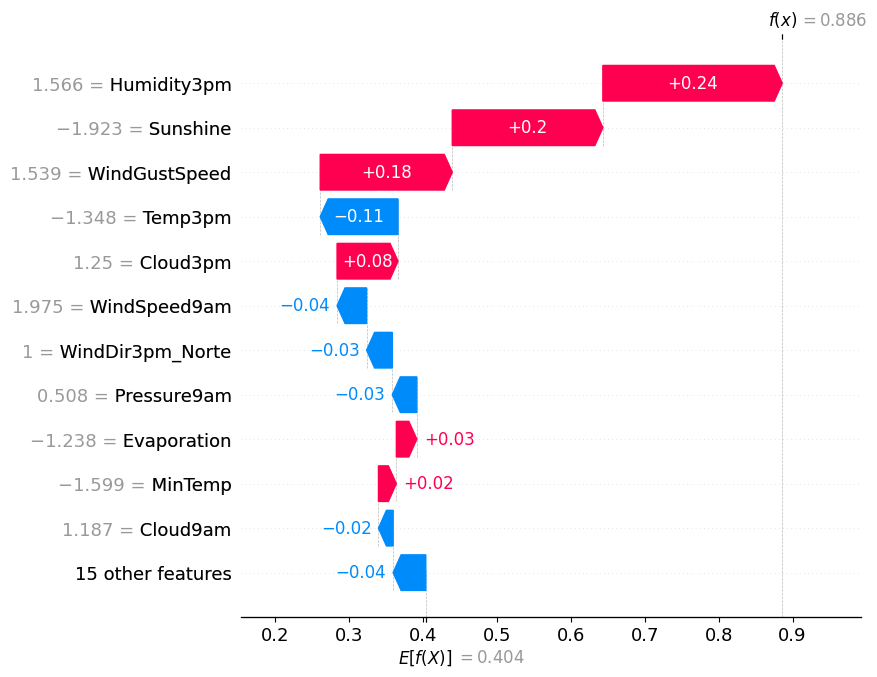

In [ ]:
# Crear un objeto Explanation
explanation_single = shap.Explanation(values=valores_shap_NN[0], base_values=explainer_NN.expected_value, feature_names=X_train_z.columns, data=X_test_z)

# Crear el gráfico de cascada para la explicación seleccionada
shap.plots.waterfall(explanation_single[0], max_display=12)

In [ ]:
# Inicializar la extensión JS para SHAP
shap.initjs()

# Force plot de la fila 0:
shap.force_plot(explainer_NN.expected_value, valores_shap_NN[0][0], X_test_clasificacion_z.iloc[0], feature_names=X_train_z.columns, figsize=(18, 4), \
                text_rotation=45)

Explicación de la predicción hecha sobre el evento correspondiente a la fila 1 de nuestro dataset de test. Podemos notar en el gráfico de fuerza y en el de cascada, que obtenemos una predicción de 0.85, "empujada" una probabilidad alta basada en Humidity3pm y WindGustSpeed, mientras baja principalmente por Temp3pm.

#### Global:

In [ ]:
explainer_NN = shap.KernelExplainer(redes_neuronales_clas_final.model, X_train_z[:100])
valores_shap_NN = explainer_NN.shap_values(X_test_z[:100])

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
# Crear un objeto Explanation
explanation_NN = shap.Explanation(values=valores_shap_NN[0], base_values=explainer_NN.expected_value, feature_names=X_train_z.columns, data=X_test_z[:100])

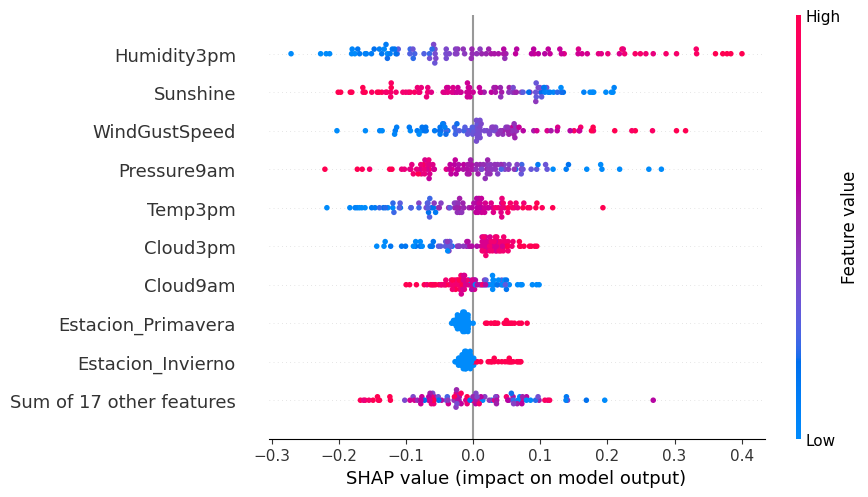

In [ ]:
# Grafico de abejas:
shap.plots.beeswarm(explanation_NN)

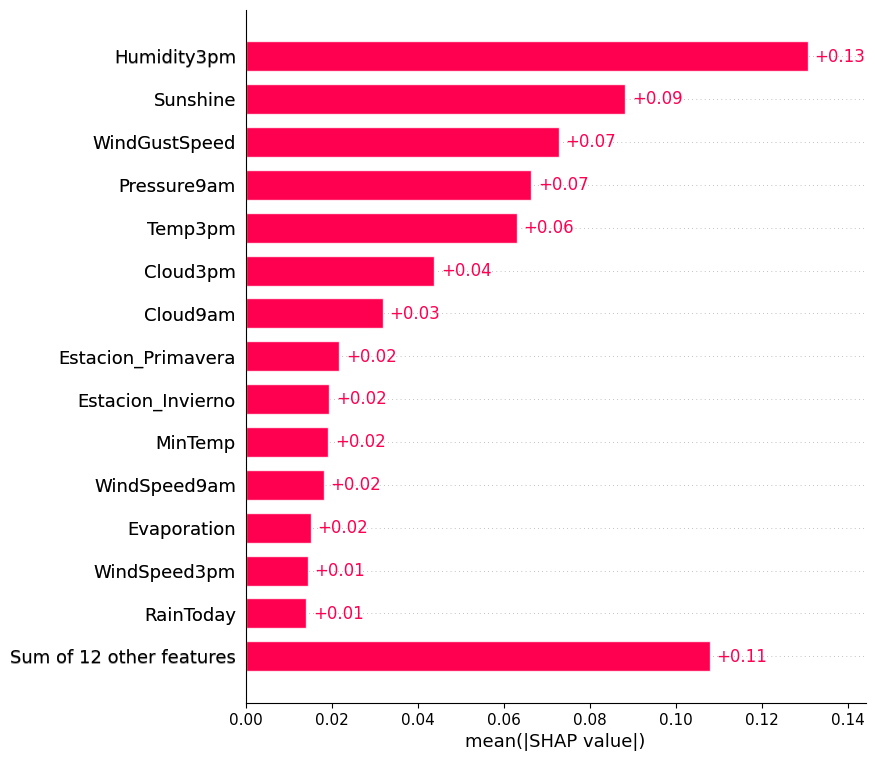

In [ ]:
# Grafico de barras
shap.plots.bar(explanation_NN, 15)

* Explicación de la predicciones globales del modelo. Podemos notar que Humidity afecta en gran medida para clasificar hacia ambas clases. Luego las 2 siguientes, Temp3pm y WindGustDir tienen mayor peso a la hora de clasificar de manera positiva. Pareciera que en general muchas más variables son influyentes en comparación a la regresión lineal.

## Regresión:

En primera instancia se van a hacer pruebas variando las arquitecturas un poco, y las epocas.

### Arquitectura 1:

In [ ]:
class NeuralNetworkRegressorTensorFlow:
    def __init__(self):
        self.model = self.build_model()

    def build_model(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(16, activation='relu', input_shape=(26,)),  # 26 features
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(1)])
        model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error', 'mean_squared_error'])
        print("Número de parámetros:", model.count_params())
        return model

    # Modificamos el fit porque queremos poder ver otras metricas durante las epocas de entrenamiento como el r2 y el rmse
    def fit(self, X, y, epochs=200):

        X = np.array(X)
        y = np.array(y)

        # Creamos el diccionario para almacenar todas las metricas que nos interesan
        history = {'loss': [], 'r2_ajustado': [], 'mean_absolute_error': [], 'mean_squared_error': [], 'root_mean_squared_error': [], 'mean_squared_error_metrica': []}

        # Y en vez de usar una vez el .fit del modelo de tf con todas las epocas vamos a iterar tantas veces como epocas queramos
        # haciendo uso del .fit de tf con una epoca sola hasta llegar al nro deseado
        for epoch in range(epochs):
            print(f'Epoca: {epoch+1}/{epochs}:')
            historia_epoca = self.model.fit(X, y, epochs=1, verbose=0)

            # Calculamos las metricas
            y_pred_epoca = self.predict(X)
            loss = historia_epoca.history['loss'][0]
            r2_epoca = r2_score(y, y_pred_epoca)
            r2_ajustado_epoca = r2_ajustado(X, y, r2_epoca)

            mae = mean_absolute_error(y, y_pred_epoca)
            mse = mean_squared_error(y, y_pred_epoca)

            # Almacenamos las métricas en el diccionario
            history['loss'].append(loss)
            history['r2_ajustado'].append(r2_ajustado_epoca)
            history['mean_absolute_error'].append(mae)
            history['mean_squared_error_metrica'].append(historia_epoca.history['mean_squared_error'][0])
            # history['mean_squared_error'].append(mse)
            history['root_mean_squared_error'].append(np.sqrt(mse))



            print(f'loss/mse: {loss} - r2_ajustado: {r2_ajustado_epoca}')

        # Visualizar la evolución de las métricas
        self.plot_metrics(range(epochs), history['r2_ajustado'], history['loss'])

        return history

    def plot_metrics(self, epochs, r2_values, loss_values):
        plt.figure(figsize=(12, 6))

        # Gráfico para R2
        plt.plot(epochs, r2_values, label='R2')
        plt.title('Evolucion del R2 Ajustado')
        plt.xlabel('Epocas')
        plt.ylabel('R2 Ajustado')
        plt.legend()
        plt.show()

        # Gráfico para pérdida
        plt.figure(figsize=(12, 6))
        plt.plot(epochs, loss_values, label='Loss', color='red')
        plt.title('Evolucion de la funcion de perdida')
        plt.xlabel('Epocas')
        plt.ylabel('MSE')
        plt.legend()
        plt.show()

    def predict(self, X):
        X = np.array(X)
        predictions = self.model.predict(X)
        return predictions

#### Modelo 1:

Entrenamiento:

Número de parámetros: 721
Epoca: 1/500:
400/400 [==============================] - 1s 2ms/step
loss/mse: 0.8811225891113281 - r2_ajustado: 0.21
Epoca: 2/500:
400/400 [==============================] - 1s 2ms/step
loss/mse: 0.7645784020423889 - r2_ajustado: 0.26
Epoca: 3/500:
400/400 [==============================] - 1s 2ms/step
loss/mse: 0.7326174974441528 - r2_ajustado: 0.29
Epoca: 4/500:
400/400 [==============================] - 1s 1ms/step
loss/mse: 0.710610568523407 - r2_ajustado: 0.3
Epoca: 5/500:
400/400 [==============================] - 1s 2ms/step
loss/mse: 0.6957216858863831 - r2_ajustado: 0.32
Epoca: 6/500:
400/400 [==============================] - 1s 1ms/step
loss/mse: 0.6827784776687622 - r2_ajustado: 0.32
Epoca: 7/500:
400/400 [==============================] - 1s 2ms/step
loss/mse: 0.6699557304382324 - r2_ajustado: 0.32
Epoca: 8/500:
400/400 [==============================] - 1s 2ms/step
loss/mse: 0.6638098359107971 - r2_ajustado: 0.35
Epoca: 9/500:
400/400 [=========

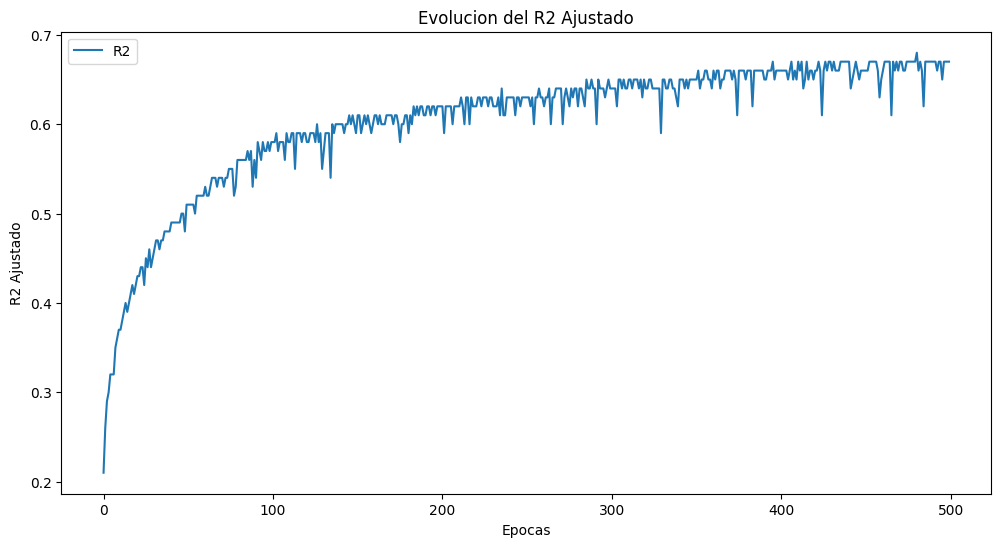

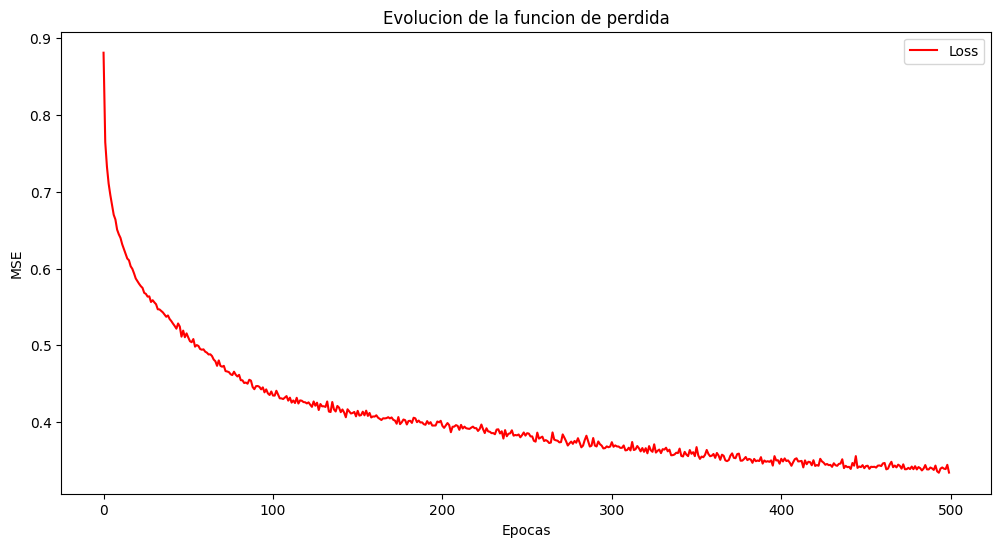

In [ ]:
# Crear una instancia de la clase
red_neuronal_regresion_1 = NeuralNetworkRegressorTensorFlow()

# Llamar al método fit
error_regresion_1 = red_neuronal_regresion_1.fit(X_train_z, y_train, epochs=500)

Predicciones:

In [ ]:
# Predicciones TRAIN:
y_pred_train_rneuronal_1 = red_neuronal_regresion_1.predict(X_train_z)

# Predicciones TEST:
y_pred_test_rneuronal_1 = red_neuronal_regresion_1.predict(X_test_z)

100/100 [==============================] - 0s 2ms/step


Metricas:

In [ ]:
# Calcular el Error Cuadrático Medio (MSE)
mse_test_rneuronal_1 = mean_squared_error(y_test, y_pred_test_rneuronal_1)
mse_train_rneuronal_1 = mean_squared_error(y_train, y_pred_train_rneuronal_1)

# Calcular el Error Cuadrático Medio de la Raíz (RMSE)
rmse_test_rneuronal_1 = np.sqrt(mse_test_rneuronal_1)
rmse_train_rneuronal_1 = np.sqrt(mse_train_rneuronal_1)

# Calcular el Error Absoluto Medio (MAE)
mae_test_rneuronal_1 = mean_absolute_error(y_test, y_pred_test_rneuronal_1)
mae_train_rneuronal_1 = mean_absolute_error(y_train, y_pred_train_rneuronal_1)

r2_prueba_rneuronal_1 = r2_score(y_test, y_pred_test_rneuronal_1)
r2_entrenamiento_rneuronal_1 = r2_score(y_train, y_pred_train_rneuronal_1)
r2_ajustado_prueba_rneuronal_1 = r2_ajustado(X_test_z, y_test, r2_prueba_rneuronal_1)
r2_ajustado_entrenamiento_rneuronal_1 = r2_ajustado(X_train_z, y_train, r2_entrenamiento_rneuronal_1)

print("---------------------------")
print(f"MSE TEST: {mse_test_rneuronal_1:.2f}")
print(f"MSE TRAIN: {mse_train_rneuronal_1:.2f}")
print("---------------------------")
print(f"RMSE TEST: {rmse_test_rneuronal_1:.2f}")
print(f"RMSE TRAIN: {rmse_train_rneuronal_1:.2f}")
print("---------------------------")
print(f"MAE TEST: {mae_test_rneuronal_1:.2f}")
print(f"MAE TRAIN: {mae_train_rneuronal_1:.2f}")
print("---------------------------")
print(f'R2 AJUSTADO TEST: {r2_ajustado_prueba_rneuronal_1}')
print(f'R2 AJUSTADO TRAIN: {r2_ajustado_entrenamiento_rneuronal_1}')

---------------------------
MSE TEST: 0.66
MSE TRAIN: 0.33
---------------------------
RMSE TEST: 0.81
RMSE TRAIN: 0.57
---------------------------
MAE TEST: 0.34
MAE TRAIN: 0.28
---------------------------
R2 AJUSTADO TEST: -0.0
R2 AJUSTADO TRAIN: 0.67


Modelo con metricas muy malas, ni lo consideramos sobre todo por el R2 Ajustado de test.

In [ ]:
# Tabla que usaremos para comparar metricas de modelos:
indices = ['mae_train', 'mae_test', 'r2_ajustado_train', 'r2_ajustado_test']
rn_regresion_comparacion = pd.DataFrame(index=indices)
# Los datos al cuadro se ingresan asi solo por una cuestion de que se agrego a ultimo momento con la intencion de dejar
# mas clara la comparacion entre modelos y ya no habia tiempo de correrlos todos para ingresarlos por medio de las variables
rn_regresion_comparacion['arq1_mod1 | 500 epocas'] = [0.28, 0.34, 0.67, 0]
rn_regresion_comparacion

arq1_mod1 | 500 epocas
mae_train                            0.28
mae_test                             0.34
r2_ajustado_train                    0.67
r2_ajustado_test                     0.00

### Arquitectura 2:

In [ ]:
class NeuralNetworkRegressorTensorFlow:
    def __init__(self):
        self.model = self.build_model()

    def build_model(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(4, activation='relu', input_shape=(26,)),
            tf.keras.layers.Dense(1)])
        model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error', 'mean_squared_error'])
        print("Número de parámetros:", model.count_params())
        return model

    # Modificamos el fit porque queremos poder ver otras metricas durante las epocas de entrenamiento como el r2 y el rmse
    def fit(self, X, y, epochs=200):

        X = np.array(X)
        y = np.array(y)

        # Creamos el diccionario para almacenar todas las metricas que nos interesan
        history = {'loss': [], 'r2_ajustado': [], 'mean_absolute_error': [], 'mean_squared_error': [], 'root_mean_squared_error': [], 'mean_squared_error_metrica': []}

        # Y en vez de usar una vez el .fit del modelo de tf con todas las epocas vamos a iterar tantas veces como epocas queramos
        # haciendo uso del .fit de tf con una epoca sola hasta llegar al nro deseado
        for epoch in range(epochs):
            print(f'Epoca: {epoch+1}/{epochs}:')
            historia_epoca = self.model.fit(X, y, epochs=1, verbose=0)

            # Calculamos las metricas
            y_pred_epoca = self.predict(X)
            loss = historia_epoca.history['loss'][0]
            r2_epoca = r2_score(y, y_pred_epoca)
            r2_ajustado_epoca = r2_ajustado(X, y, r2_epoca)

            mae = mean_absolute_error(y, y_pred_epoca)
            mse = mean_squared_error(y, y_pred_epoca)

            # Almacenamos las métricas en el diccionario
            history['loss'].append(loss)
            history['r2_ajustado'].append(r2_ajustado_epoca)
            history['mean_absolute_error'].append(mae)
            history['mean_squared_error_metrica'].append(historia_epoca.history['mean_squared_error'][0])
            # history['mean_squared_error'].append(mse)
            history['root_mean_squared_error'].append(np.sqrt(mse))



            print(f'loss/mse: {loss} - r2_ajustado: {r2_ajustado_epoca}')

        # Visualizar la evolución de las métricas
        self.plot_metrics(range(epochs), history['r2_ajustado'], history['loss'])

        return history

    def plot_metrics(self, epochs, r2_values, loss_values):
        plt.figure(figsize=(12, 6))

        # Gráfico para R2
        plt.plot(epochs, r2_values, label='R2 Ajustado')
        plt.title('Evolucion del R2 Ajustado')
        plt.xlabel('Epocas')
        plt.ylabel('R2 Ajustado')
        plt.legend()
        plt.show()

        # Gráfico para pérdida
        plt.figure(figsize=(12, 6))
        plt.plot(epochs, loss_values, label='Loss', color='red')
        plt.title('Evolucion de la funcion de perdida')
        plt.xlabel('Epocas')
        plt.ylabel('MSE')
        plt.legend()
        plt.show()

    def predict(self, X):
        X = np.array(X)
        predictions = self.model.predict(X)
        return predictions

#### Modelo 1:

Entrenamiento:

Número de parámetros: 113
Epoca: 1/500:
400/400 [==============================] - 2s 4ms/step
loss/mse: 1.2503972053527832 - r2_ajustado: 0.04
Epoca: 2/500:
400/400 [==============================] - 2s 4ms/step
loss/mse: 0.8901996612548828 - r2_ajustado: 0.16
Epoca: 3/500:
400/400 [==============================] - 1s 3ms/step
loss/mse: 0.816537082195282 - r2_ajustado: 0.2
Epoca: 4/500:
400/400 [==============================] - 1s 2ms/step
loss/mse: 0.7822697758674622 - r2_ajustado: 0.23
Epoca: 5/500:
400/400 [==============================] - 1s 2ms/step
loss/mse: 0.7638183236122131 - r2_ajustado: 0.25
Epoca: 6/500:
400/400 [==============================] - 1s 2ms/step
loss/mse: 0.7505896687507629 - r2_ajustado: 0.26
Epoca: 7/500:
400/400 [==============================] - 1s 2ms/step
loss/mse: 0.7428924441337585 - r2_ajustado: 0.26
Epoca: 8/500:
400/400 [==============================] - 1s 3ms/step
loss/mse: 0.7372083067893982 - r2_ajustado: 0.27
Epoca: 9/500:
400/400 [=========

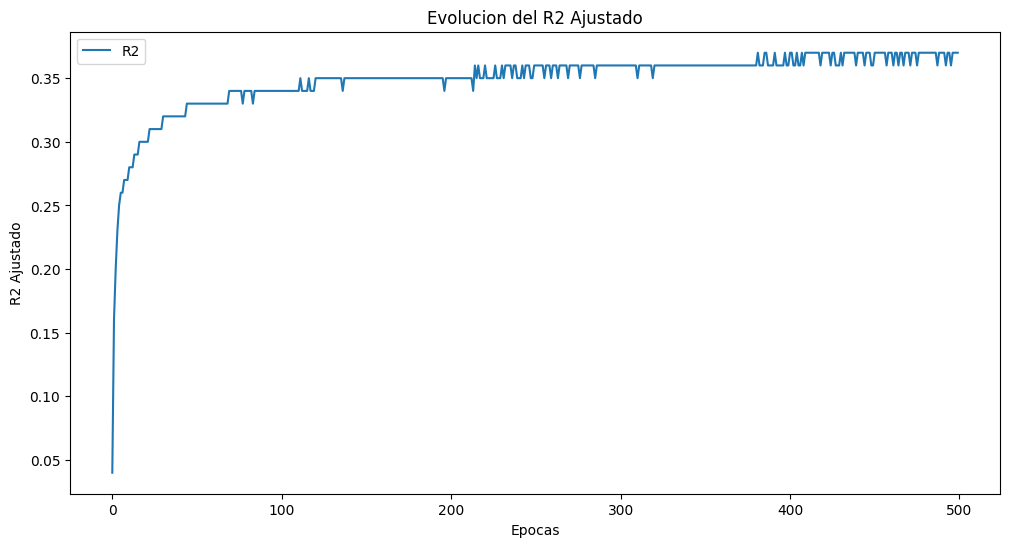

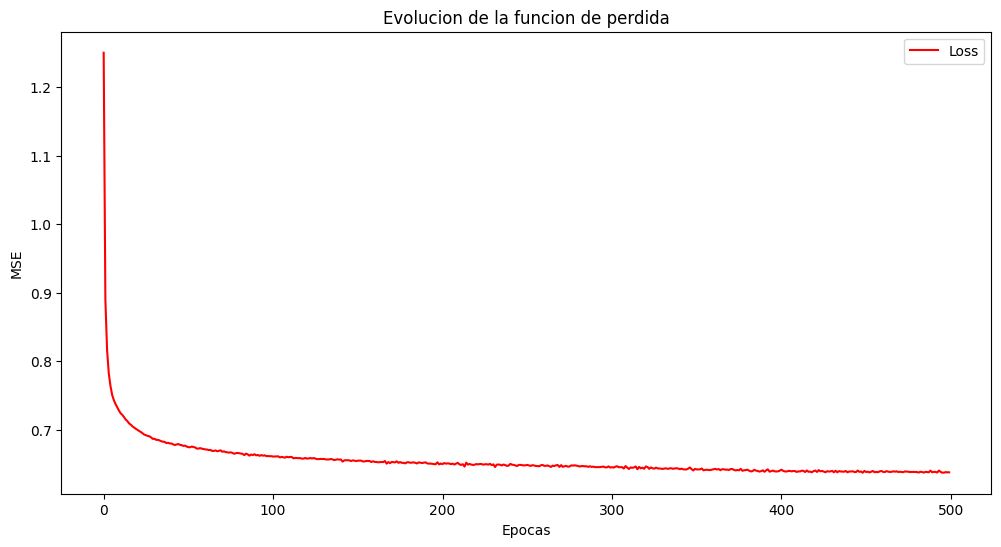

In [ ]:
# Crear una instancia de la clase
red_neuronal_regresion_1 = NeuralNetworkRegressorTensorFlow()

# Llamar al método fit
error_regresion_1 = red_neuronal_regresion_1.fit(X_train_z, y_train, epochs=500)

Predicciones:

In [ ]:
# Predicciones TRAIN:
y_pred_train_rneuronal_1 = red_neuronal_regresion_1.predict(X_train_z)

# Predicciones TEST:
y_pred_test_rneuronal_1 = red_neuronal_regresion_1.predict(X_test_z)

100/100 [==============================] - 1s 6ms/step


Metricas:

In [ ]:
# Calcular el Error Cuadrático Medio (MSE)
mse_test_rneuronal_1 = mean_squared_error(y_test, y_pred_test_rneuronal_1)
mse_train_rneuronal_1 = mean_squared_error(y_train, y_pred_train_rneuronal_1)

# Calcular el Error Cuadrático Medio de la Raíz (RMSE)
rmse_test_rneuronal_1 = np.sqrt(mse_test_rneuronal_1)
rmse_train_rneuronal_1 = np.sqrt(mse_train_rneuronal_1)

# Calcular el Error Absoluto Medio (MAE)
mae_test_rneuronal_1 = mean_absolute_error(y_test, y_pred_test_rneuronal_1)
mae_train_rneuronal_1 = mean_absolute_error(y_train, y_pred_train_rneuronal_1)

r2_prueba_rneuronal_1 = r2_score(y_test, y_pred_test_rneuronal_1)
r2_entrenamiento_rneuronal_1 = r2_score(y_train, y_pred_train_rneuronal_1)
r2_ajustado_prueba_rneuronal_1 = r2_ajustado(X_test_z, y_test, r2_prueba_rneuronal_1)
r2_ajustado_entrenamiento_rneuronal_1 = r2_ajustado(X_train_z, y_train, r2_entrenamiento_rneuronal_1)

print("---------------------------")
print(f"MSE TRAIN: {mse_train_rneuronal_1:.2f}")
print(f"MSE TEST: {mse_test_rneuronal_1:.2f}")
print("---------------------------")
print(f"RMSE TRAIN: {rmse_train_rneuronal_1:.2f}")
print(f"RMSE TEST: {rmse_test_rneuronal_1:.2f}")
print("---------------------------")
print(f"MAE TRAIN: {mae_train_rneuronal_1:.2f}")
print(f"MAE TEST: {mae_test_rneuronal_1:.2f}")
print("---------------------------")
print(f'R2 AJUSTADO TRAIN: {r2_ajustado_entrenamiento_rneuronal_1}')
print(f'R2 AJUSTADO TEST: {r2_ajustado_prueba_rneuronal_1}')

---------------------------
MSE TRAIN: 0.63
MSE TEST: 0.47
---------------------------
RMSE TRAIN: 0.80
RMSE TEST: 0.69
---------------------------
MAE TRAIN: 0.36
MAE TEST: 0.33
---------------------------
R2 AJUSTADO TRAIN: 0.37
R2 AJUSTADO TEST: 0.29


Mucha diferencia en R2 Ajustado. Puede que este un poco sobre ajustado. Por el momento supera al mejor de regresion lineal.

In [ ]:
rn_regresion_comparacion['arq2_mod1 | 500 epocas'] = [0.36, 0.33, 0.37, 0.29]
rn_regresion_comparacion

arq1_mod1 | 500 epocas  arq2_mod1 | 500 epocas
mae_train                            0.28                    0.36
mae_test                             0.34                    0.33
r2_ajustado_train                    0.67                    0.37
r2_ajustado_test                     0.00                    0.29

#### Modelo 2:

Entrenamiento:

Streaming output truncated to the last 5000 lines.
400/400 [==============================] - 1s 3ms/step
loss/mse: 0.5749064087867737 - r2_ajustado: 0.44
Epoca: 1335/3000:
400/400 [==============================] - 1s 3ms/step
loss/mse: 0.5714470744132996 - r2_ajustado: 0.43
Epoca: 1336/3000:
400/400 [==============================] - 1s 3ms/step
loss/mse: 0.573782205581665 - r2_ajustado: 0.43
Epoca: 1337/3000:
400/400 [==============================] - 1s 2ms/step
loss/mse: 0.5742377042770386 - r2_ajustado: 0.43
Epoca: 1338/3000:
400/400 [==============================] - 1s 2ms/step
loss/mse: 0.5742468237876892 - r2_ajustado: 0.43
Epoca: 1339/3000:
400/400 [==============================] - 1s 2ms/step
loss/mse: 0.5754562020301819 - r2_ajustado: 0.43
Epoca: 1340/3000:
400/400 [==============================] - 1s 2ms/step
loss/mse: 0.5734383463859558 - r2_ajustado: 0.43
Epoca: 1341/3000:
400/400 [==============================] - 1s 3ms/step
loss/mse: 0.571587860584259 - r2_ajustado

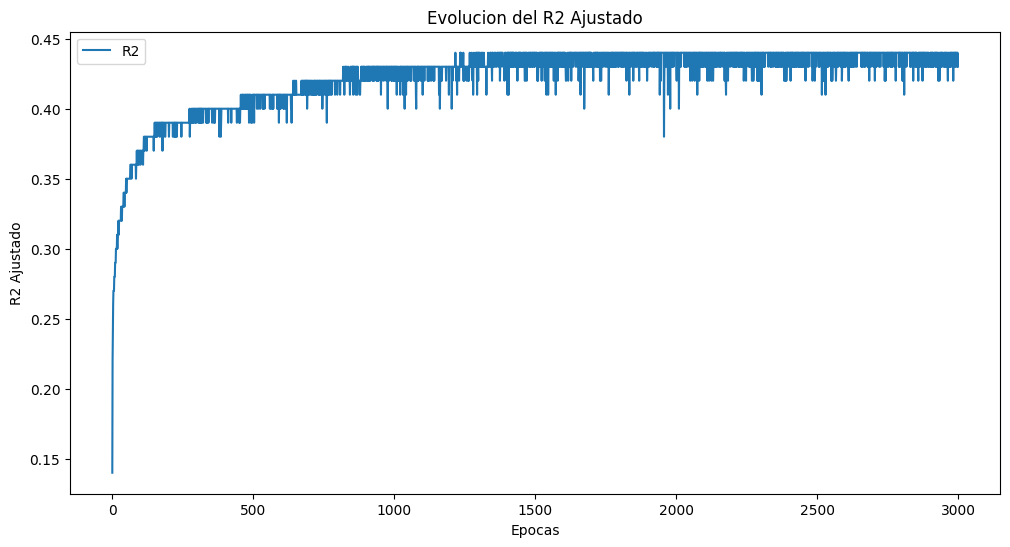

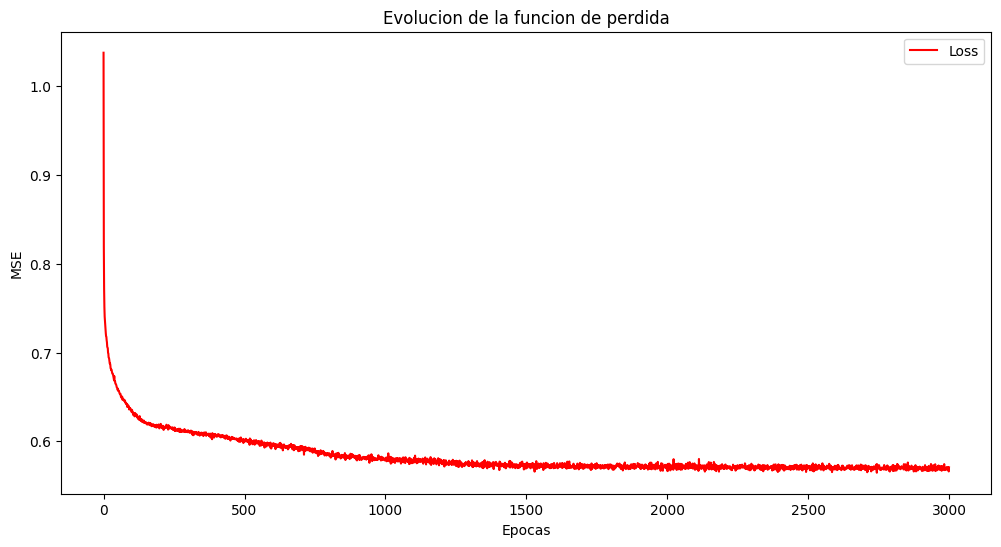

In [ ]:
# Crear una instancia de la clase
red_neuronal_regresion_2 = NeuralNetworkRegressorTensorFlow()

# Llamar al método fit
error_regresion_2 = red_neuronal_regresion_2.fit(X_train_z, y_train, epochs=3000)

Predicciones:

In [ ]:
# Predicciones TRAIN:
y_pred_train_rneuronal_2 = red_neuronal_regresion_2.predict(X_train_z)

# Predicciones TEST:
y_pred_test_rneuronal_2 = red_neuronal_regresion_2.predict(X_test_z)

100/100 [==============================] - 0s 2ms/step


Metricas:

In [ ]:
# Calcular el Error Cuadrático Medio (MSE)
mse_test_rneuronal_2 = mean_squared_error(y_test, y_pred_test_rneuronal_2)
mse_train_rneuronal_2 = mean_squared_error(y_train, y_pred_train_rneuronal_2)

# Calcular el Error Cuadrático Medio de la Raíz (RMSE)
rmse_test_rneuronal_2 = np.sqrt(mse_test_rneuronal_2)
rmse_train_rneuronal_2 = np.sqrt(mse_train_rneuronal_2)

# Calcular el Error Absoluto Medio (MAE)
mae_test_rneuronal_2 = mean_absolute_error(y_test, y_pred_test_rneuronal_2)
mae_train_rneuronal_2 = mean_absolute_error(y_train, y_pred_train_rneuronal_2)

r2_prueba_rneuronal_2 = r2_score(y_test, y_pred_test_rneuronal_2)
r2_entrenamiento_rneuronal_2 = r2_score(y_train, y_pred_train_rneuronal_2)
r2_ajustado_prueba_rneuronal_2 = r2_ajustado(X_test_z, y_test, r2_prueba_rneuronal_2)
r2_ajustado_entrenamiento_rneuronal_2 = r2_ajustado(X_train_z, y_train, r2_entrenamiento_rneuronal_2)

print("---------------------------")
print(f"MSE TRAIN: {mse_train_rneuronal_2:.2f}")
print(f"MSE TEST: {mse_test_rneuronal_2:.2f}")
print("---------------------------")
print(f"RMSE TRAIN: {rmse_train_rneuronal_2:.2f}")
print(f"RMSE TEST: {rmse_test_rneuronal_2:.2f}")
print("---------------------------")
print(f"MAE TRAIN: {mae_train_rneuronal_2:.2f}")
print(f"MAE TEST: {mae_test_rneuronal_2:.2f}")
print("---------------------------")
print(f'R2 AJUSTADO TRAIN: {r2_ajustado_entrenamiento_rneuronal_2}')
print(f'R2 AJUSTADO TEST: {r2_ajustado_prueba_rneuronal_2}')

---------------------------
MSE TRAIN: 0.57
MSE TEST: 0.52
---------------------------
RMSE TRAIN: 0.76
RMSE TEST: 0.72
---------------------------
MAE TRAIN: 0.31
MAE TEST: 0.31
---------------------------
R2 AJUSTADO TRAIN: 0.43
R2 AJUSTADO TEST: 0.22


El R2 ajustado de test tambien es aun mas inferior al de train.

In [ ]:
rn_regresion_comparacion['arq2_mod2 | 3000 epocas'] = [0.31, 0.31, 0.43, 0.22]
rn_regresion_comparacion

arq1_mod1 | 500 epocas  arq2_mod1 | 500 epocas  \
mae_train                            0.28                    0.36   
mae_test                             0.34                    0.33   
r2_ajustado_train                    0.67                    0.37   
r2_ajustado_test                     0.00                    0.29   

                   arq2_mod2 | 3000 epocas  
mae_train                             0.31  
mae_test                              0.31  
r2_ajustado_train                     0.43  
r2_ajustado_test                      0.22

#### Modelo 3:

Entrenamiento:

Número de parámetros: 113
Epoca: 1/300:
400/400 [==============================] - 6s 13ms/step
loss/mse: 1.5514923334121704 - r2_ajustado: -0.04
Epoca: 2/300:
400/400 [==============================] - 2s 6ms/step
loss/mse: 1.0034419298171997 - r2_ajustado: 0.02
Epoca: 3/300:
400/400 [==============================] - 3s 8ms/step
loss/mse: 0.9685700535774231 - r2_ajustado: 0.04
Epoca: 4/300:
400/400 [==============================] - 2s 4ms/step
loss/mse: 0.9456108808517456 - r2_ajustado: 0.06
Epoca: 5/300:
400/400 [==============================] - 4s 10ms/step
loss/mse: 0.9227551817893982 - r2_ajustado: 0.09
Epoca: 6/300:
400/400 [==============================] - 1s 4ms/step
loss/mse: 0.9012737274169922 - r2_ajustado: 0.11
Epoca: 7/300:
400/400 [==============================] - 2s 5ms/step
loss/mse: 0.883897066116333 - r2_ajustado: 0.12
Epoca: 8/300:
400/400 [==============================] - 3s 6ms/step
loss/mse: 0.8703886866569519 - r2_ajustado: 0.14
Epoca: 9/300:
400/400 [=====

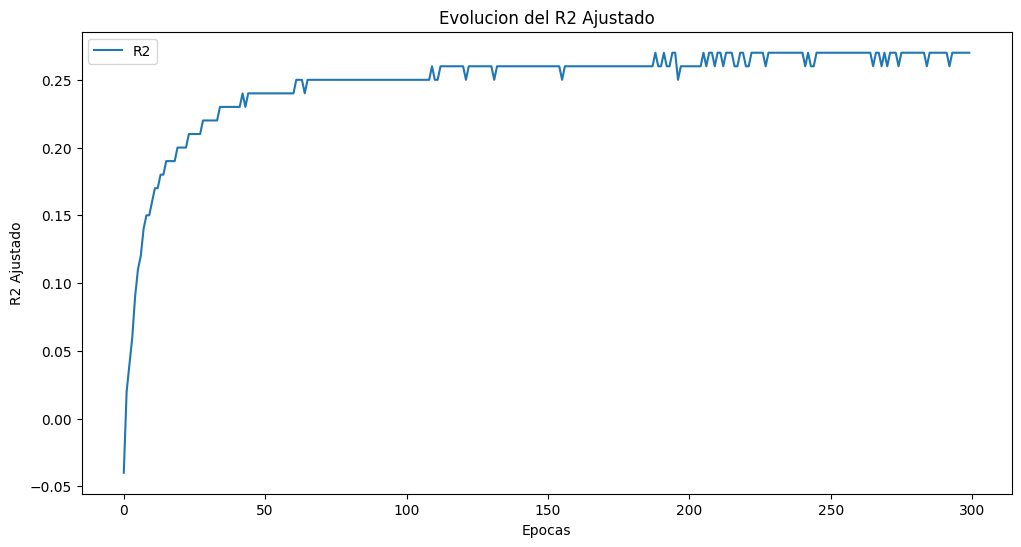

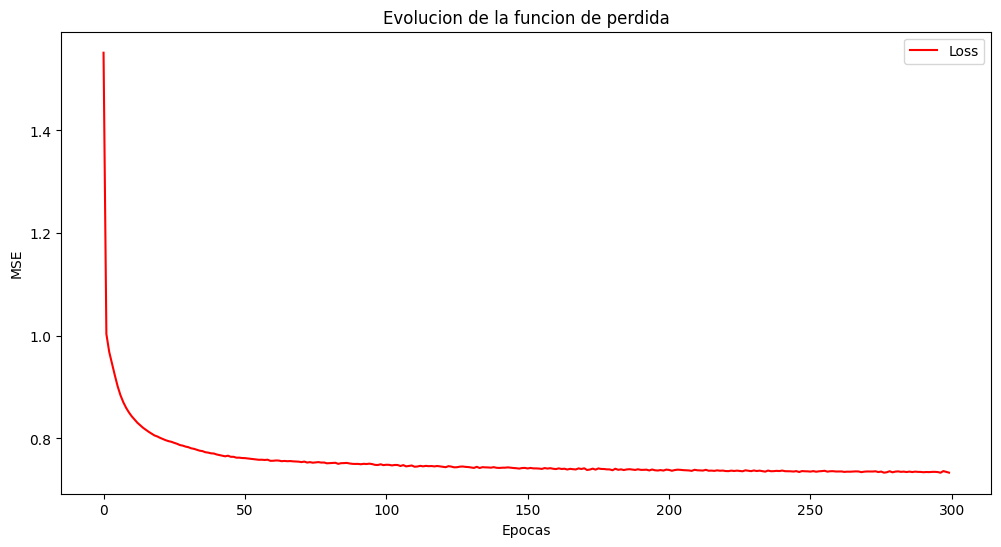

In [ ]:
# Crear una instancia de la clase
red_neuronal_regresion_3 = NeuralNetworkRegressorTensorFlow()

# Llamar al método fit
error_regresion_3 = red_neuronal_regresion_3.fit(X_train_z, y_train, epochs=300)

Predicciones:

In [ ]:
# Predicciones TRAIN:
y_pred_train_rneuronal_3 = red_neuronal_regresion_3.predict(X_train_z)

# Predicciones TEST:
y_pred_test_rneuronal_3 = red_neuronal_regresion_3.predict(X_test_z)

100/100 [==============================] - 1s 5ms/step


Metricas:

In [ ]:
# Calcular el Error Cuadrático Medio (MSE)
mse_test_rneuronal_3 = mean_squared_error(y_test, y_pred_test_rneuronal_3)
mse_train_rneuronal_3 = mean_squared_error(y_train, y_pred_train_rneuronal_3)

# Calcular el Error Cuadrático Medio de la Raíz (RMSE)
rmse_test_rneuronal_3 = np.sqrt(mse_test_rneuronal_3)
rmse_train_rneuronal_3 = np.sqrt(mse_train_rneuronal_3)

# Calcular el Error Absoluto Medio (MAE)
mae_test_rneuronal_3 = mean_absolute_error(y_test, y_pred_test_rneuronal_3)
mae_train_rneuronal_3 = mean_absolute_error(y_train, y_pred_train_rneuronal_3)

r2_prueba_rneuronal_3 = r2_score(y_test, y_pred_test_rneuronal_3)
r2_entrenamiento_rneuronal_3 = r2_score(y_train, y_pred_train_rneuronal_3)
r2_ajustado_prueba_rneuronal_3 = r2_ajustado(X_test_z, y_test, r2_prueba_rneuronal_3)
r2_ajustado_entrenamiento_rneuronal_3 = r2_ajustado(X_train_z, y_train, r2_entrenamiento_rneuronal_3)

print("---------------------------")
print(f"MSE TRAIN: {mse_train_rneuronal_3:.2f}")
print(f"MSE TEST: {mse_test_rneuronal_3:.2f}")
print("---------------------------")
print(f"RMSE TRAIN: {rmse_train_rneuronal_3:.2f}")
print(f"RMSE TEST: {rmse_test_rneuronal_3:.2f}")
print("---------------------------")
print(f"MAE TRAIN: {mae_train_rneuronal_3:.2f}")
print(f"MAE TEST: {mae_test_rneuronal_3:.2f}")
print("---------------------------")
print(f'R2 AJUSTADO TRAIN: {r2_ajustado_entrenamiento_rneuronal_3}')
print(f'R2 AJUSTADO TEST: {r2_ajustado_prueba_rneuronal_3}')

---------------------------
MSE TRAIN: 0.73
MSE TEST: 0.50
---------------------------
RMSE TRAIN: 0.86
RMSE TEST: 0.71
---------------------------
MAE TRAIN: 0.41
MAE TEST: 0.38
---------------------------
R2 AJUSTADO TRAIN: 0.27
R2 AJUSTADO TEST: 0.24


In [ ]:
rn_regresion_comparacion['arq2_mod3 | 300 epocas'] = [0.41, 0.38, 0.27, 0.24]
rn_regresion_comparacion

arq1_mod1 | 500 epocas  arq2_mod1 | 500 epocas  \
mae_train                            0.28                    0.36   
mae_test                             0.34                    0.33   
r2_ajustado_train                    0.67                    0.37   
r2_ajustado_test                     0.00                    0.29   

                   arq2_mod2 | 3000 epocas  arq2_mod3 | 300 epocas  
mae_train                             0.31                    0.41  
mae_test                              0.31                    0.38  
r2_ajustado_train                     0.43                    0.27  
r2_ajustado_test                      0.22                    0.24

### Arquitectura 3:

In [ ]:
class NeuralNetworkRegressorTensorFlow:
    def __init__(self):
        self.model = self.build_model()

    def build_model(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(10, activation='relu', input_shape=(26,)),
            tf.keras.layers.Dense(1)])
        model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error', 'mean_squared_error'])
        print("Número de parámetros:", model.count_params())
        return model

    # Modificamos el fit porque queremos poder ver otras metricas durante las epocas de entrenamiento como el r2 y el rmse
    def fit(self, X, y, lr=0.1, epochs=200):

        X = np.array(X)
        y = np.array(y)

        # Creamos el diccionario para almacenar todas las metricas que nos interesan
        history = {'loss': [], 'r2_ajustado': [], 'mean_absolute_error': [], 'mean_squared_error': [], 'root_mean_squared_error': [], 'mean_squared_error_metrica': []}

        # Y en vez de usar una vez el .fit del modelo de tf con todas las epocas vamos a iterar tantas veces como epocas queramos
        # haciendo uso del .fit de tf con una epoca sola hasta llegar al nro deseado
        for epoch in range(epochs):
            print(f'Epoca: {epoch+1}/{epochs}:')
            historia_epoca = self.model.fit(X, y, epochs=1, verbose=0)

            # Calculamos las metricas
            y_pred_epoca = self.predict(X)
            loss = historia_epoca.history['loss'][0]
            r2_epoca = r2_score(y, y_pred_epoca)
            r2_ajustado_epoca = r2_ajustado(X, y, r2_epoca)

            mae = mean_absolute_error(y, y_pred_epoca)
            mse = mean_squared_error(y, y_pred_epoca)

            # Almacenamos las métricas en el diccionario
            history['loss'].append(loss)
            history['r2_ajustado'].append(r2_ajustado_epoca)
            history['mean_absolute_error'].append(mae)
            history['mean_squared_error_metrica'].append(historia_epoca.history['mean_squared_error'][0])
            # history['mean_squared_error'].append(mse)
            history['root_mean_squared_error'].append(np.sqrt(mse))



            print(f'loss/mse: {loss} - r2_ajustado: {r2_ajustado_epoca}')

        # Visualizar la evolución de las métricas
        self.plot_metrics(range(epochs), history['r2_ajustado'], history['loss'])

        return history

    def plot_metrics(self, epochs, r2_values, loss_values):
        plt.figure(figsize=(12, 6))

        # Gráfico para R2
        plt.plot(epochs, r2_values, label='R2 Ajustado')
        plt.title('Evolucion del R2 Ajustado')
        plt.xlabel('Epocas')
        plt.ylabel('R2 Ajustado')
        plt.legend()
        plt.show()

        # Gráfico para pérdida
        plt.figure(figsize=(12, 6))
        plt.plot(epochs, loss_values, label='Loss', color='red')
        plt.title('Evolucion de la funcion de perdida')
        plt.xlabel('Epocas')
        plt.ylabel('MSE')
        plt.legend()
        plt.show()

    def predict(self, X):
        X = np.array(X)
        predictions = self.model.predict(X)
        return predictions

#### Modelo 1:

Entrenamiento:

Número de parámetros: 281
Epoca: 1/300:
400/400 [==============================] - 1s 2ms/step
loss/mse: 0.855923056602478 - r2_ajustado: 0.21
Epoca: 2/300:
400/400 [==============================] - 1s 2ms/step
loss/mse: 0.7674587368965149 - r2_ajustado: 0.25
Epoca: 3/300:
400/400 [==============================] - 1s 2ms/step
loss/mse: 0.7445890307426453 - r2_ajustado: 0.27
Epoca: 4/300:
400/400 [==============================] - 1s 2ms/step
loss/mse: 0.7332768440246582 - r2_ajustado: 0.28
Epoca: 5/300:
400/400 [==============================] - 1s 3ms/step
loss/mse: 0.7233566641807556 - r2_ajustado: 0.28
Epoca: 6/300:
400/400 [==============================] - 1s 2ms/step
loss/mse: 0.7158450484275818 - r2_ajustado: 0.29
Epoca: 7/300:
400/400 [==============================] - 1s 2ms/step
loss/mse: 0.7096315026283264 - r2_ajustado: 0.3
Epoca: 8/300:
400/400 [==============================] - 1s 2ms/step
loss/mse: 0.7053316831588745 - r2_ajustado: 0.3
Epoca: 9/300:
400/400 [==========

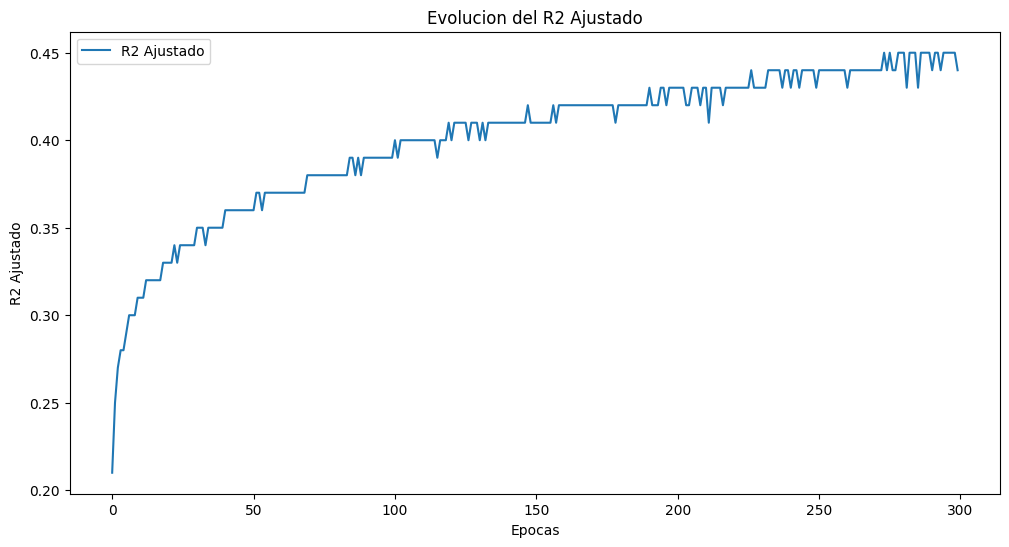

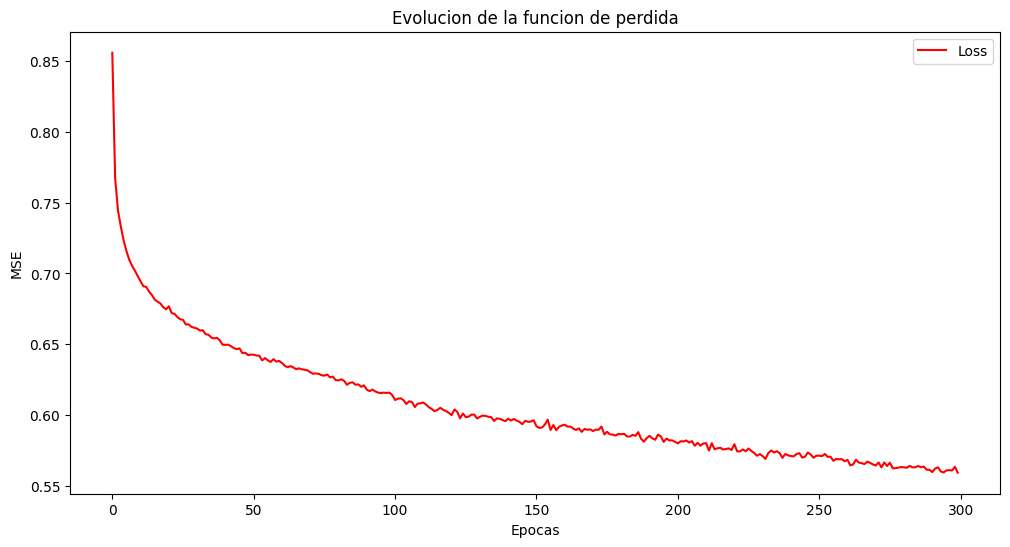

In [ ]:
# Crear una instancia de la clase
red_neuronal_regresion_1 = NeuralNetworkRegressorTensorFlow()

# Llamar al método fit
error_regresion_1 = red_neuronal_regresion_1.fit(X_train_z, y_train, epochs=300)

Predicciones:

In [ ]:
# Predicciones TRAIN:
y_pred_train_rneuronal_1 = red_neuronal_regresion_1.predict(X_train_z)

# Predicciones TEST:
y_pred_test_rneuronal_1 = red_neuronal_regresion_1.predict(X_test_z)

100/100 [==============================] - 0s 2ms/step


Metricas:

In [ ]:
# Calcular el Error Cuadrático Medio (MSE)
mse_test_rneuronal_1 = mean_squared_error(y_test, y_pred_test_rneuronal_1)
mse_train_rneuronal_1 = mean_squared_error(y_train, y_pred_train_rneuronal_1)

# Calcular el Error Cuadrático Medio de la Raíz (RMSE)
rmse_test_rneuronal_1 = np.sqrt(mse_test_rneuronal_1)
rmse_train_rneuronal_1 = np.sqrt(mse_train_rneuronal_1)

# Calcular el Error Absoluto Medio (MAE)
mae_test_rneuronal_1 = mean_absolute_error(y_test, y_pred_test_rneuronal_1)
mae_train_rneuronal_1 = mean_absolute_error(y_train, y_pred_train_rneuronal_1)

r2_prueba_rneuronal_1 = r2_score(y_test, y_pred_test_rneuronal_1)
r2_entrenamiento_rneuronal_1 = r2_score(y_train, y_pred_train_rneuronal_1)
r2_ajustado_prueba_rneuronal_1 = r2_ajustado(X_test_z, y_test, r2_prueba_rneuronal_1)
r2_ajustado_entrenamiento_rneuronal_1 = r2_ajustado(X_train_z, y_train, r2_entrenamiento_rneuronal_1)

print("---------------------------")
print(f"MSE TRAIN: {mse_train_rneuronal_1:.2f}")
print(f"MSE TEST: {mse_test_rneuronal_1:.2f}")
print("---------------------------")
print(f"RMSE TRAIN: {rmse_train_rneuronal_1:.2f}")
print(f"RMSE TEST: {rmse_test_rneuronal_1:.2f}")
print("---------------------------")
print(f"MAE TRAIN: {mae_train_rneuronal_1:.2f}")
print(f"MAE TEST: {mae_test_rneuronal_1:.2f}")
print("---------------------------")
print(f'R2 AJUSTADO TRAIN: {r2_ajustado_entrenamiento_rneuronal_1}')
print(f'R2 AJUSTADO TEST: {r2_ajustado_prueba_rneuronal_1}')

---------------------------
MSE TRAIN: 0.56
MSE TEST: 0.47
---------------------------
RMSE TRAIN: 0.75
RMSE TEST: 0.68
---------------------------
MAE TRAIN: 0.31
MAE TEST: 0.30
---------------------------
R2 AJUSTADO TRAIN: 0.44
R2 AJUSTADO TEST: 0.29


In [ ]:
rn_regresion_comparacion['arq3_mod1 | 300 epocas'] = [0.31, 0.30, 0.44, 0.29]
rn_regresion_comparacion

arq1_mod1 | 500 epocas  arq2_mod1 | 500 epocas  \
mae_train                            0.28                    0.36   
mae_test                             0.34                    0.33   
r2_ajustado_train                    0.67                    0.37   
r2_ajustado_test                     0.00                    0.29   

                   arq2_mod2 | 3000 epocas  arq2_mod3 | 300 epocas  \
mae_train                             0.31                    0.41   
mae_test                              0.31                    0.38   
r2_ajustado_train                     0.43                    0.27   
r2_ajustado_test                      0.22                    0.24   

                   arq3_mod1 | 300 epocas  
mae_train                            0.31  
mae_test                             0.30  
r2_ajustado_train                    0.44  
r2_ajustado_test                     0.29

#### Modelo 2:

Entrenamiento:

Número de parámetros: 281
Epoca: 1/1000:
400/400 [==============================] - 2s 5ms/step
loss/mse: 1.100611686706543 - r2_ajustado: 0.12
Epoca: 2/1000:
400/400 [==============================] - 3s 7ms/step
loss/mse: 0.8409150838851929 - r2_ajustado: 0.19
Epoca: 3/1000:
400/400 [==============================] - 1s 2ms/step
loss/mse: 0.7938402891159058 - r2_ajustado: 0.22
Epoca: 4/1000:
400/400 [==============================] - 1s 3ms/step
loss/mse: 0.7698811292648315 - r2_ajustado: 0.24
Epoca: 5/1000:
400/400 [==============================] - 1s 2ms/step
loss/mse: 0.7561439275741577 - r2_ajustado: 0.25
Epoca: 6/1000:
400/400 [==============================] - 1s 2ms/step
loss/mse: 0.7445194125175476 - r2_ajustado: 0.26
Epoca: 7/1000:
400/400 [==============================] - 1s 2ms/step
loss/mse: 0.7363552451133728 - r2_ajustado: 0.27
Epoca: 8/1000:
400/400 [==============================] - 1s 2ms/step
loss/mse: 0.7290747761726379 - r2_ajustado: 0.28
Epoca: 9/1000:
400/400 

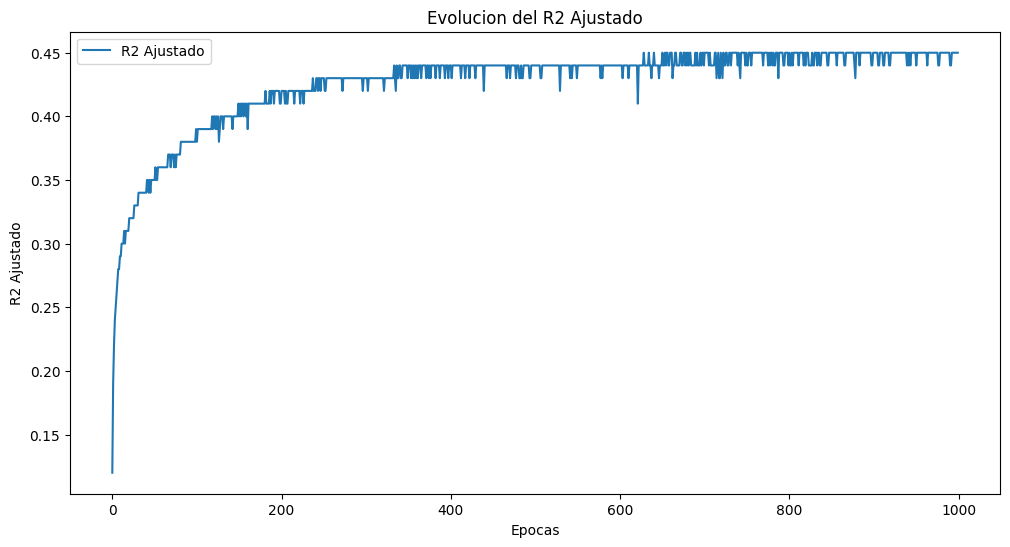

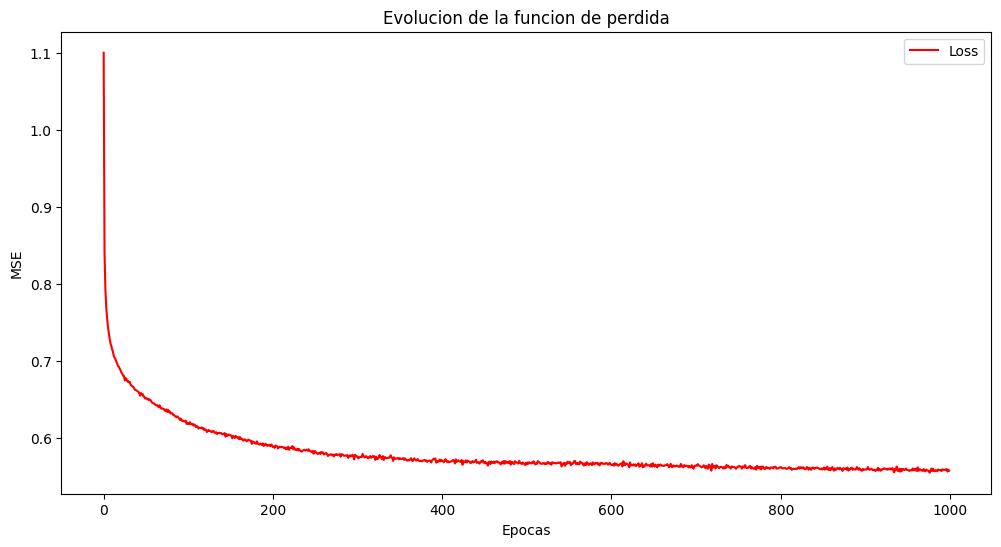

In [ ]:
# Crear una instancia de la clase
red_neuronal_regresion_2 = NeuralNetworkRegressorTensorFlow()

# Llamar al método fit
error_regresion_2 = red_neuronal_regresion_2.fit(X_train_z, y_train, epochs=1000)

Predicciones:

In [ ]:
# Predicciones TRAIN:
y_pred_train_rneuronal_2 = red_neuronal_regresion_2.predict(X_train_z)

# Predicciones TEST:
y_pred_test_rneuronal_2 = red_neuronal_regresion_2.predict(X_test_z)

100/100 [==============================] - 0s 2ms/step


Metricas:

In [ ]:
# Calcular el Error Cuadrático Medio (MSE)
mse_test_rneuronal_2 = mean_squared_error(y_test, y_pred_test_rneuronal_2)
mse_train_rneuronal_2 = mean_squared_error(y_train, y_pred_train_rneuronal_2)

# Calcular el Error Cuadrático Medio de la Raíz (RMSE)
rmse_test_rneuronal_2 = np.sqrt(mse_test_rneuronal_2)
rmse_train_rneuronal_2 = np.sqrt(mse_train_rneuronal_2)

# Calcular el Error Absoluto Medio (MAE)
mae_test_rneuronal_2 = mean_absolute_error(y_test, y_pred_test_rneuronal_2)
mae_train_rneuronal_2 = mean_absolute_error(y_train, y_pred_train_rneuronal_2)

r2_prueba_rneuronal_2 = r2_score(y_test, y_pred_test_rneuronal_2)
r2_entrenamiento_rneuronal_2 = r2_score(y_train, y_pred_train_rneuronal_2)
r2_ajustado_prueba_rneuronal_2 = r2_ajustado(X_test_z, y_test, r2_prueba_rneuronal_2)
r2_ajustado_entrenamiento_rneuronal_2 = r2_ajustado(X_train_z, y_train, r2_entrenamiento_rneuronal_2)

print("---------------------------")
print(f"MSE TRAIN: {mse_train_rneuronal_2:.2f}")
print(f"MSE TEST: {mse_test_rneuronal_2:.2f}")
print("---------------------------")
print(f"RMSE TRAIN: {rmse_train_rneuronal_2:.2f}")
print(f"RMSE TEST: {rmse_test_rneuronal_2:.2f}")
print("---------------------------")
print(f"MAE TRAIN: {mae_train_rneuronal_2:.2f}")
print(f"MAE TEST: {mae_test_rneuronal_2:.2f}")
print("---------------------------")
print(f'R2 AJUSTADO TRAIN: {r2_ajustado_entrenamiento_rneuronal_2}')
print(f'R2 AJUSTADO TEST: {r2_ajustado_prueba_rneuronal_2}')

---------------------------
MSE TRAIN: 0.55
MSE TEST: 0.46
---------------------------
RMSE TRAIN: 0.74
RMSE TEST: 0.68
---------------------------
MAE TRAIN: 0.33
MAE TEST: 0.32
---------------------------
R2 AJUSTADO TRAIN: 0.45
R2 AJUSTADO TEST: 0.3


In [ ]:
rn_regresion_comparacion['arq3_mod2 | 1000 epocas'] = [0.33, 0.32, 0.45, 0.3]
rn_regresion_comparacion

arq1_mod1 | 500 epocas  arq2_mod1 | 500 epocas  \
mae_train                            0.28                    0.36   
mae_test                             0.34                    0.33   
r2_ajustado_train                    0.67                    0.37   
r2_ajustado_test                     0.00                    0.29   

                   arq2_mod2 | 3000 epocas  arq2_mod3 | 300 epocas  \
mae_train                             0.31                    0.41   
mae_test                              0.31                    0.38   
r2_ajustado_train                     0.43                    0.27   
r2_ajustado_test                      0.22                    0.24   

                   arq3_mod1 | 300 epocas  arq3_mod2 | 1000 epocas  
mae_train                            0.31                     0.33  
mae_test                             0.30                     0.32  
r2_ajustado_train                    0.44                     0.45  
r2_ajustado_test                     0.29                     0.30

#### Modelo 3:

Entrenamiento:

Número de parámetros: 281
Epoca: 1/1500:
400/400 [==============================] - 1s 3ms/step
loss/mse: 0.9096860885620117 - r2_ajustado: 0.21
Epoca: 2/1500:
400/400 [==============================] - 1s 3ms/step
loss/mse: 0.7737338542938232 - r2_ajustado: 0.25
Epoca: 3/1500:
400/400 [==============================] - 1s 2ms/step
loss/mse: 0.7489361763000488 - r2_ajustado: 0.26
Epoca: 4/1500:
400/400 [==============================] - 1s 2ms/step
loss/mse: 0.7340019345283508 - r2_ajustado: 0.27
Epoca: 5/1500:
400/400 [==============================] - 1s 2ms/step
loss/mse: 0.7260057926177979 - r2_ajustado: 0.28
Epoca: 6/1500:
400/400 [==============================] - 1s 2ms/step
loss/mse: 0.71968013048172 - r2_ajustado: 0.29
Epoca: 7/1500:
400/400 [==============================] - 1s 2ms/step
loss/mse: 0.7140898704528809 - r2_ajustado: 0.29
Epoca: 8/1500:
400/400 [==============================] - 1s 3ms/step
loss/mse: 0.7102225422859192 - r2_ajustado: 0.3
Epoca: 9/1500:
400/400 [=

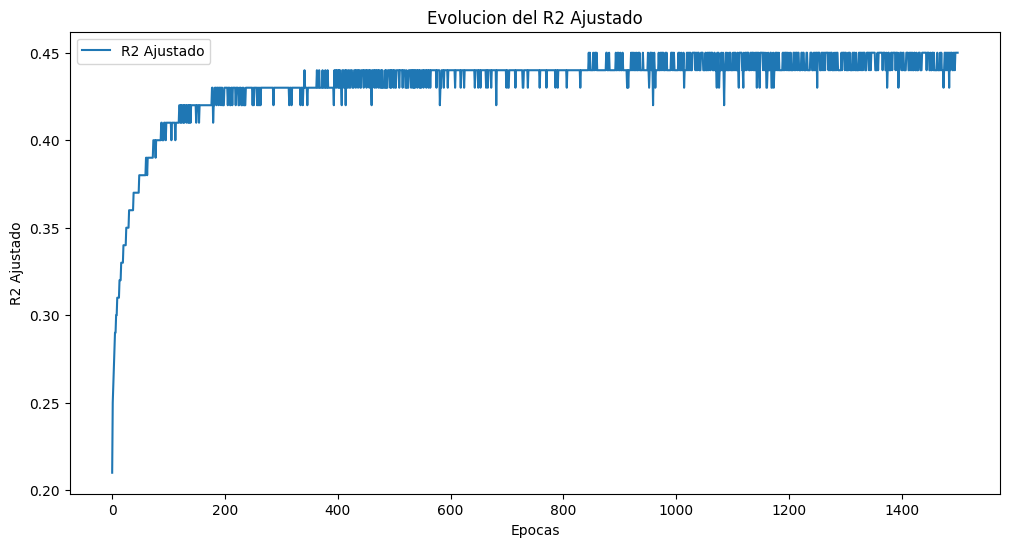

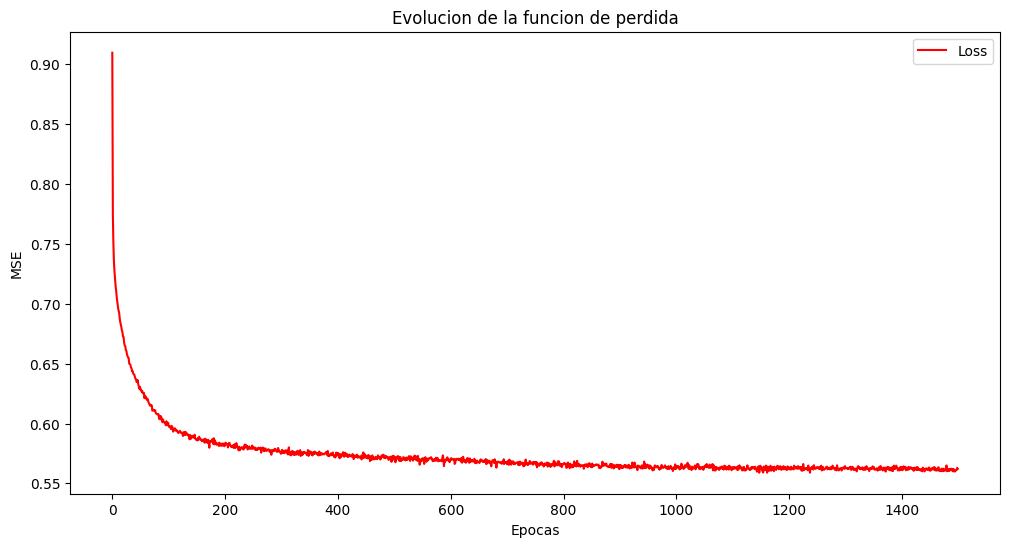

In [ ]:
# Crear una instancia de la clase
red_neuronal_regresion_3 = NeuralNetworkRegressorTensorFlow()

# Llamar al método fit
error_regresion_3 = red_neuronal_regresion_3.fit(X_train_z, y_train, epochs=1500)

Predicciones:

In [ ]:
# Predicciones TRAIN:
y_pred_train_rneuronal_3 = red_neuronal_regresion_3.predict(X_train_z)

# Predicciones TEST:
y_pred_test_rneuronal_3 = red_neuronal_regresion_3.predict(X_test_z)

100/100 [==============================] - 0s 2ms/step


Metricas:

In [ ]:
# Calcular el Error Cuadrático Medio (MSE)
mse_test_rneuronal_3 = mean_squared_error(y_test, y_pred_test_rneuronal_3)
mse_train_rneuronal_3 = mean_squared_error(y_train, y_pred_train_rneuronal_3)

# Calcular el Error Cuadrático Medio de la Raíz (RMSE)
rmse_test_rneuronal_3 = np.sqrt(mse_test_rneuronal_3)
rmse_train_rneuronal_3 = np.sqrt(mse_train_rneuronal_3)

# Calcular el Error Absoluto Medio (MAE)
mae_test_rneuronal_3 = mean_absolute_error(y_test, y_pred_test_rneuronal_3)
mae_train_rneuronal_3 = mean_absolute_error(y_train, y_pred_train_rneuronal_3)

r2_prueba_rneuronal_3 = r2_score(y_test, y_pred_test_rneuronal_3)
r2_entrenamiento_rneuronal_3 = r2_score(y_train, y_pred_train_rneuronal_3)
r2_ajustado_prueba_rneuronal_3 = r2_ajustado(X_test_z, y_test, r2_prueba_rneuronal_3)
r2_ajustado_entrenamiento_rneuronal_3 = r2_ajustado(X_train_z, y_train, r2_entrenamiento_rneuronal_3)

print("---------------------------")
print(f"MSE TRAIN: {mse_train_rneuronal_3:.2f}")
print(f"MSE TEST: {mse_test_rneuronal_3:.2f}")
print("---------------------------")
print(f"RMSE TRAIN: {rmse_train_rneuronal_3:.2f}")
print(f"RMSE TEST: {rmse_test_rneuronal_3:.2f}")
print("---------------------------")
print(f"MAE TRAIN: {mae_train_rneuronal_3:.2f}")
print(f"MAE TEST: {mae_test_rneuronal_3:.2f}")
print("---------------------------")
print(f'R2 AJUSTADO TRAIN: {r2_ajustado_entrenamiento_rneuronal_3}')
print(f'R2 AJUSTADO TEST: {r2_ajustado_prueba_rneuronal_3}')

---------------------------
MSE TRAIN: 0.55
MSE TEST: 0.48
---------------------------
RMSE TRAIN: 0.74
RMSE TEST: 0.69
---------------------------
MAE TRAIN: 0.32
MAE TEST: 0.31
---------------------------
R2 AJUSTADO TRAIN: 0.45
R2 AJUSTADO TEST: 0.28


In [ ]:
rn_regresion_comparacion['arq3_mod3 | 1500 epocas'] = [0.32, 0.31, 0.45, 0.28]
rn_regresion_comparacion

arq1_mod1 | 500 epocas  arq2_mod1 | 500 epocas  \
mae_train                            0.28                    0.36   
mae_test                             0.34                    0.33   
r2_ajustado_train                    0.67                    0.37   
r2_ajustado_test                     0.00                    0.29   

                   arq2_mod2 | 3000 epocas  arq2_mod3 | 300 epocas  \
mae_train                             0.31                    0.41   
mae_test                              0.31                    0.38   
r2_ajustado_train                     0.43                    0.27   
r2_ajustado_test                      0.22                    0.24   

                   arq3_mod1 | 300 epocas  arq3_mod2 | 1000 epocas  \
mae_train                            0.31                     0.33   
mae_test                             0.30                     0.32   
r2_ajustado_train                    0.44                     0.45   
r2_ajustado_test                     0.29                     0.30   

                   arq3_mod3 | 1500 epocas  
mae_train                             0.32  
mae_test                              0.31  
r2_ajustado_train                     0.45  
r2_ajustado_test                      0.28

### Modelo con optimizacion de hiperparametros:

Optimizacion:

In [167]:
# Creamos conjunto de validacion:
X_train_regresion_opt, X_valid_regresion, y_train_regresion_opt, y_valid_regresion = train_test_split(X_train_z, y_train, test_size=0.2, random_state=42)

def objective(trial):

    num_layers = trial.suggest_int('num_layers', 1, 10)

    model = Sequential()

    for i in range(num_layers):

        num_units = trial.suggest_int(f'n_units_layer_{i}', 4, 128)

        model.add(Dense(num_units, activation='relu', kernel_regularizer='l2', kernel_initializer='glorot_uniform'))

    model.add(Dense(1, activation='linear'))

    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error', metrics=['mean_squared_error'])

    model.fit(X_train_regresion_opt, y_train_regresion_opt, validation_data=(X_valid_regresion, y_valid_regresion), epochs=5, batch_size=32, verbose=0)

    y_pred = model.predict(X_test_z)
    r2 = r2_score(y_test, y_pred)

    return r2

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Obtener los mejores hiperparámetros
best_params = study.best_params
print("Mejores hiperparámetros encontrados:", best_params)

[I 2023-12-04 14:58:04,337] A new study created in memory with name: no-name-69711bcf-14a1-4f6a-bf88-73d712d4b7da


100/100 [==============================] - 0s 3ms/step


[I 2023-12-04 14:58:18,830] Trial 0 finished with value: -0.0030933869535541003 and parameters: {'num_layers': 3, 'n_units_layer_0': 114, 'n_units_layer_1': 42, 'n_units_layer_2': 107, 'learning_rate': 0.08667029954677159}. Best is trial 0 with value: -0.0030933869535541003.


100/100 [==============================] - 0s 3ms/step


[I 2023-12-04 14:58:31,330] Trial 1 finished with value: 0.31248790926131464 and parameters: {'num_layers': 3, 'n_units_layer_0': 42, 'n_units_layer_1': 106, 'n_units_layer_2': 105, 'learning_rate': 0.00011526878048317734}. Best is trial 1 with value: 0.31248790926131464.


100/100 [==============================] - 0s 2ms/step


[I 2023-12-04 14:58:38,951] Trial 2 finished with value: -0.009841155067737972 and parameters: {'num_layers': 2, 'n_units_layer_0': 109, 'n_units_layer_1': 83, 'learning_rate': 0.06979355899979552}. Best is trial 1 with value: 0.31248790926131464.


100/100 [==============================] - 0s 1ms/step


[I 2023-12-04 14:58:50,486] Trial 3 finished with value: 0.2337871471792189 and parameters: {'num_layers': 2, 'n_units_layer_0': 12, 'n_units_layer_1': 82, 'learning_rate': 0.00010873327231235392}. Best is trial 1 with value: 0.31248790926131464.


100/100 [==============================] - 0s 3ms/step


[I 2023-12-04 14:58:58,185] Trial 4 finished with value: 0.34001088389996836 and parameters: {'num_layers': 3, 'n_units_layer_0': 51, 'n_units_layer_1': 86, 'n_units_layer_2': 11, 'learning_rate': 0.0008156151237465875}. Best is trial 4 with value: 0.34001088389996836.


100/100 [==============================] - 0s 2ms/step


[I 2023-12-04 14:59:06,095] Trial 5 finished with value: 0.3270789490347159 and parameters: {'num_layers': 2, 'n_units_layer_0': 113, 'n_units_layer_1': 42, 'learning_rate': 0.0006830959665924673}. Best is trial 4 with value: 0.34001088389996836.


100/100 [==============================] - 0s 1ms/step


[I 2023-12-04 14:59:17,464] Trial 6 finished with value: 0.3348374641027113 and parameters: {'num_layers': 1, 'n_units_layer_0': 54, 'learning_rate': 0.0008758120030854447}. Best is trial 4 with value: 0.34001088389996836.


100/100 [==============================] - 0s 3ms/step


[I 2023-12-04 14:59:25,270] Trial 7 finished with value: -0.010046794900893774 and parameters: {'num_layers': 3, 'n_units_layer_0': 117, 'n_units_layer_1': 19, 'n_units_layer_2': 79, 'learning_rate': 0.07595168729896574}. Best is trial 4 with value: 0.34001088389996836.


100/100 [==============================] - 0s 2ms/step


[I 2023-12-04 14:59:36,961] Trial 8 finished with value: -0.017239300190228457 and parameters: {'num_layers': 1, 'n_units_layer_0': 44, 'learning_rate': 0.09216444055189396}. Best is trial 4 with value: 0.34001088389996836.


100/100 [==============================] - 0s 2ms/step


[I 2023-12-04 14:59:46,072] Trial 9 finished with value: 0.35021223830718173 and parameters: {'num_layers': 3, 'n_units_layer_0': 78, 'n_units_layer_1': 69, 'n_units_layer_2': 125, 'learning_rate': 0.0006554641607974409}. Best is trial 9 with value: 0.35021223830718173.


100/100 [==============================] - 0s 2ms/step


[I 2023-12-04 14:59:57,828] Trial 10 finished with value: 0.19580393973791788 and parameters: {'num_layers': 3, 'n_units_layer_0': 85, 'n_units_layer_1': 126, 'n_units_layer_2': 38, 'learning_rate': 1.0493914081878572e-05}. Best is trial 9 with value: 0.35021223830718173.


100/100 [==============================] - 0s 2ms/step


[I 2023-12-04 15:00:05,121] Trial 11 finished with value: 0.3371442732923 and parameters: {'num_layers': 3, 'n_units_layer_0': 77, 'n_units_layer_1': 66, 'n_units_layer_2': 7, 'learning_rate': 0.00549221156619167}. Best is trial 9 with value: 0.35021223830718173.


100/100 [==============================] - 0s 2ms/step


[I 2023-12-04 15:00:14,070] Trial 12 finished with value: 0.3288236273512336 and parameters: {'num_layers': 3, 'n_units_layer_0': 27, 'n_units_layer_1': 70, 'n_units_layer_2': 127, 'learning_rate': 0.004478014082456611}. Best is trial 9 with value: 0.35021223830718173.


100/100 [==============================] - 0s 3ms/step


[I 2023-12-04 15:00:21,253] Trial 13 finished with value: 0.3164030888720134 and parameters: {'num_layers': 2, 'n_units_layer_0': 88, 'n_units_layer_1': 102, 'learning_rate': 0.0002306190646956896}. Best is trial 9 with value: 0.35021223830718173.


100/100 [==============================] - 0s 2ms/step


[I 2023-12-04 15:00:29,372] Trial 14 finished with value: 0.29805331220438513 and parameters: {'num_layers': 3, 'n_units_layer_0': 65, 'n_units_layer_1': 51, 'n_units_layer_2': 49, 'learning_rate': 0.0027953082362206557}. Best is trial 9 with value: 0.35021223830718173.


100/100 [==============================] - 0s 2ms/step


[I 2023-12-04 15:00:42,722] Trial 15 finished with value: 0.3231774858781463 and parameters: {'num_layers': 2, 'n_units_layer_0': 65, 'n_units_layer_1': 100, 'learning_rate': 0.0002928882777035468}. Best is trial 9 with value: 0.35021223830718173.


100/100 [==============================] - 0s 2ms/step


[I 2023-12-04 15:00:54,463] Trial 16 finished with value: 0.32510269369057476 and parameters: {'num_layers': 3, 'n_units_layer_0': 27, 'n_units_layer_1': 11, 'n_units_layer_2': 12, 'learning_rate': 0.01274042287337359}. Best is trial 9 with value: 0.35021223830718173.


100/100 [==============================] - 0s 2ms/step


[I 2023-12-04 15:01:00,807] Trial 17 finished with value: 0.34338301658016124 and parameters: {'num_layers': 1, 'n_units_layer_0': 98, 'learning_rate': 0.001791824859545823}. Best is trial 9 with value: 0.35021223830718173.


100/100 [==============================] - 0s 2ms/step


[I 2023-12-04 15:01:12,310] Trial 18 finished with value: 0.2980726931320328 and parameters: {'num_layers': 1, 'n_units_layer_0': 99, 'learning_rate': 0.0016324997241168027}. Best is trial 9 with value: 0.35021223830718173.


100/100 [==============================] - 0s 2ms/step


[I 2023-12-04 15:01:23,699] Trial 19 finished with value: 0.2759866464420083 and parameters: {'num_layers': 1, 'n_units_layer_0': 96, 'learning_rate': 0.009164809882385648}. Best is trial 9 with value: 0.35021223830718173.


100/100 [==============================] - 0s 2ms/step


[I 2023-12-04 15:01:35,100] Trial 20 finished with value: 0.30917262023633585 and parameters: {'num_layers': 1, 'n_units_layer_0': 75, 'learning_rate': 0.00233547379046986}. Best is trial 9 with value: 0.35021223830718173.


100/100 [==============================] - 0s 2ms/step


[I 2023-12-04 15:01:46,721] Trial 21 finished with value: 0.34858112084098813 and parameters: {'num_layers': 2, 'n_units_layer_0': 57, 'n_units_layer_1': 59, 'learning_rate': 0.0008218387581185181}. Best is trial 9 with value: 0.35021223830718173.


100/100 [==============================] - 0s 2ms/step


[I 2023-12-04 15:01:54,668] Trial 22 finished with value: 0.3188093586477968 and parameters: {'num_layers': 2, 'n_units_layer_0': 99, 'n_units_layer_1': 54, 'learning_rate': 0.0004976040462947683}. Best is trial 9 with value: 0.35021223830718173.


100/100 [==============================] - 0s 2ms/step


[I 2023-12-04 15:02:02,717] Trial 23 finished with value: 0.28581335024560006 and parameters: {'num_layers': 1, 'n_units_layer_0': 126, 'learning_rate': 0.0012131807511097023}. Best is trial 9 with value: 0.35021223830718173.


100/100 [==============================] - 0s 2ms/step


[I 2023-12-04 15:02:14,291] Trial 24 finished with value: 0.33152817498371845 and parameters: {'num_layers': 2, 'n_units_layer_0': 75, 'n_units_layer_1': 24, 'learning_rate': 0.002051928266816853}. Best is trial 9 with value: 0.35021223830718173.


100/100 [==============================] - 0s 2ms/step


[I 2023-12-04 15:02:25,574] Trial 25 finished with value: 0.3077776805636655 and parameters: {'num_layers': 1, 'n_units_layer_0': 60, 'learning_rate': 0.00041255872176612364}. Best is trial 9 with value: 0.35021223830718173.


100/100 [==============================] - 0s 2ms/step


[I 2023-12-04 15:02:33,113] Trial 26 finished with value: 0.32731475794422493 and parameters: {'num_layers': 2, 'n_units_layer_0': 86, 'n_units_layer_1': 32, 'learning_rate': 0.0015637158155584556}. Best is trial 9 with value: 0.35021223830718173.


100/100 [==============================] - 0s 2ms/step


[I 2023-12-04 15:02:44,664] Trial 27 finished with value: 0.2896429044936897 and parameters: {'num_layers': 2, 'n_units_layer_0': 34, 'n_units_layer_1': 66, 'learning_rate': 0.00021040132498886902}. Best is trial 9 with value: 0.35021223830718173.


100/100 [==============================] - 0s 2ms/step


[I 2023-12-04 15:02:56,221] Trial 28 finished with value: 0.34884055028600636 and parameters: {'num_layers': 2, 'n_units_layer_0': 75, 'n_units_layer_1': 62, 'learning_rate': 0.0009315317324111259}. Best is trial 9 with value: 0.35021223830718173.


100/100 [==============================] - 0s 3ms/step


[I 2023-12-04 15:03:03,331] Trial 29 finished with value: 0.34235496484240824 and parameters: {'num_layers': 2, 'n_units_layer_0': 73, 'n_units_layer_1': 54, 'learning_rate': 0.0005177470131164396}. Best is trial 9 with value: 0.35021223830718173.


100/100 [==============================] - 0s 2ms/step


[I 2023-12-04 15:03:11,720] Trial 30 finished with value: 0.35368143532318075 and parameters: {'num_layers': 2, 'n_units_layer_0': 57, 'n_units_layer_1': 68, 'learning_rate': 0.001145374306245749}. Best is trial 30 with value: 0.35368143532318075.


100/100 [==============================] - 0s 3ms/step


[I 2023-12-04 15:03:19,624] Trial 31 finished with value: 0.35431987345039884 and parameters: {'num_layers': 2, 'n_units_layer_0': 56, 'n_units_layer_1': 75, 'learning_rate': 0.0010015170501655188}. Best is trial 31 with value: 0.35431987345039884.


100/100 [==============================] - 0s 2ms/step


[I 2023-12-04 15:03:26,776] Trial 32 finished with value: 0.34609917892120656 and parameters: {'num_layers': 2, 'n_units_layer_0': 45, 'n_units_layer_1': 75, 'learning_rate': 0.0010469453370434748}. Best is trial 31 with value: 0.35431987345039884.


100/100 [==============================] - 0s 2ms/step


[I 2023-12-04 15:03:38,384] Trial 33 finished with value: 0.32790128861694945 and parameters: {'num_layers': 2, 'n_units_layer_0': 68, 'n_units_layer_1': 76, 'learning_rate': 0.0003841806049225735}. Best is trial 31 with value: 0.35431987345039884.


100/100 [==============================] - 0s 2ms/step


[I 2023-12-04 15:03:49,972] Trial 34 finished with value: 0.27600396263444027 and parameters: {'num_layers': 2, 'n_units_layer_0': 37, 'n_units_layer_1': 93, 'learning_rate': 0.00013246100387414707}. Best is trial 31 with value: 0.35431987345039884.


100/100 [==============================] - 0s 2ms/step


[I 2023-12-04 15:03:55,986] Trial 35 finished with value: 0.3055898097671128 and parameters: {'num_layers': 2, 'n_units_layer_0': 4, 'n_units_layer_1': 62, 'learning_rate': 0.0007063649704130622}. Best is trial 31 with value: 0.35431987345039884.


100/100 [==============================] - 0s 2ms/step


[I 2023-12-04 15:04:03,989] Trial 36 finished with value: 0.3273693076245926 and parameters: {'num_layers': 2, 'n_units_layer_0': 49, 'n_units_layer_1': 47, 'learning_rate': 0.0029069426066232746}. Best is trial 31 with value: 0.35431987345039884.


100/100 [==============================] - 0s 2ms/step


[I 2023-12-04 15:04:10,590] Trial 37 finished with value: 0.3266892642707624 and parameters: {'num_layers': 2, 'n_units_layer_0': 62, 'n_units_layer_1': 73, 'learning_rate': 0.0009430459477290602}. Best is trial 31 with value: 0.35431987345039884.


100/100 [==============================] - 1s 2ms/step


[I 2023-12-04 15:04:20,918] Trial 38 finished with value: 0.3057725949393506 and parameters: {'num_layers': 3, 'n_units_layer_0': 80, 'n_units_layer_1': 40, 'n_units_layer_2': 76, 'learning_rate': 0.00015885347894673628}. Best is trial 31 with value: 0.35431987345039884.


100/100 [==============================] - 0s 2ms/step


[I 2023-12-04 15:04:32,581] Trial 39 finished with value: 0.3483496942517833 and parameters: {'num_layers': 2, 'n_units_layer_0': 55, 'n_units_layer_1': 91, 'learning_rate': 0.00036242870345041644}. Best is trial 31 with value: 0.35431987345039884.


100/100 [==============================] - 0s 4ms/step


[I 2023-12-04 15:04:42,054] Trial 40 finished with value: 0.30745516599886336 and parameters: {'num_layers': 3, 'n_units_layer_0': 91, 'n_units_layer_1': 59, 'n_units_layer_2': 123, 'learning_rate': 7.544792720179781e-05}. Best is trial 31 with value: 0.35431987345039884.


100/100 [==============================] - 0s 2ms/step


[I 2023-12-04 15:04:50,154] Trial 41 finished with value: 0.30462174660330876 and parameters: {'num_layers': 2, 'n_units_layer_0': 56, 'n_units_layer_1': 64, 'learning_rate': 0.0007480872410201377}. Best is trial 31 with value: 0.35431987345039884.


100/100 [==============================] - 0s 2ms/step


[I 2023-12-04 15:05:01,750] Trial 42 finished with value: 0.3149358161141812 and parameters: {'num_layers': 2, 'n_units_layer_0': 70, 'n_units_layer_1': 57, 'learning_rate': 0.0013194096634425957}. Best is trial 31 with value: 0.35431987345039884.


100/100 [==============================] - 0s 3ms/step


[I 2023-12-04 15:05:10,215] Trial 43 finished with value: 0.3020310441416878 and parameters: {'num_layers': 2, 'n_units_layer_0': 59, 'n_units_layer_1': 81, 'learning_rate': 0.000595117593472263}. Best is trial 31 with value: 0.35431987345039884.


100/100 [==============================] - 0s 2ms/step


[I 2023-12-04 15:05:18,572] Trial 44 finished with value: 0.3503672476703913 and parameters: {'num_layers': 2, 'n_units_layer_0': 49, 'n_units_layer_1': 78, 'learning_rate': 0.0010854528410666664}. Best is trial 31 with value: 0.35431987345039884.


100/100 [==============================] - 0s 2ms/step


[I 2023-12-04 15:05:30,227] Trial 45 finished with value: 0.3211129361324394 and parameters: {'num_layers': 2, 'n_units_layer_0': 81, 'n_units_layer_1': 87, 'learning_rate': 0.0012372158033203274}. Best is trial 31 with value: 0.35431987345039884.


100/100 [==============================] - 0s 2ms/step


[I 2023-12-04 15:05:41,792] Trial 46 finished with value: 0.31265993026457484 and parameters: {'num_layers': 2, 'n_units_layer_0': 50, 'n_units_layer_1': 78, 'learning_rate': 0.00336177386178294}. Best is trial 31 with value: 0.35431987345039884.


100/100 [==============================] - 0s 3ms/step


[I 2023-12-04 15:05:49,601] Trial 47 finished with value: 0.35345042042430164 and parameters: {'num_layers': 3, 'n_units_layer_0': 41, 'n_units_layer_1': 117, 'n_units_layer_2': 95, 'learning_rate': 0.0006358610973776556}. Best is trial 31 with value: 0.35431987345039884.


100/100 [==============================] - 0s 2ms/step


[I 2023-12-04 15:06:01,937] Trial 48 finished with value: 0.3190940571757648 and parameters: {'num_layers': 3, 'n_units_layer_0': 24, 'n_units_layer_1': 118, 'n_units_layer_2': 99, 'learning_rate': 0.00025219028073878667}. Best is trial 31 with value: 0.35431987345039884.


100/100 [==============================] - 0s 2ms/step


[I 2023-12-04 15:06:13,696] Trial 49 finished with value: 0.34764937559491493 and parameters: {'num_layers': 3, 'n_units_layer_0': 35, 'n_units_layer_1': 114, 'n_units_layer_2': 95, 'learning_rate': 0.0005870722170057129}. Best is trial 31 with value: 0.35431987345039884.


Mejores hiperparámetros encontrados: {'num_layers': 2, 'n_units_layer_0': 56, 'n_units_layer_1': 75, 'learning_rate': 0.0010015170501655188}


Utilizamos los parámetros devueltos por Optuna y armamos el modelos optimizado para entrenar.

#### Modelo optimizado:

In [ ]:
best_params = {'num_layers': 2, 'n_units_layer_0': 56, 'n_units_layer_1': 75, 'learning_rate': 0.0010015170501655188}

red_neuronal_regresion_opt = Sequential()

for i in range(best_params['num_layers']):
    num_units = best_params[f'n_units_layer_{i}']
    red_neuronal_regresion_opt.add(Dense(num_units, activation='relu', kernel_regularizer='l2', kernel_initializer='glorot_uniform'))

red_neuronal_regresion_opt.add(Dense(1, activation='linear'))

red_neuronal_regresion_opt.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']), loss='mean_squared_error', metrics=['mean_squared_error'])

red_neuronal_regresion_opt.fit(X_train_z, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_test_z, y_test))

Epoch 1/50
400/400 [==============================] - 3s 5ms/step - loss: 1.3637 - mean_squared_error: 0.7685 - val_loss: 0.8132 - val_mean_squared_error: 0.4587
Epoch 2/50
400/400 [==============================] - 1s 3ms/step - loss: 0.9713 - mean_squared_error: 0.7150 - val_loss: 0.6792 - val_mean_squared_error: 0.4917
Epoch 3/50
400/400 [==============================] - 1s 3ms/step - loss: 0.8456 - mean_squared_error: 0.6948 - val_loss: 0.5579 - val_mean_squared_error: 0.4384
Epoch 4/50
400/400 [==============================] - 1s 3ms/step - loss: 0.8022 - mean_squared_error: 0.7005 - val_loss: 0.5469 - val_mean_squared_error: 0.4592
Epoch 5/50
400/400 [==============================] - 1s 3ms/step - loss: 0.7691 - mean_squared_error: 0.6909 - val_loss: 0.5119 - val_mean_squared_error: 0.4418
Epoch 6/50
400/400 [==============================] - 1s 3ms/step - loss: 0.7557 - mean_squared_error: 0.6905 - val_loss: 0.4909 - val_mean_squared_error: 0.4306
Epoch 7/50
400/400 [========

Predicciones:

In [ ]:
# Predicciones TRAIN:
y_pred_train_hp = red_neuronal_regresion_opt.predict(X_train_z)

# Predicciones TEST:
y_pred_test_hp = red_neuronal_regresion_opt.predict(X_test_z)

100/100 [==============================] - 0s 872us/step


Metricas:

In [ ]:
# Calcular el Error Cuadrático Medio (MSE)
mse_test_rneuronal_hp = mean_squared_error(y_test, y_pred_test_hp)
mse_train_rneuronal_hp = mean_squared_error(y_train, y_pred_train_hp)

# Calcular el Error Cuadrático Medio de la Raíz (RMSE)
rmse_test_rneuronal_hp = np.sqrt(mse_test_rneuronal_hp)
rmse_train_rneuronal_hp = np.sqrt(mse_train_rneuronal_hp)

# Calcular el Error Absoluto Medio (MAE)
mae_test_rneuronal_hp = mean_absolute_error(y_test, y_pred_test_hp)
mae_train_rneuronal_hp = mean_absolute_error(y_train, y_pred_train_hp)

# Calcular el coeficiente de determinación R2
r2_prueba_rneuronal_hp = r2_score(y_test, y_pred_test_hp)
r2_entrenamiento_rneuronal_hp = r2_score(y_train, y_pred_train_hp)
r2_ajustado_prueba_rneuronal_hp = r2_ajustado(X_test_z, y_test, r2_prueba_rneuronal_hp)
r2_ajustado_entrenamiento_rneuronal_hp = r2_ajustado(X_train_z, y_train, r2_entrenamiento_rneuronal_hp)

# Imprimir las métricas
print("---------------------------")
print(f"MSE TEST: {mse_test_rneuronal_hp:.2f}")
print(f"MSE TRAIN: {mse_train_rneuronal_hp:.2f}")
print("---------------------------")
print(f"RMSE TEST: {rmse_test_rneuronal_hp:.2f}")
print(f"RMSE TRAIN: {rmse_train_rneuronal_hp:.2f}")
print("---------------------------")
print(f"MAE TEST: {mae_test_rneuronal_hp:.2f}")
print(f"MAE TRAIN: {mae_train_rneuronal_hp:.2f}")
print("---------------------------")
print(f'R2 AJUSTADO TEST: {r2_ajustado_prueba_rneuronal_hp:.2f}')
print(f'R2 AJUSTADO TRAIN: {r2_ajustado_entrenamiento_rneuronal_hp:.2f}')

---------------------------
MSE TEST: 0.42
MSE TRAIN: 0.56
---------------------------
RMSE TEST: 0.65
RMSE TRAIN: 0.75
---------------------------
MAE TEST: 0.29
MAE TRAIN: 0.31
---------------------------
R2 AJUSTADO TEST: 0.36
R2 AJUSTADO TRAIN: 0.44


Posiblemente haya un poco de sobreajuste.

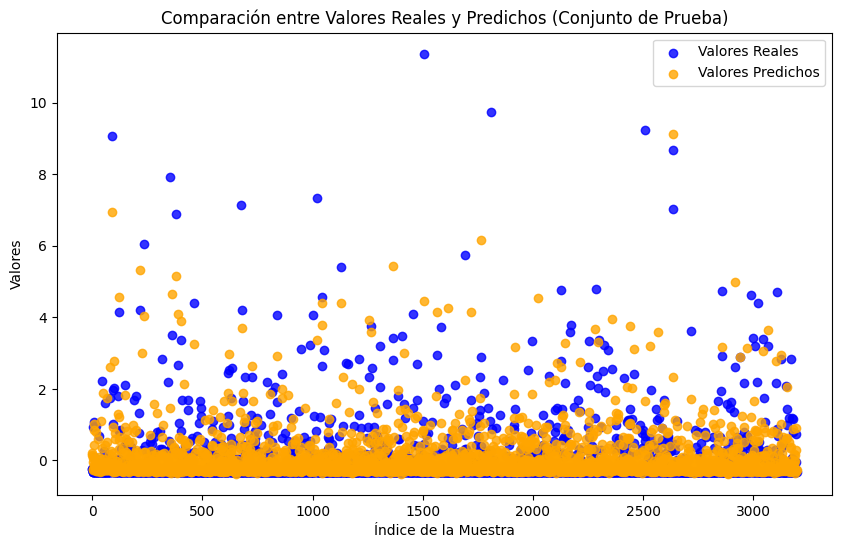

In [ ]:
# Crear un conjunto de colores para los puntos reales y predichos
colors_real = 'blue'
colors_pred = 'orange'

# Graficar valores reales y predicciones
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(y_test)), y_test, color=colors_real, label='Valores Reales', alpha=0.8)
plt.scatter(np.arange(len(y_test)), y_pred_test_hp, color=colors_pred, label='Valores Predichos', alpha=0.8)

plt.title('Comparación entre Valores Reales y Predichos (Conjunto de Prueba)')
plt.xlabel('Índice de la Muestra')
plt.ylabel('Valores')
plt.legend()
plt.show()

In [ ]:
rn_regresion_comparacion['modelo_optmizado | 50 epocas'] = [mae_train_rneuronal_hp, mae_test_rneuronal_hp, r2_ajustado_entrenamiento_rneuronal_hp, r2_ajustado_prueba_rneuronal_hp]
round(rn_regresion_comparacion, 2)

arq1_mod1 | 500 epocas  arq2_mod1 | 500 epocas  \
mae_train                            0.28                    0.36   
mae_test                             0.34                    0.33   
r2_ajustado_train                    0.67                    0.37   
r2_ajustado_test                     0.00                    0.29   

                   arq2_mod2 | 3000 epocas  arq2_mod3 | 300 epocas  \
mae_train                             0.31                    0.41   
mae_test                              0.31                    0.38   
r2_ajustado_train                     0.43                    0.27   
r2_ajustado_test                      0.22                    0.24   

                   arq3_mod1 | 300 epocas  arq3_mod2 | 1000 epocas  \
mae_train                            0.31                     0.33   
mae_test                             0.30                     0.32   
r2_ajustado_train                    0.44                     0.45   
r2_ajustado_test                     0.29                     0.30   

                   arq3_mod3 | 1500 epocas  modelo_optmizado | 50 epocas  
mae_train                             0.32                          0.31  
mae_test                              0.31                          0.29  
r2_ajustado_train                     0.45                          0.44  
r2_ajustado_test                      0.28                          0.36

* Todos los modelos tienen mas o menos un MAE similar en test y traen.

* En cuanto al R2 ajustado de test en todos es un poco inferior al de train, lo que podria indicar sobreajuste en todos.

* Se prefiere el ultimo modelo que tiene un r2 ajustado de test mas alto y es de los que menos sobreajustaron.

### Eleccion del mejor modelo:

In [ ]:
redes_neuronales_reg_final = red_neuronal_regresion_opt

In [ ]:
# Exportamos:
redes_neuronales_reg_final.save('red_neuronal_regresion')

import tarfile
import os

folder_name = 'red_neuronal_regresion'

# Comprimir la carpeta en un archivo tar
tar_file_name = folder_name + '.tar.gz'
with tarfile.open(tar_file_name, 'w:gz') as tar:
    tar.add(folder_name, arcname=os.path.basename(folder_name))

### Explicabilidad:

#### Local:

In [ ]:
explainer_NN = shap.KernelExplainer(redes_neuronales_reg_final, X_train_z[:100])
valores_shap_NN = explainer_NN.shap_values(X_test_z[:100])

  0%|          | 0/100 [00:00<?, ?it/s]

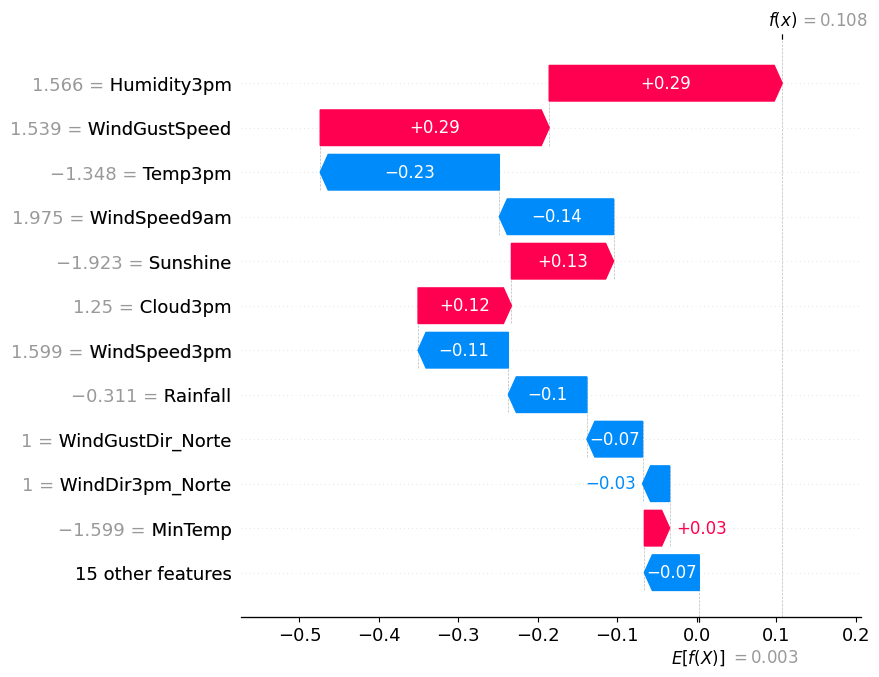

In [ ]:
# Crear un objeto Explanation
explanation_single = shap.Explanation(values=valores_shap_NN[0], base_values=explainer_NN.expected_value, feature_names=X_train_z.columns, data=X_test_z)

# Crear el gráfico de cascada para la explicación seleccionada
shap.plots.waterfall(explanation_single[0], max_display=12)

In [ ]:
# Inicializar la extensión JS para SHAP
shap.initjs()

# Force plot de la fila 0:
shap.force_plot(explainer_NN.expected_value, valores_shap_NN[0][0], X_test_clasificacion_z.iloc[0], feature_names=X_train_z.columns, figsize=(18, 4), \
                text_rotation=45)

Explicación de la predicción hecha sobre el evento correspondiente a la fila 1 de nuestro dataset de test. Podemos notar en el gráfico de fuerza y en el de cascada, que obtenemos una predicción de 0.11, "empujada" por los variables Humidity3pm y WindGustSpeed, mientras baja principalmente por Temp3pm y por WindSpeed9am.

#### Global:

In [ ]:
# Crear un objeto Explanation
explanation_NN = shap.Explanation(values=valores_shap_NN[0], base_values=explainer_NN.expected_value, feature_names=X_train_z.columns, data=X_test_z[:100])

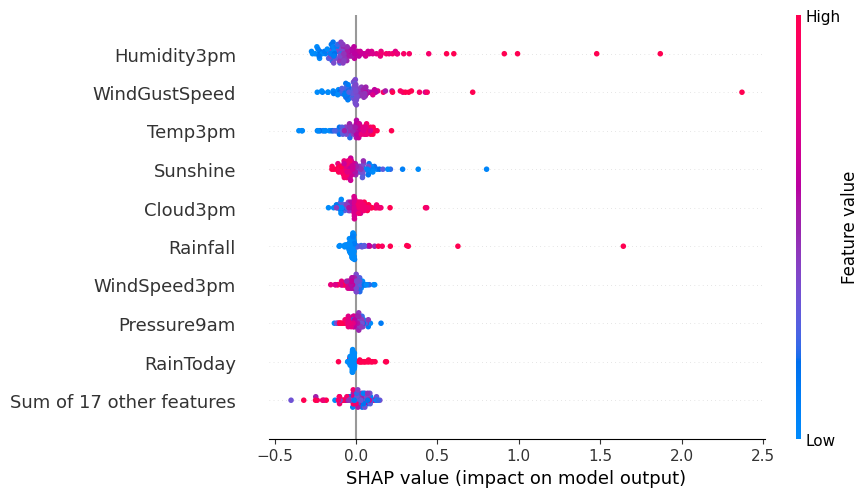

In [ ]:
# Grafico de abejas:
shap.plots.beeswarm(explanation_NN)

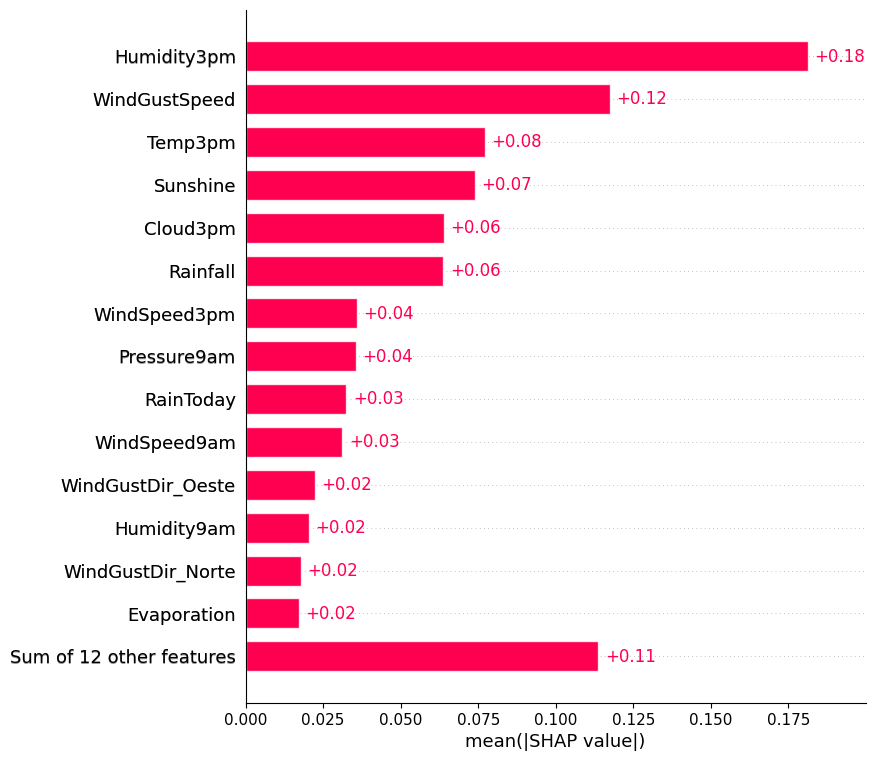

In [ ]:
# Grafico de barras
shap.plots.bar(explanation_NN, 15)

* Explicación de la predicciones globales del modelo. Podemos notar que Humidity y WindGustSpeed afectan de manera positiva los resultados de la predicción. Luego las 3 siguientes, Temp3pm, Sunshine y Cloud3pm también tienen peso, aunque en mucha menor medida.

# Modelo Base:

## Regresión:

Proponemos varios modelos y despues nos quedamos con uno

#### Modelo 1: predice la media de la variable dependiente en el conjunto de train:

In [ ]:
# Calcular el valor medio de la variable objetivo en el conjunto de entrenamiento
mean_train_rbase_1 = np.mean(y_train)

# Crear un array de igual dimension que y_test y llenarlo con el valor medio
y_pred_rbase_1 = np.full_like(y_test, mean_train_rbase_1)

# Calcular métricas de rendimiento del modelo base
mae_rbase_1 = mean_absolute_error(y_test, y_pred_rbase_1)
r2_rbase_1 = r2_score(y_test, y_pred_rbase_1)

# Imprimir las métricas del modelo base
print(f'MAE: {mae_rbase_1:.2f}')
print(f'R^2: {r2_rbase_1:.2f}')

MAE: 0.43
R^2: -0.00


Logicamente luego de plantearlo y analizarlo es claro que el modelo no va a explicar nada, en la formula del R2 se veria claro: 1 - (RSS / TSS. En este caso RSS = TSS ya que ambos son la distancia de los valores reales a la media.

#### Modelo 2: Predice por medio de una regresion lineal simple con la variable independiente que mayor correlacion lineal tenga con la dependiente

In [ ]:
# Datos:
X_train_rbase_2 = X_train_z[['Humidity3pm']]
X_test_rbase_2 = X_test_z[['Humidity3pm']]
y_train_rbase_2 = y_train
y_test_rbase_2 = y_test

# Modelo:
regresion_lineal = LinearRegression()
regresion_lineal.fit(X_train_rbase_2, y_train_rbase_2)

# Predicciones:
y_pred_rbase_2 = regresion_lineal.predict(X_test_rbase_2)

# Metricas:
mse_rbase_2 = mean_squared_error(y_test_rbase_2, y_pred_rbase_2)
mae_rbase_2 = mean_absolute_error(y_test_rbase_2, y_pred_rbase_2)
r2_rbase_2 = r2_score(y_test_rbase_2, y_pred_rbase_2)

print(f'MSE: {mse_rbase_2:.2f}')
print(f'MAE: {mae_rbase_2:.2f}')
print(f'R2: {r2_rbase_2:.2f}')

MSE: 0.59
MAE: 0.42
R2: 0.12


En este caso se obtienen mejores metricas que en el modelo que utilizaba la media.

#### Modelo 3: Predice en base a un umbral puesto en la variable que mayor correlacion tenga con la dependiente, si en el conjunto de test es mayor a tal umbral la prediccion es determinado numero, si es menor otro numero.

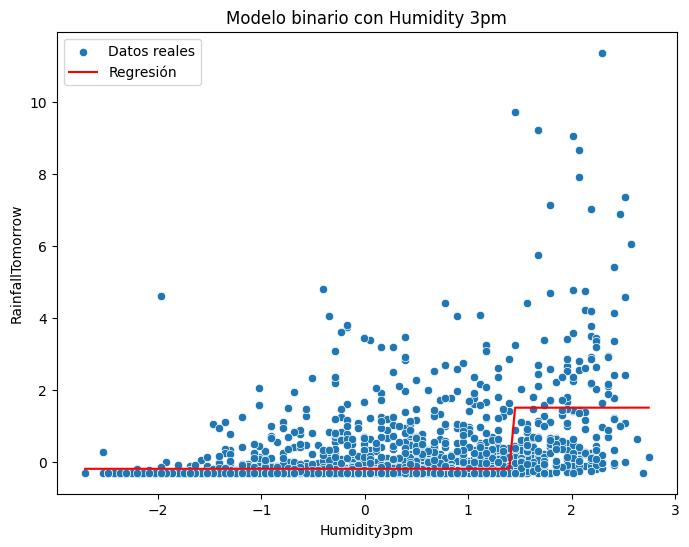

In [ ]:
# Calculamos las predicciones en la variable independiente en relacion a determinado umbral
y_pred_rbase_3 = np.where(X_test_z['Humidity3pm'] > 1.4, 1.5, -0.2)

# Graficamos el modelo binario
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_test_z['Humidity3pm'], y=y_test, label='Datos reales')
sns.lineplot(x=X_test_z['Humidity3pm'], y=y_pred_rbase_3, color='red', label='Regresión')
plt.title('Modelo binario con Humidity 3pm')
plt.legend()
plt.show()

In [ ]:
# Metricas
mse_rbase_3 = mean_squared_error(y_test, y_pred_rbase_3)
mae_rbase_3 = mean_absolute_error(y_test, y_pred_rbase_3)
r2_rbase_3 = r2_score(y_test, y_pred_rbase_3)

# Imprimimos las métricas de rendimiento del modelo
print(f'MSE: {mse_rbase_3:.2f}')
print(f'MAE: {mae_rbase_3:.2f}')
print(f'R2: {r2_rbase_3:.2f}')

MSE: 0.57
MAE: 0.33
R2: 0.15


* En este caso obtenemos metricas apenas mejor que en el modelo 2 que utilizaba la regresion lineal. Por lo que **nos quedaremos con este**.

### Modelos regresion vs base:

In [ ]:
indice = ['MSE', 'MAE', 'R2']
metricas_base_vs_regresion = pd.DataFrame(index=indice)
metricas_base_vs_regresion['base'] = [mse_rbase_3, mae_rbase_3, r2_rbase_3]
metricas_base_vs_regresion['regresion_lineal_lasso'] = [mse_test_lasso, mae_test_lasso, r2_ajustado_test_l]
metricas_base_vs_regresion['redes_neuronales_regresion_opt'] = [mse_test_rneuronal_hp, mae_test_rneuronal_hp, r2_ajustado_prueba_rneuronal_hp]
round(metricas_base_vs_regresion, 2)

base  regresion_lineal_lasso  redes_neuronales_regresion_opt
MSE  0.57                    0.51                            0.42
MAE  0.33                    0.39                            0.29
R2   0.15                    0.23                            0.36

* En regresion lineal nuestro modelo explica mas de la variable dependiente que el modelo base, pero pierde un poco en cuanto a la magnitud promedio del error (MAE).

* En redes neuronales le ganamos en todas las metricas.

## Clasificación:

#### Modelo 1: Predice a traves de una regresion logistica con una sola variable, la que mas correlacion tiene con la dependiente.

Matriz de confusion:
[[1691  744]
 [ 237  526]]
Reporte de Clasificacion:
              precision    recall  f1-score   support

           0       0.88      0.69      0.78      2435
           1       0.41      0.69      0.52       763

    accuracy                           0.69      3198
   macro avg       0.65      0.69      0.65      3198
weighted avg       0.77      0.69      0.71      3198

Area bajo la curva ROC:
0.6919199313204928



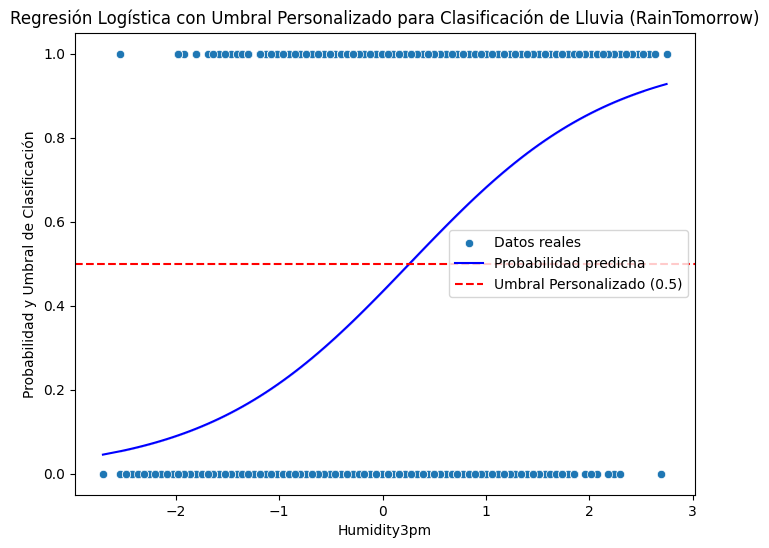

In [ ]:
# Variables independientes y dependientes:
X_train_cbase_1 = X_train_clasificacion_z['Humidity3pm']
X_test_cbase_1 = X_test_clasificacion_z['Humidity3pm']
y_train_cbase_1 = y_train_clasificacion
y_test_cbase_1 = y_test_clasificacion

# Oversample de datos de entrenamiento:
oversampler_cbase_1 = RandomOverSampler(random_state=42)
X_resampled_cbase_1, y_resampled_cbase_1 = oversampler_cbase_1.fit_resample(X_train_cbase_1.array.reshape(-1, 1), y_train_cbase_1)

# Regresion logistica:
regresion_logistica_cbase_1 = LogisticRegression()
regresion_logistica_cbase_1.fit(X_resampled_cbase_1, y_resampled_cbase_1)

# Probabilidades de que clase 1:
y_prob_cbase_1 = regresion_logistica_cbase_1.predict_proba(X_test_cbase_1.array.reshape(-1, 1))[:, 1]

# Aca podemos ajustar el umbral:
umbral = 0.5

# Aplicar el umbral para clasificar las predicciones
y_pred_umbral_cbase_1 = (y_prob_cbase_1 > umbral).astype(int)

# Metricas:
metricas_cbase = classification_report(y_test_cbase_1, y_pred_umbral_cbase_1, output_dict=True)
matriz_confusion = confusion_matrix(y_test_cbase_1, y_pred_umbral_cbase_1)
reporte_clases = classification_report(y_test_cbase_1, y_pred_umbral_cbase_1)
roc_auc = roc_auc_score(y_test_cbase_1, y_pred_umbral_cbase_1)

# Imprimir las métricas de rendimiento
print(f'Matriz de confusion:\n{matriz_confusion}')
print(f'Reporte de Clasificacion:\n{reporte_clases}')
print(f'Area bajo la curva ROC:\n{roc_auc}\n')

# Graficar el modelo con el umbral personalizado
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_test_cbase_1, y=y_test_cbase_1, label='Datos reales')
sns.lineplot(x=X_test_cbase_1, y=y_prob_cbase_1, color='blue', label='Probabilidad predicha')
plt.axhline(y=umbral, color='red', linestyle='--', label=f'Umbral Personalizado ({umbral})')
plt.title('Regresión Logística con Umbral Personalizado para Clasificación de Lluvia (RainTomorrow)')
plt.xlabel('Humidity3pm')
plt.ylabel('Probabilidad y Umbral de Clasificación')
plt.legend()
plt.show()

### Modelo base vs clasificacion:

In [ ]:
indices = ['f1_score_0', 'f1_score_1', 'f1_score_macro']
metricas_base_vs_clasificacion = pd.DataFrame(index=indices)
metricas_base_vs_clasificacion['base'] = [metricas_cbase['0']['f1-score'], metricas_cbase['1']['f1-score'], metricas_cbase['macro avg']['f1-score']]
metricas_base_vs_clasificacion['regresion_logistica_pesos'] = regresion_logistica_comparacion['regresion_logistica_pesos']
metricas_base_vs_clasificacion['redes_neuronales_clasificacion_sin_opt'] = rn_clasificacion_comparacion['red_neuronal_sin_opt']
round(metricas_base_vs_clasificacion, 2)

base  regresion_logistica_pesos  \
f1_score_0      0.78                       0.84   
f1_score_1      0.52                       0.61   
f1_score_macro  0.65                       0.73   

                redes_neuronales_clasificacion_sin_opt  
f1_score_0                                        0.85  
f1_score_1                                        0.62  
f1_score_macro                                    0.74

* Nuestro mejor modelo de regresion logistica le gano al modelo base tanto f1 score macro que es lo que nos interesaba, como en los f1 score de cada clase puntual.

* El modelo de redes neuronales tambien le gano al modelo base.